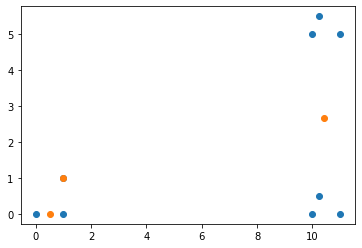

In [9]:
%run Implementation.ipynb

In [10]:
import os
import scipy.io as sio

In [11]:
# Assignment 7

In [24]:
#ASSIGNMENT 6 GMM PLOT ---> NEEDS SCIPY.LINALG.SQRTM
def plot_gmm_solution_7(X,mu,sigma):
    """
    This function plots the different gaussians found by the EM algorithm as ellipses centred around the distributions' means.
    
    Input:
    X=data (nxd)
    mu=distribution centres (kxd)
    sigma=list of k dxd covariance matrices
    
    """
    #plot data points and setup plot parameters
    #plt.figure(figsize=(10,10))
    plt.scatter(X.T[0],X.T[1],s=20)
    plt.title('GMM solution found by EM algorithm with k = {}'.format(len(mu)))
    plt.ylabel('X2')
    plt.xlabel('X1')
    plt.grid(True)


    #draw ellipse
    for i,sig in enumerate(sigma):
        tline = np.linspace(0, 2 * np.pi, 100)
        sphere = np.vstack((np.sin([tline]), np.cos([tline])))
        ellipse = sqrtm(sig).dot(sphere)
        plt.plot(mu[i][0] + ellipse[0, :], mu[i][1] + ellipse[1, :],linewidth=4, color = 'k')
        #plot centre points
        plt.scatter(mu[i][0],mu[i][1],c='r',marker='x')

In [25]:
def em_gmm_7(X, k, max_iter=100, init_kmeans=False, tol=0.00001, converge_tol=0.0001):
    """
    This function applies the EM algorithm for Gaussian Mixture Models.
    It's adapted to investigate the quality as it has an extra output - iteration

    Inputs:
    X = data (nxd)
    k = number of gaussian components
    max_iter = the maximum amount of iterations attempted to find convergence
    init_kmeans = Initialises the EM algorithm using kmeans function, if True. Default is False.
    tol = The tolerance set for the convergence condition
    converge_tol = Tolerance for the convergence condition (optional)

    Outputs:
    pi = probability that a datapoint belongs to a cluster (1xk)
    mu = center points of clusters (kxd)
    sigma = list of k dxd covariance matrices
    loglik = the loglikehlihood at each iteration
    iteration = number of iterations until convergence
    """

    if init_kmeans == True:
        # 1.a INIT_KMEANS
        mu, r, _ = kmeans(X, k)
        unique, counts = np.unique(r, return_counts=True)
        pi = counts / np.sum(counts)

    else:
        # 1.b RANDOM INITIALISATIONS
        pi = np.full(shape=(k, 1), fill_value=1 / k)  # kx1
        rand_samples = np.random.choice(X.shape[0], size=(k,), replace=False)  # choose k random data points
        mu = X[rand_samples]  # centroid initialisation as random points, kxd

    # setup storage and loop
    sigma = [np.eye(X.shape[1]) for i in range(k)]  # dxd
    likelihoods = np.zeros(shape=(X.shape[0], k), dtype=float)  # nxk
    converged = False
    iteration = 1
    while (not converged) & (iteration <= max_iter):

        print('Iteration Number:\n', iteration)

        # 2. E-STEP - compute new likelihoods and responsibilities
        old_likelihoods = copy.deepcopy(likelihoods)
        # print('Old likelihoods\n', old_likelihoods)

        # 2.1 first find all k likelihoods
        for i in range(k):
            # nx1                             1x1 X nx1  = nx1
            likelihood = (pi[i] * norm_pdf(X, mu[i], sigma[i]))  # norm_pdf written to handle mu=(1xd) only
            likelihoods.T[i] = likelihood

        # CALC LOGLIK
        loglik = np.log(np.sum(likelihoods, axis=1)).sum()
        print('Loglikelihood\n', loglik)

        # 2.2 use likelihoods to calculate individual k responsibilities
        # nxk            nxk              nx1
        responsibilities = likelihoods / np.sum(likelihoods, axis=1).reshape(likelihoods.shape[0], 1)

        # 3. M-STEP - compute new n,pi,mu,sigma
        # 1xk
        n = np.sum(responsibilities, axis=0)
        # 1xk
        pi = n / np.sum(n, axis=0)
        # kxd                    (nxkx0)x(nx0xd)=nxkxd --> kxd / kx1
        mu = np.sum(responsibilities[:, :, None] * X[:, None, :], axis=0) / n.reshape(n.shape[0], 1)
        # kxdxd         =  sum ((nxkx0x0)     x    (nxkxdx0)x(nxkx0xd)) = nxkxdxd-->kxdxd/kx0x0
        sigma = np.sum(responsibilities[:, :, None, None] * (X[:, None, :, None] - mu[None, :, :, None]) * (
                    X[:, None, None, :] - mu[None, :, None, :]), axis=0) / n[:, None, None]
        #   (nx0xdx0-nxkx0x0)-->(nxkxdx0)
        # add regularisation term, tol
        sigma = sigma + tol * np.eye(X.shape[1])

        # break condition - only runs from second iteration to prevent log of old_likelihoods, which is 0 in iteration 1
        if iteration > 1:
            if (np.log(np.sum(old_likelihoods, axis=1)).sum() - loglik).all() < converge_tol:
                converged = True

        iteration = iteration + 1

    # return as a list of covariances
    list_sigma = [sigma[i, :, :] for i in range(k)]
    return pi, mu, list_sigma, loglik, iteration

In [35]:
def CCR(true_mean, data, function = 'k-means',iteration = 100):
    tp = 0
    fp = 0
    if np.isin(function, ['GMM','GMM_kmean_init']):
        iter_ = np.zeros(iteration)
    for i in range(iteration):
        if function == 'k-means':
            mu, r, loss = kmeans(X = data, k = 5)
        elif function == 'GMM':
            pi, mu, list_sigma, likelihoods, iter_[i] = em_gmm_7(X = data, k = 5)
        elif function == 'GMM_kmean_init':
            pi, mu, list_sigma, likelihoods, iter_[i] = em_gmm_7(X = data, k = 5, init_kmeans = True)
  
        for i in range(5):
            if (np.linalg.norm(true_mean[i]-mu, axis = 1)<0.1).any():
                tp+= 1
            else:
                fp+= 1
    try:
        plt.figure()
        plt.bar(range(iteration),iter_)
        plt.ylim(0,100)
    except:
        print('k-means is used')
    CCR = tp / (tp+fp) # correct precision rate
    print('CCR is: {}'.format(CCR))
    return CCR

In [38]:
def assignment_7():
    
    # load data 
    cwd = os.getcwd()
    file_name = '5_gaussians.npy'
    path_to_data = cwd + '/data/'+file_name
    assert os.path.exists(path_to_data), "The path does not excist."
    gaussians = np.load(path_to_data).T
    
    # Visualize data
    plt.scatter(gaussians.T[0], gaussians.T[1])
    
    # k-means on 5 gaussian data sets
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 3)
    for k in range(2,8):
        mu, r, loss = kmeans(X = gaussians, k = k)
        f_ax1 = fig.add_subplot(gs[int(k>=5), (k-2)%3])
        plt.title('k-means solution with k = {}'.format(len(mu)))
        plt.ylabel('X2')
        plt.xlabel('X1')
        plt.scatter(gaussians.T[0], gaussians.T[1])
        plt.scatter (mu.T[0], mu.T[1])
    
    # GMM on 5 gaussian data sets - without k-means initialization
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 3)
    for k in range(2,8):
        pi, mu, list_sigma, likelihoods = em_gmm(X = gaussians, k = k)
        f_ax1 = fig.add_subplot(gs[int(k>=5), (k-2)%3])
        plot_gmm_solution_7(X = gaussians ,mu = mu, sigma = list_sigma)
        
    # GMM on 5 gaussian data sets - with k-means initialization
    fig = plt.figure(figsize=(16, 9))
    gs = fig.add_gridspec(2, 3)
    for k in range(2,8):
        pi, mu, list_sigma, likelihoods = em_gmm(X = gaussians, k = k, init_kmeans = True)
        fig.add_subplot(2, 3, k-1) 
        plot_gmm_solution_7(X = gaussians ,mu = mu, sigma = list_sigma)
        
    # dendogram
    mu, r, loss =  kmeans(gaussians,15)
    R, kmloss, mergeidx = kmeans_agglo(gaussians,r)
    agglo_dendro(kmloss, mergeidx)
    # visualization of k=5 centroids found by hierachical clustering
    fig = plt.figure(figsize=(16, 9))
    for i in [2,3,4]:
        r = R[-i]
        mu = np.array([np.sum(gaussians[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
        plt.subplot(1,3,i-1)
        plt.title('k = {}'.format(len(mu)))
        plt.ylabel('X2')
        plt.xlabel('X1')
        plt.scatter(gaussians.T[0], gaussians.T[1])
        plt.scatter (mu.T[0], mu.T[1])
    
    # interpret quality of k-means, GMM, GMM_km
    true_mean = np.vstack((np.mean(gaussians[:100], axis = 0),np.mean(gaussians[100:200], axis = 0),np.mean(gaussians[200:300], axis = 0), np.mean(gaussians[300:400], axis = 0),np.mean(gaussians[400:], axis = 0)))
    # CCR 
    # k-means
    CCR_km = CCR(true_mean, gaussians, function = 'k-means')
    # GMM
    CCR_GMM = CCR(true_mean, gaussians, function = 'GMM')
    # GMM_km
    CCR_GMM_km = CCR(true_mean, gaussians, function = 'GMM_kmean_init')

Iteration Number:
 1
Loglikelihood
 -1981.4281974818473
Iteration Number:
 2
Loglikelihood
 -1330.4936602897487
Iteration Number:
 3
Loglikelihood
 -1284.9117826651736
Iteration Number:
 4
Loglikelihood
 -1267.6288735311655
Iteration Number:
 5
Loglikelihood
 -1248.8538673085686
Iteration Number:
 6
Loglikelihood
 -1233.3827546860614
Iteration Number:
 7
Loglikelihood
 -1228.9835329671973
Iteration Number:
 8
Loglikelihood
 -1228.4430135415396
Iteration Number:
 9
Loglikelihood
 -1228.2855618835747
Iteration Number:
 10
Loglikelihood
 -1228.2195370631257
Iteration Number:
 11
Loglikelihood
 -1228.1898350156453
Iteration Number:
 12
Loglikelihood
 -1228.1760006953548
Iteration Number:
 13
Loglikelihood
 -1228.169412181117
Iteration Number:
 14
Loglikelihood
 -1228.1662277754585
Iteration Number:
 15
Loglikelihood
 -1228.1646735572929
Iteration Number:
 16
Loglikelihood
 -1228.163910234744
Iteration Number:
 17
Loglikelihood
 -1228.1635339906497
Iteration Number:
 18
Loglikelihood
 -1228

Loglikelihood
 -695.2569321010703
Iteration Number:
 24
Loglikelihood
 -667.0000493728884
Iteration Number:
 25
Loglikelihood
 -666.7012580163258
Iteration Number:
 26
Loglikelihood
 -666.7012497789576
Iteration Number:
 27
Loglikelihood
 -666.701249484288
Iteration Number:
 28
Loglikelihood
 -666.7012494002697
Iteration Number:
 29
Loglikelihood
 -666.7012493717006
Iteration Number:
 30
Loglikelihood
 -666.7012493608238
Iteration Number:
 31
Loglikelihood
 -666.7012493564147
Iteration Number:
 32
Loglikelihood
 -666.7012493545719
Iteration Number:
 33
Loglikelihood
 -666.7012493537908
Iteration Number:
 34
Loglikelihood
 -666.7012493534578
Iteration Number:
 35
Loglikelihood
 -666.7012493533155
Iteration Number:
 36
Loglikelihood
 -666.7012493532545
Iteration Number:
 37
Loglikelihood
 -666.7012493532284
Iteration Number:
 38
Loglikelihood
 -666.7012493532172
Iteration Number:
 39
Loglikelihood
 -666.7012493532125
Iteration Number:
 40
Loglikelihood
 -666.7012493532104
Iteration Numbe

Loglikelihood
 -747.0573520529954
Iteration Number:
 56
Loglikelihood
 -747.0186068369196
Iteration Number:
 57
Loglikelihood
 -746.9823759552328
Iteration Number:
 58
Loglikelihood
 -746.9484688158682
Iteration Number:
 59
Loglikelihood
 -746.9166441194084
Iteration Number:
 60
Loglikelihood
 -746.8866411950753
Iteration Number:
 61
Loglikelihood
 -746.858208143389
Iteration Number:
 62
Loglikelihood
 -746.8311229301942
Iteration Number:
 63
Loglikelihood
 -746.8052056290416
Iteration Number:
 64
Loglikelihood
 -746.7803219899924
Iteration Number:
 65
Loglikelihood
 -746.7563799754921
Iteration Number:
 66
Loglikelihood
 -746.733321659176
Iteration Number:
 67
Loglikelihood
 -746.7111129714514
Iteration Number:
 68
Loglikelihood
 -746.6897333804029
Iteration Number:
 69
Loglikelihood
 -746.6691669519867
Iteration Number:
 70
Loglikelihood
 -746.6493955496087
Iteration Number:
 71
Loglikelihood
 -746.6303943541309
Iteration Number:
 72
Loglikelihood
 -746.6121294792874
Iteration Number

Iteration Number:
 80
Loglikelihood
 -753.4017040248675
Iteration Number:
 81
Loglikelihood
 -753.4014529698491
Iteration Number:
 82
Loglikelihood
 -753.4011966758267
Iteration Number:
 83
Loglikelihood
 -753.4009343979687
Iteration Number:
 84
Loglikelihood
 -753.400665337707
Iteration Number:
 85
Loglikelihood
 -753.4003886337748
Iteration Number:
 86
Loglikelihood
 -753.400103352117
Iteration Number:
 87
Loglikelihood
 -753.3998084744467
Iteration Number:
 88
Loglikelihood
 -753.3995028851978
Iteration Number:
 89
Loglikelihood
 -753.3991853565655
Iteration Number:
 90
Loglikelihood
 -753.3988545312775
Iteration Number:
 91
Loglikelihood
 -753.3985089026677
Iteration Number:
 92
Loglikelihood
 -753.3981467915405
Iteration Number:
 93
Loglikelihood
 -753.3977663192147
Iteration Number:
 94
Loglikelihood
 -753.3973653760157
Iteration Number:
 95
Loglikelihood
 -753.3969415843306
Iteration Number:
 96
Loglikelihood
 -753.3964922551711
Iteration Number:
 97
Loglikelihood
 -753.39601433

Loglikelihood
 -659.3958623569388
Iteration Number:
 36
Loglikelihood
 -659.0938849805541
Iteration Number:
 37
Loglikelihood
 -658.8192940570191
Iteration Number:
 38
Loglikelihood
 -658.5569411270699
Iteration Number:
 39
Loglikelihood
 -658.2986501660448
Iteration Number:
 40
Loglikelihood
 -658.0369413059607
Iteration Number:
 41
Loglikelihood
 -657.7631088446528
Iteration Number:
 42
Loglikelihood
 -657.4677195510417
Iteration Number:
 43
Loglikelihood
 -657.1434142171967
Iteration Number:
 44
Loglikelihood
 -656.7907737684975
Iteration Number:
 45
Loglikelihood
 -656.4253208829998
Iteration Number:
 46
Loglikelihood
 -656.0768770971679
Iteration Number:
 47
Loglikelihood
 -655.7743109923371
Iteration Number:
 48
Loglikelihood
 -655.5290497414396
Iteration Number:
 49
Loglikelihood
 -655.3351496978765
Iteration Number:
 50
Loglikelihood
 -655.1800782595526
Iteration Number:
 51
Loglikelihood
 -655.0525974318093
Iteration Number:
 52
Loglikelihood
 -654.9448445216497
Iteration Numb

Iteration Number:
 1
Loglikelihood
 -1623.274003174086
Iteration Number:
 2
Loglikelihood
 -1306.7111947668336
Iteration Number:
 3
Loglikelihood
 -1141.4082683860358
Iteration Number:
 4
Loglikelihood
 -1049.8534727181873
Iteration Number:
 5
Loglikelihood
 -1013.6523179586476
Iteration Number:
 6
Loglikelihood
 -994.0956532310915
Iteration Number:
 7
Loglikelihood
 -976.289293940634
Iteration Number:
 8
Loglikelihood
 -950.0932119635816
Iteration Number:
 9
Loglikelihood
 -929.5592899248393
Iteration Number:
 10
Loglikelihood
 -912.1817731896945
Iteration Number:
 11
Loglikelihood
 -876.7687720782403
Iteration Number:
 12
Loglikelihood
 -836.7068541548169
Iteration Number:
 13
Loglikelihood
 -798.1051094670831
Iteration Number:
 14
Loglikelihood
 -761.2355553634079
Iteration Number:
 15
Loglikelihood
 -717.7614342368355
Iteration Number:
 16
Loglikelihood
 -675.3187352195484
Iteration Number:
 17
Loglikelihood
 -667.9288397693286
Iteration Number:
 18
Loglikelihood
 -666.933138739144

Loglikelihood
 -783.5448117190342
Iteration Number:
 19
Loglikelihood
 -756.5965003356889
Iteration Number:
 20
Loglikelihood
 -755.7361435536554
Iteration Number:
 21
Loglikelihood
 -755.1525271870291
Iteration Number:
 22
Loglikelihood
 -754.7605644056714
Iteration Number:
 23
Loglikelihood
 -754.4651158093452
Iteration Number:
 24
Loglikelihood
 -754.1853886588899
Iteration Number:
 25
Loglikelihood
 -753.8749897428197
Iteration Number:
 26
Loglikelihood
 -753.5306144442533
Iteration Number:
 27
Loglikelihood
 -753.2042909338411
Iteration Number:
 28
Loglikelihood
 -752.9620646419799
Iteration Number:
 29
Loglikelihood
 -752.8040524561717
Iteration Number:
 30
Loglikelihood
 -752.6880413575229
Iteration Number:
 31
Loglikelihood
 -752.5844983875695
Iteration Number:
 32
Loglikelihood
 -752.478871545464
Iteration Number:
 33
Loglikelihood
 -752.3623808294616
Iteration Number:
 34
Loglikelihood
 -752.2273429735998
Iteration Number:
 35
Loglikelihood
 -752.0633134469442
Iteration Numbe

Loglikelihood
 -856.22557026511
Iteration Number:
 96
Loglikelihood
 -856.2255702598793
Iteration Number:
 97
Loglikelihood
 -856.2255702570016
Iteration Number:
 98
Loglikelihood
 -856.2255702554513
Iteration Number:
 99
Loglikelihood
 -856.2255702546411
Iteration Number:
 100
Loglikelihood
 -856.2255702542361
Iteration Number:
 1
Loglikelihood
 -1502.822251346783
Iteration Number:
 2
Loglikelihood
 -1251.6747782254386
Iteration Number:
 3
Loglikelihood
 -1078.4293962167421
Iteration Number:
 4
Loglikelihood
 -990.7824635026313
Iteration Number:
 5
Loglikelihood
 -954.8560167612904
Iteration Number:
 6
Loglikelihood
 -944.2685961848538
Iteration Number:
 7
Loglikelihood
 -939.5409732099243
Iteration Number:
 8
Loglikelihood
 -934.3429060092383
Iteration Number:
 9
Loglikelihood
 -927.9315045497059
Iteration Number:
 10
Loglikelihood
 -918.6496564503204
Iteration Number:
 11
Loglikelihood
 -902.8185538533165
Iteration Number:
 12
Loglikelihood
 -868.9599732788818
Iteration Number:
 13


Iteration Number:
 67
Loglikelihood
 -755.3706956895196
Iteration Number:
 68
Loglikelihood
 -755.3706956718501
Iteration Number:
 69
Loglikelihood
 -755.370695660075
Iteration Number:
 70
Loglikelihood
 -755.3706956522257
Iteration Number:
 71
Loglikelihood
 -755.370695646992
Iteration Number:
 72
Loglikelihood
 -755.3706956435026
Iteration Number:
 73
Loglikelihood
 -755.3706956411754
Iteration Number:
 74
Loglikelihood
 -755.3706956396235
Iteration Number:
 75
Loglikelihood
 -755.3706956385886
Iteration Number:
 76
Loglikelihood
 -755.3706956378985
Iteration Number:
 77
Loglikelihood
 -755.3706956374381
Iteration Number:
 78
Loglikelihood
 -755.3706956371311
Iteration Number:
 79
Loglikelihood
 -755.3706956369265
Iteration Number:
 80
Loglikelihood
 -755.3706956367901
Iteration Number:
 81
Loglikelihood
 -755.3706956366989
Iteration Number:
 82
Loglikelihood
 -755.3706956366382
Iteration Number:
 83
Loglikelihood
 -755.3706956365978
Iteration Number:
 84
Loglikelihood
 -755.37069563

Loglikelihood
 -941.3104363273368
Iteration Number:
 18
Loglikelihood
 -930.6961640462542
Iteration Number:
 19
Loglikelihood
 -913.7517302131905
Iteration Number:
 20
Loglikelihood
 -892.1495014009564
Iteration Number:
 21
Loglikelihood
 -858.8067039603065
Iteration Number:
 22
Loglikelihood
 -808.1995430860482
Iteration Number:
 23
Loglikelihood
 -787.349857268739
Iteration Number:
 24
Loglikelihood
 -767.632635183764
Iteration Number:
 25
Loglikelihood
 -741.7314381719514
Iteration Number:
 26
Loglikelihood
 -717.6469335611453
Iteration Number:
 27
Loglikelihood
 -712.7630286981145
Iteration Number:
 28
Loglikelihood
 -709.4013229704108
Iteration Number:
 29
Loglikelihood
 -705.3809994692888
Iteration Number:
 30
Loglikelihood
 -700.0244160950788
Iteration Number:
 31
Loglikelihood
 -692.0634515208515
Iteration Number:
 32
Loglikelihood
 -680.4206809312353
Iteration Number:
 33
Loglikelihood
 -669.9417853189186
Iteration Number:
 34
Loglikelihood
 -667.2201556759361
Iteration Number

Iteration Number:
 10
Loglikelihood
 -934.2908167972726
Iteration Number:
 11
Loglikelihood
 -928.7018438709603
Iteration Number:
 12
Loglikelihood
 -920.7968318390657
Iteration Number:
 13
Loglikelihood
 -908.2090481496889
Iteration Number:
 14
Loglikelihood
 -888.6344543154751
Iteration Number:
 15
Loglikelihood
 -866.3808813504088
Iteration Number:
 16
Loglikelihood
 -858.4551454909797
Iteration Number:
 17
Loglikelihood
 -856.8548784911529
Iteration Number:
 18
Loglikelihood
 -854.9199204728391
Iteration Number:
 19
Loglikelihood
 -851.2356484755334
Iteration Number:
 20
Loglikelihood
 -841.3935643546376
Iteration Number:
 21
Loglikelihood
 -809.0175282688579
Iteration Number:
 22
Loglikelihood
 -768.311074946129
Iteration Number:
 23
Loglikelihood
 -739.6740058204175
Iteration Number:
 24
Loglikelihood
 -710.0355410420422
Iteration Number:
 25
Loglikelihood
 -673.5736006255718
Iteration Number:
 26
Loglikelihood
 -666.7014034942581
Iteration Number:
 27
Loglikelihood
 -666.7012497

Loglikelihood
 -757.6354522924221
Iteration Number:
 42
Loglikelihood
 -757.6229840185891
Iteration Number:
 43
Loglikelihood
 -757.6104421804553
Iteration Number:
 44
Loglikelihood
 -757.5978050527716
Iteration Number:
 45
Loglikelihood
 -757.5850609290252
Iteration Number:
 46
Loglikelihood
 -757.5722046157496
Iteration Number:
 47
Loglikelihood
 -757.5592350002814
Iteration Number:
 48
Loglikelihood
 -757.5461533637792
Iteration Number:
 49
Loglikelihood
 -757.5329622119621
Iteration Number:
 50
Loglikelihood
 -757.5196644670254
Iteration Number:
 51
Loglikelihood
 -757.5062629131676
Iteration Number:
 52
Loglikelihood
 -757.4927598214763
Iteration Number:
 53
Loglikelihood
 -757.4791567024932
Iteration Number:
 54
Loglikelihood
 -757.4654541500576
Iteration Number:
 55
Loglikelihood
 -757.4516517504976
Iteration Number:
 56
Loglikelihood
 -757.4377480384607
Iteration Number:
 57
Loglikelihood
 -757.4237404857856
Iteration Number:
 58
Loglikelihood
 -757.4096255134687
Iteration Numb

Loglikelihood
 -752.5966317910229
Iteration Number:
 63
Loglikelihood
 -752.5385410178542
Iteration Number:
 64
Loglikelihood
 -752.4810286309782
Iteration Number:
 65
Loglikelihood
 -752.4238304955483
Iteration Number:
 66
Loglikelihood
 -752.3667866738153
Iteration Number:
 67
Loglikelihood
 -752.3098479183298
Iteration Number:
 68
Loglikelihood
 -752.2532090030946
Iteration Number:
 69
Loglikelihood
 -752.1974468162059
Iteration Number:
 70
Loglikelihood
 -752.1434785748472
Iteration Number:
 71
Loglikelihood
 -752.0922395109304
Iteration Number:
 72
Loglikelihood
 -752.0441634819643
Iteration Number:
 73
Loglikelihood
 -751.9986725875981
Iteration Number:
 74
Loglikelihood
 -751.9537945626482
Iteration Number:
 75
Loglikelihood
 -751.9057569224753
Iteration Number:
 76
Loglikelihood
 -751.8481639732406
Iteration Number:
 77
Loglikelihood
 -751.770588945925
Iteration Number:
 78
Loglikelihood
 -751.6589319563514
Iteration Number:
 79
Loglikelihood
 -751.5086129689835
Iteration Numbe

Loglikelihood
 -857.7543887897018
Iteration Number:
 69
Loglikelihood
 -857.7543887896622
Iteration Number:
 70
Loglikelihood
 -857.7543887896377
Iteration Number:
 71
Loglikelihood
 -857.7543887896228
Iteration Number:
 72
Loglikelihood
 -857.7543887896137
Iteration Number:
 73
Loglikelihood
 -857.754388789608
Iteration Number:
 74
Loglikelihood
 -857.7543887896043
Iteration Number:
 75
Loglikelihood
 -857.7543887896022
Iteration Number:
 76
Loglikelihood
 -857.7543887896011
Iteration Number:
 77
Loglikelihood
 -857.7543887896003
Iteration Number:
 78
Loglikelihood
 -857.7543887895997
Iteration Number:
 79
Loglikelihood
 -857.7543887895993
Iteration Number:
 80
Loglikelihood
 -857.7543887895994
Iteration Number:
 81
Loglikelihood
 -857.754388789599
Iteration Number:
 82
Loglikelihood
 -857.754388789599
Iteration Number:
 1
Loglikelihood
 -1551.7863344548136
Iteration Number:
 2
Loglikelihood
 -1245.3234427438792
Iteration Number:
 3
Loglikelihood
 -1052.2300553640434
Iteration Number:

Iteration Number:
 44
Loglikelihood
 -666.7012493532104
Iteration Number:
 45
Loglikelihood
 -666.7012493532094
Iteration Number:
 46
Loglikelihood
 -666.7012493532092
Iteration Number:
 47
Loglikelihood
 -666.7012493532089
Iteration Number:
 48
Loglikelihood
 -666.701249353209
Iteration Number:
 49
Loglikelihood
 -666.7012493532088
Iteration Number:
 50
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1596.3451871261582
Iteration Number:
 2
Loglikelihood
 -1232.6093201460521
Iteration Number:
 3
Loglikelihood
 -1085.7042556525057
Iteration Number:
 4
Loglikelihood
 -982.1245807938022
Iteration Number:
 5
Loglikelihood
 -955.8818108789028
Iteration Number:
 6
Loglikelihood
 -951.6498347001408
Iteration Number:
 7
Loglikelihood
 -949.3654439003038
Iteration Number:
 8
Loglikelihood
 -946.1245781108488
Iteration Number:
 9
Loglikelihood
 -940.0621265535345
Iteration Number:
 10
Loglikelihood
 -926.7255078618523
Iteration Number:
 11
Loglikelihood
 -897.0065703279873

Loglikelihood
 -738.3236597475709
Iteration Number:
 42
Loglikelihood
 -733.0761174501231
Iteration Number:
 43
Loglikelihood
 -727.0092063525001
Iteration Number:
 44
Loglikelihood
 -720.9587777929282
Iteration Number:
 45
Loglikelihood
 -715.4727017422085
Iteration Number:
 46
Loglikelihood
 -710.5094111873
Iteration Number:
 47
Loglikelihood
 -706.4299303817113
Iteration Number:
 48
Loglikelihood
 -703.3387703056635
Iteration Number:
 49
Loglikelihood
 -700.8303579444186
Iteration Number:
 50
Loglikelihood
 -697.958078412388
Iteration Number:
 51
Loglikelihood
 -693.1371108627538
Iteration Number:
 52
Loglikelihood
 -686.0916266812741
Iteration Number:
 53
Loglikelihood
 -677.5823099364726
Iteration Number:
 54
Loglikelihood
 -670.5811280369729
Iteration Number:
 55
Loglikelihood
 -667.778532990255
Iteration Number:
 56
Loglikelihood
 -666.9259043856148
Iteration Number:
 57
Loglikelihood
 -666.7416302449765
Iteration Number:
 58
Loglikelihood
 -666.708458545183
Iteration Number:
 5

Loglikelihood
 -859.7709701598874
Iteration Number:
 89
Loglikelihood
 -859.7647102080361
Iteration Number:
 90
Loglikelihood
 -859.7583502352188
Iteration Number:
 91
Loglikelihood
 -859.7518706866977
Iteration Number:
 92
Loglikelihood
 -859.7452491300432
Iteration Number:
 93
Loglikelihood
 -859.738459808161
Iteration Number:
 94
Loglikelihood
 -859.7314731002436
Iteration Number:
 95
Loglikelihood
 -859.7242548707206
Iteration Number:
 96
Loglikelihood
 -859.7167656815018
Iteration Number:
 97
Loglikelihood
 -859.7089598368013
Iteration Number:
 98
Loglikelihood
 -859.7007842222447
Iteration Number:
 99
Loglikelihood
 -859.6921768903363
Iteration Number:
 100
Loglikelihood
 -859.6830653322363
Iteration Number:
 1
Loglikelihood
 -1510.8042503636807
Iteration Number:
 2
Loglikelihood
 -1203.2020392802647
Iteration Number:
 3
Loglikelihood
 -1011.1865750343966
Iteration Number:
 4
Loglikelihood
 -951.6845388740068
Iteration Number:
 5
Loglikelihood
 -946.3084222984401
Iteration Number

Loglikelihood
 -945.9410897363911
Iteration Number:
 20
Loglikelihood
 -944.1139394970743
Iteration Number:
 21
Loglikelihood
 -942.4990466717253
Iteration Number:
 22
Loglikelihood
 -940.8117903018058
Iteration Number:
 23
Loglikelihood
 -939.0431934563085
Iteration Number:
 24
Loglikelihood
 -937.2466615408491
Iteration Number:
 25
Loglikelihood
 -935.4706021202119
Iteration Number:
 26
Loglikelihood
 -933.7297782502037
Iteration Number:
 27
Loglikelihood
 -931.9499732363786
Iteration Number:
 28
Loglikelihood
 -929.8884058376433
Iteration Number:
 29
Loglikelihood
 -927.061698411525
Iteration Number:
 30
Loglikelihood
 -922.4414778391431
Iteration Number:
 31
Loglikelihood
 -913.4264732109874
Iteration Number:
 32
Loglikelihood
 -895.2142057443987
Iteration Number:
 33
Loglikelihood
 -876.8380157769718
Iteration Number:
 34
Loglikelihood
 -867.3862323768312
Iteration Number:
 35
Loglikelihood
 -857.6048962396553
Iteration Number:
 36
Loglikelihood
 -849.2676276178021
Iteration Numbe

Loglikelihood
 -754.2939875945212
Iteration Number:
 52
Loglikelihood
 -754.2551954095479
Iteration Number:
 53
Loglikelihood
 -754.2138602506561
Iteration Number:
 54
Loglikelihood
 -754.1699485424912
Iteration Number:
 55
Loglikelihood
 -754.123495049289
Iteration Number:
 56
Loglikelihood
 -754.0746287364394
Iteration Number:
 57
Loglikelihood
 -754.0236021865186
Iteration Number:
 58
Loglikelihood
 -753.9708215557389
Iteration Number:
 59
Loglikelihood
 -753.9168713500778
Iteration Number:
 60
Loglikelihood
 -753.8625251942642
Iteration Number:
 61
Loglikelihood
 -753.8087314749099
Iteration Number:
 62
Loglikelihood
 -753.756563435076
Iteration Number:
 63
Loglikelihood
 -753.7071294984034
Iteration Number:
 64
Loglikelihood
 -753.6614522371331
Iteration Number:
 65
Loglikelihood
 -753.6203401347652
Iteration Number:
 66
Loglikelihood
 -753.5842867706401
Iteration Number:
 67
Loglikelihood
 -753.5534282358738
Iteration Number:
 68
Loglikelihood
 -753.5275699315829
Iteration Number

Loglikelihood
 -668.2311018340071
Iteration Number:
 19
Loglikelihood
 -666.9574973058072
Iteration Number:
 20
Loglikelihood
 -666.7534930843067
Iteration Number:
 21
Loglikelihood
 -666.7113211249558
Iteration Number:
 22
Loglikelihood
 -666.703143376124
Iteration Number:
 23
Loglikelihood
 -666.7016046422991
Iteration Number:
 24
Loglikelihood
 -666.7013169707028
Iteration Number:
 25
Loglikelihood
 -666.7012627303071
Iteration Number:
 26
Loglikelihood
 -666.7012522178909
Iteration Number:
 27
Loglikelihood
 -666.701250054107
Iteration Number:
 28
Loglikelihood
 -666.7012495568567
Iteration Number:
 29
Loglikelihood
 -666.7012494227176
Iteration Number:
 30
Loglikelihood
 -666.7012493797308
Iteration Number:
 31
Loglikelihood
 -666.7012493639728
Iteration Number:
 32
Loglikelihood
 -666.7012493577103
Iteration Number:
 33
Loglikelihood
 -666.7012493551169
Iteration Number:
 34
Loglikelihood
 -666.7012493540224
Iteration Number:
 35
Loglikelihood
 -666.7012493535567
Iteration Number

Loglikelihood
 -704.9884250521583
Iteration Number:
 40
Loglikelihood
 -699.4686365526225
Iteration Number:
 41
Loglikelihood
 -691.2096911418977
Iteration Number:
 42
Loglikelihood
 -679.3216084710958
Iteration Number:
 43
Loglikelihood
 -669.4454931116506
Iteration Number:
 44
Loglikelihood
 -667.1540338792886
Iteration Number:
 45
Loglikelihood
 -666.7958856584048
Iteration Number:
 46
Loglikelihood
 -666.7198428918181
Iteration Number:
 47
Loglikelihood
 -666.7047663375004
Iteration Number:
 48
Loglikelihood
 -666.7019084174526
Iteration Number:
 49
Loglikelihood
 -666.7013738407471
Iteration Number:
 50
Loglikelihood
 -666.7012735408032
Iteration Number:
 51
Loglikelihood
 -666.7012543538924
Iteration Number:
 52
Loglikelihood
 -666.7012505106592
Iteration Number:
 53
Loglikelihood
 -666.7012496682576
Iteration Number:
 54
Loglikelihood
 -666.7012494549891
Iteration Number:
 55
Loglikelihood
 -666.7012493907198
Iteration Number:
 56
Loglikelihood
 -666.7012493681598
Iteration Numb

Loglikelihood
 -823.9534771645053
Iteration Number:
 19
Loglikelihood
 -818.2809339315804
Iteration Number:
 20
Loglikelihood
 -813.1540878500116
Iteration Number:
 21
Loglikelihood
 -807.3493736196579
Iteration Number:
 22
Loglikelihood
 -799.2407057050366
Iteration Number:
 23
Loglikelihood
 -786.2166103128109
Iteration Number:
 24
Loglikelihood
 -766.5095785267245
Iteration Number:
 25
Loglikelihood
 -757.03364405772
Iteration Number:
 26
Loglikelihood
 -756.9195285268991
Iteration Number:
 27
Loglikelihood
 -756.895233570292
Iteration Number:
 28
Loglikelihood
 -756.8739505448834
Iteration Number:
 29
Loglikelihood
 -756.8546581753491
Iteration Number:
 30
Loglikelihood
 -756.8365408067077
Iteration Number:
 31
Loglikelihood
 -756.8188861498838
Iteration Number:
 32
Loglikelihood
 -756.8010024963039
Iteration Number:
 33
Loglikelihood
 -756.7821294844033
Iteration Number:
 34
Loglikelihood
 -756.7613154041486
Iteration Number:
 35
Loglikelihood
 -756.7372142984624
Iteration Number:

Iteration Number:
 13
Loglikelihood
 -921.7619627067604
Iteration Number:
 14
Loglikelihood
 -913.1696376806364
Iteration Number:
 15
Loglikelihood
 -907.1304865665161
Iteration Number:
 16
Loglikelihood
 -901.3593250348495
Iteration Number:
 17
Loglikelihood
 -893.0820000281296
Iteration Number:
 18
Loglikelihood
 -880.170281702668
Iteration Number:
 19
Loglikelihood
 -868.396793856549
Iteration Number:
 20
Loglikelihood
 -864.7779021956276
Iteration Number:
 21
Loglikelihood
 -863.637335752718
Iteration Number:
 22
Loglikelihood
 -863.0432167054106
Iteration Number:
 23
Loglikelihood
 -862.6489672028906
Iteration Number:
 24
Loglikelihood
 -862.3444819811792
Iteration Number:
 25
Loglikelihood
 -862.0814596807297
Iteration Number:
 26
Loglikelihood
 -861.8400745658638
Iteration Number:
 27
Loglikelihood
 -861.613015204311
Iteration Number:
 28
Loglikelihood
 -861.3915129794817
Iteration Number:
 29
Loglikelihood
 -861.1607505792165
Iteration Number:
 30
Loglikelihood
 -860.9010961347

Loglikelihood
 -999.7874002657443
Iteration Number:
 4
Loglikelihood
 -959.3197954260293
Iteration Number:
 5
Loglikelihood
 -947.0984114271761
Iteration Number:
 6
Loglikelihood
 -937.9104159688972
Iteration Number:
 7
Loglikelihood
 -921.8060439683829
Iteration Number:
 8
Loglikelihood
 -886.1952867296677
Iteration Number:
 9
Loglikelihood
 -850.1795304139291
Iteration Number:
 10
Loglikelihood
 -818.9416915209006
Iteration Number:
 11
Loglikelihood
 -784.4780767636329
Iteration Number:
 12
Loglikelihood
 -756.5110956304084
Iteration Number:
 13
Loglikelihood
 -756.1139879232228
Iteration Number:
 14
Loglikelihood
 -756.0696506906149
Iteration Number:
 15
Loglikelihood
 -756.027029490476
Iteration Number:
 16
Loglikelihood
 -755.9847598612306
Iteration Number:
 17
Loglikelihood
 -755.9420986899254
Iteration Number:
 18
Loglikelihood
 -755.898573661353
Iteration Number:
 19
Loglikelihood
 -755.8538324277795
Iteration Number:
 20
Loglikelihood
 -755.8075660965342
Iteration Number:
 21


Loglikelihood
 -970.4848499186398
Iteration Number:
 11
Loglikelihood
 -941.6084718189524
Iteration Number:
 12
Loglikelihood
 -908.7164406045085
Iteration Number:
 13
Loglikelihood
 -849.2844787968742
Iteration Number:
 14
Loglikelihood
 -785.9029630219995
Iteration Number:
 15
Loglikelihood
 -756.7928972631302
Iteration Number:
 16
Loglikelihood
 -756.2651528595728
Iteration Number:
 17
Loglikelihood
 -756.0562086872194
Iteration Number:
 18
Loglikelihood
 -755.9181953555665
Iteration Number:
 19
Loglikelihood
 -755.818516323236
Iteration Number:
 20
Loglikelihood
 -755.7387358254572
Iteration Number:
 21
Loglikelihood
 -755.6682579528763
Iteration Number:
 22
Loglikelihood
 -755.6007753230929
Iteration Number:
 23
Loglikelihood
 -755.532244491443
Iteration Number:
 24
Loglikelihood
 -755.4596811563869
Iteration Number:
 25
Loglikelihood
 -755.3803871264254
Iteration Number:
 26
Loglikelihood
 -755.2913893212252
Iteration Number:
 27
Loglikelihood
 -755.1889571065853
Iteration Number

Loglikelihood
 -751.9077932713703
Iteration Number:
 60
Loglikelihood
 -751.9076786559216
Iteration Number:
 61
Loglikelihood
 -751.9075891287231
Iteration Number:
 62
Loglikelihood
 -751.9075192712558
Iteration Number:
 63
Loglikelihood
 -751.9074648359212
Iteration Number:
 64
Loglikelihood
 -751.9074224897314
Iteration Number:
 65
Loglikelihood
 -751.9073896157926
Iteration Number:
 66
Loglikelihood
 -751.9073641587747
Iteration Number:
 67
Loglikelihood
 -751.9073445042152
Iteration Number:
 68
Loglikelihood
 -751.9073293840361
Iteration Number:
 69
Loglikelihood
 -751.9073178024529
Iteration Number:
 70
Loglikelihood
 -751.9073089778115
Iteration Number:
 71
Loglikelihood
 -751.9073022968771
Iteration Number:
 72
Loglikelihood
 -751.9072972788932
Iteration Number:
 73
Loglikelihood
 -751.9072935473002
Iteration Number:
 74
Loglikelihood
 -751.907290807477
Iteration Number:
 75
Loglikelihood
 -751.9072888292169
Iteration Number:
 76
Loglikelihood
 -751.9072874329278
Iteration Numbe

Iteration Number:
 33
Loglikelihood
 -920.0114499667494
Iteration Number:
 34
Loglikelihood
 -912.3300639219945
Iteration Number:
 35
Loglikelihood
 -904.3636823965046
Iteration Number:
 36
Loglikelihood
 -898.0055323559899
Iteration Number:
 37
Loglikelihood
 -893.8787367188272
Iteration Number:
 38
Loglikelihood
 -891.2255136856636
Iteration Number:
 39
Loglikelihood
 -889.3204008988939
Iteration Number:
 40
Loglikelihood
 -887.7579524811483
Iteration Number:
 41
Loglikelihood
 -886.2725689837348
Iteration Number:
 42
Loglikelihood
 -884.5848047128568
Iteration Number:
 43
Loglikelihood
 -882.1985127884147
Iteration Number:
 44
Loglikelihood
 -878.1821826571029
Iteration Number:
 45
Loglikelihood
 -871.9739379817844
Iteration Number:
 46
Loglikelihood
 -864.7181591912024
Iteration Number:
 47
Loglikelihood
 -858.1743503266802
Iteration Number:
 48
Loglikelihood
 -852.3289731343428
Iteration Number:
 49
Loglikelihood
 -844.9920512763858
Iteration Number:
 50
Loglikelihood
 -831.126824

Iteration Number:
 72
Loglikelihood
 -753.5320236000808
Iteration Number:
 73
Loglikelihood
 -753.5099153350266
Iteration Number:
 74
Loglikelihood
 -753.4918922729505
Iteration Number:
 75
Loglikelihood
 -753.4773247607123
Iteration Number:
 76
Loglikelihood
 -753.4655992279445
Iteration Number:
 77
Loglikelihood
 -753.4561650442793
Iteration Number:
 78
Loglikelihood
 -753.4485546573054
Iteration Number:
 79
Loglikelihood
 -753.4423855576717
Iteration Number:
 80
Loglikelihood
 -753.4373523329202
Iteration Number:
 81
Loglikelihood
 -753.4332147646278
Iteration Number:
 82
Loglikelihood
 -753.4297854766579
Iteration Number:
 83
Loglikelihood
 -753.4269188266876
Iteration Number:
 84
Loglikelihood
 -753.4245016302392
Iteration Number:
 85
Loglikelihood
 -753.4224457366672
Iteration Number:
 86
Loglikelihood
 -753.4206822335357
Iteration Number:
 87
Loglikelihood
 -753.4191569865764
Iteration Number:
 88
Loglikelihood
 -753.4178272334834
Iteration Number:
 89
Loglikelihood
 -753.416658

Loglikelihood
 -666.701249357551
Iteration Number:
 34
Loglikelihood
 -666.7012493550501
Iteration Number:
 35
Loglikelihood
 -666.7012493539941
Iteration Number:
 36
Loglikelihood
 -666.7012493535447
Iteration Number:
 37
Loglikelihood
 -666.7012493533526
Iteration Number:
 38
Loglikelihood
 -666.7012493532704
Iteration Number:
 39
Loglikelihood
 -666.7012493532354
Iteration Number:
 40
Loglikelihood
 -666.7012493532202
Iteration Number:
 41
Loglikelihood
 -666.7012493532136
Iteration Number:
 42
Loglikelihood
 -666.7012493532109
Iteration Number:
 43
Loglikelihood
 -666.7012493532097
Iteration Number:
 44
Loglikelihood
 -666.7012493532093
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.7012493532088
Iteration Number:
 47
Loglikelihood
 -666.7012493532089
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 49
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1509.3775961240185
Iteration Numbe

Iteration Number:
 100
Loglikelihood
 -751.9072888107708
Iteration Number:
 1
Loglikelihood
 -1535.4576489448336
Iteration Number:
 2
Loglikelihood
 -1219.7725155661833
Iteration Number:
 3
Loglikelihood
 -1013.5754662878554
Iteration Number:
 4
Loglikelihood
 -954.4667532664762
Iteration Number:
 5
Loglikelihood
 -952.6665400447607
Iteration Number:
 6
Loglikelihood
 -951.6711678532623
Iteration Number:
 7
Loglikelihood
 -950.3485089207277
Iteration Number:
 8
Loglikelihood
 -948.725472763435
Iteration Number:
 9
Loglikelihood
 -946.7373557043459
Iteration Number:
 10
Loglikelihood
 -944.0342504341431
Iteration Number:
 11
Loglikelihood
 -939.7713426678296
Iteration Number:
 12
Loglikelihood
 -932.1463282113318
Iteration Number:
 13
Loglikelihood
 -916.9478248504568
Iteration Number:
 14
Loglikelihood
 -880.4701194810359
Iteration Number:
 15
Loglikelihood
 -813.9038077496796
Iteration Number:
 16
Loglikelihood
 -766.0875148379744
Iteration Number:
 17
Loglikelihood
 -752.174345502460

Iteration Number:
 68
Loglikelihood
 -755.3706956359331
Iteration Number:
 69
Loglikelihood
 -755.3706956361148
Iteration Number:
 70
Loglikelihood
 -755.3706956362419
Iteration Number:
 71
Loglikelihood
 -755.3706956363299
Iteration Number:
 72
Loglikelihood
 -755.3706956363901
Iteration Number:
 73
Loglikelihood
 -755.3706956364312
Iteration Number:
 74
Loglikelihood
 -755.3706956364592
Iteration Number:
 75
Loglikelihood
 -755.3706956364781
Iteration Number:
 76
Loglikelihood
 -755.3706956364908
Iteration Number:
 77
Loglikelihood
 -755.3706956364994
Iteration Number:
 78
Loglikelihood
 -755.370695636505
Iteration Number:
 79
Loglikelihood
 -755.3706956365088
Iteration Number:
 80
Loglikelihood
 -755.3706956365115
Iteration Number:
 81
Loglikelihood
 -755.3706956365131
Iteration Number:
 82
Loglikelihood
 -755.3706956365144
Iteration Number:
 83
Loglikelihood
 -755.3706956365152
Iteration Number:
 84
Loglikelihood
 -755.3706956365156
Iteration Number:
 85
Loglikelihood
 -755.3706956

Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1525.4985942818553
Iteration Number:
 2
Loglikelihood
 -1226.4651713377284
Iteration Number:
 3
Loglikelihood
 -1035.50951476835
Iteration Number:
 4
Loglikelihood
 -965.2465702815094
Iteration Number:
 5
Loglikelihood
 -948.1157189743001
Iteration Number:
 6
Loglikelihood
 -940.9323030584038
Iteration Number:
 7
Loglikelihood
 -933.6335286641206
Iteration Number:
 8
Loglikelihood
 -923.4095656884579
Iteration Number:
 9
Loglikelihood
 -904.8735078707698
Iteration Number:
 10
Loglikelihood
 -866.1887071006147
Iteration Number:
 11
Loglikelihood
 -815.8855126599564
Iteration Number:
 12
Loglikelihood
 -775.5370126382422
Iteration Number:
 13
Loglikelihood
 -729.8042998481743
Iteration Number:
 14
Loglikelihood
 -693.5021534501984
Iteration Number:
 15
Loglikelihood
 -681.7964883641719
Iteration Number:
 16
Loglikelihood
 -670.625515875616
Iteration Number:
 17
Loglikelihood
 -667.2892590555339
Iteration Number:
 18
L

Iteration Number:
 28
Loglikelihood
 -909.3590699492145
Iteration Number:
 29
Loglikelihood
 -903.1316486136814
Iteration Number:
 30
Loglikelihood
 -891.386280654732
Iteration Number:
 31
Loglikelihood
 -862.3207439912886
Iteration Number:
 32
Loglikelihood
 -813.427625657354
Iteration Number:
 33
Loglikelihood
 -781.7177685717327
Iteration Number:
 34
Loglikelihood
 -746.6482434533846
Iteration Number:
 35
Loglikelihood
 -725.2139816089451
Iteration Number:
 36
Loglikelihood
 -714.4874548864171
Iteration Number:
 37
Loglikelihood
 -709.3113581646844
Iteration Number:
 38
Loglikelihood
 -705.2757920731942
Iteration Number:
 39
Loglikelihood
 -699.8775519412554
Iteration Number:
 40
Loglikelihood
 -691.8352430635124
Iteration Number:
 41
Loglikelihood
 -680.1199877351069
Iteration Number:
 42
Loglikelihood
 -669.7990027371297
Iteration Number:
 43
Loglikelihood
 -667.2012675912573
Iteration Number:
 44
Loglikelihood
 -666.8057687396511
Iteration Number:
 45
Loglikelihood
 -666.72186280

Iteration Number:
 20
Loglikelihood
 -759.3936395994433
Iteration Number:
 21
Loglikelihood
 -759.265806699608
Iteration Number:
 22
Loglikelihood
 -759.0385946608264
Iteration Number:
 23
Loglikelihood
 -758.6997011752494
Iteration Number:
 24
Loglikelihood
 -758.4166902879422
Iteration Number:
 25
Loglikelihood
 -758.225435298681
Iteration Number:
 26
Loglikelihood
 -758.0449496127262
Iteration Number:
 27
Loglikelihood
 -757.8460928626679
Iteration Number:
 28
Loglikelihood
 -757.6171810119007
Iteration Number:
 29
Loglikelihood
 -757.3589983993725
Iteration Number:
 30
Loglikelihood
 -757.0882658024293
Iteration Number:
 31
Loglikelihood
 -756.8307215667289
Iteration Number:
 32
Loglikelihood
 -756.6062379442101
Iteration Number:
 33
Loglikelihood
 -756.4220467897314
Iteration Number:
 34
Loglikelihood
 -756.2759511613762
Iteration Number:
 35
Loglikelihood
 -756.1612699983463
Iteration Number:
 36
Loglikelihood
 -756.0699504700659
Iteration Number:
 37
Loglikelihood
 -755.99439242

Loglikelihood
 -756.3556640945329
Iteration Number:
 78
Loglikelihood
 -756.3375271337788
Iteration Number:
 79
Loglikelihood
 -756.3183228025828
Iteration Number:
 80
Loglikelihood
 -756.2981336045507
Iteration Number:
 81
Loglikelihood
 -756.2770782220175
Iteration Number:
 82
Loglikelihood
 -756.2553097803723
Iteration Number:
 83
Loglikelihood
 -756.2330107592988
Iteration Number:
 84
Loglikelihood
 -756.2103846067475
Iteration Number:
 85
Loglikelihood
 -756.1876447084089
Iteration Number:
 86
Loglikelihood
 -756.1650019312657
Iteration Number:
 87
Loglikelihood
 -756.1426523245768
Iteration Number:
 88
Loglikelihood
 -756.1207665931599
Iteration Number:
 89
Loglikelihood
 -756.0994826232803
Iteration Number:
 90
Loglikelihood
 -756.0789017310032
Iteration Number:
 91
Loglikelihood
 -756.0590885974746
Iteration Number:
 92
Loglikelihood
 -756.0400742531643
Iteration Number:
 93
Loglikelihood
 -756.0218611122531
Iteration Number:
 94
Loglikelihood
 -756.0044289780287
Iteration Numb

Iteration Number:
 38
Loglikelihood
 -666.7012493551622
Iteration Number:
 39
Loglikelihood
 -666.7012493540417
Iteration Number:
 40
Loglikelihood
 -666.7012493535649
Iteration Number:
 41
Loglikelihood
 -666.7012493533612
Iteration Number:
 42
Loglikelihood
 -666.7012493532741
Iteration Number:
 43
Loglikelihood
 -666.7012493532369
Iteration Number:
 44
Loglikelihood
 -666.7012493532209
Iteration Number:
 45
Loglikelihood
 -666.701249353214
Iteration Number:
 46
Loglikelihood
 -666.7012493532111
Iteration Number:
 47
Loglikelihood
 -666.7012493532097
Iteration Number:
 48
Loglikelihood
 -666.7012493532093
Iteration Number:
 49
Loglikelihood
 -666.701249353209
Iteration Number:
 50
Loglikelihood
 -666.701249353209
Iteration Number:
 1
Loglikelihood
 -1527.5585623325674
Iteration Number:
 2
Loglikelihood
 -1242.211229177459
Iteration Number:
 3
Loglikelihood
 -1088.6173611189065
Iteration Number:
 4
Loglikelihood
 -1008.7677941822993
Iteration Number:
 5
Loglikelihood
 -979.27728039406

Loglikelihood
 -752.7612054101482
Iteration Number:
 49
Loglikelihood
 -752.7542798419645
Iteration Number:
 50
Loglikelihood
 -752.7484729496098
Iteration Number:
 51
Loglikelihood
 -752.7436094732432
Iteration Number:
 52
Loglikelihood
 -752.7395394659243
Iteration Number:
 53
Loglikelihood
 -752.7361353702601
Iteration Number:
 54
Loglikelihood
 -752.7332891863362
Iteration Number:
 55
Loglikelihood
 -752.7309098249902
Iteration Number:
 56
Loglikelihood
 -752.7289206987568
Iteration Number:
 57
Loglikelihood
 -752.7272575726164
Iteration Number:
 58
Loglikelihood
 -752.7258666760408
Iteration Number:
 59
Loglikelihood
 -752.7247030646712
Iteration Number:
 60
Loglikelihood
 -752.7237292123011
Iteration Number:
 61
Loglikelihood
 -752.7229138101
Iteration Number:
 62
Loglikelihood
 -752.722230748868
Iteration Number:
 63
Loglikelihood
 -752.7216582606737
Iteration Number:
 64
Loglikelihood
 -752.7211781977419
Iteration Number:
 65
Loglikelihood
 -752.7207754285273
Iteration Number:


Loglikelihood
 -666.7012493615391
Iteration Number:
 51
Loglikelihood
 -666.7012493567104
Iteration Number:
 52
Loglikelihood
 -666.7012493546965
Iteration Number:
 53
Loglikelihood
 -666.7012493538439
Iteration Number:
 54
Loglikelihood
 -666.7012493534803
Iteration Number:
 55
Loglikelihood
 -666.701249353325
Iteration Number:
 56
Loglikelihood
 -666.7012493532586
Iteration Number:
 57
Loglikelihood
 -666.7012493532302
Iteration Number:
 58
Loglikelihood
 -666.701249353218
Iteration Number:
 59
Loglikelihood
 -666.7012493532127
Iteration Number:
 60
Loglikelihood
 -666.7012493532106
Iteration Number:
 61
Loglikelihood
 -666.7012493532096
Iteration Number:
 62
Loglikelihood
 -666.7012493532092
Iteration Number:
 63
Loglikelihood
 -666.701249353209
Iteration Number:
 64
Loglikelihood
 -666.7012493532088
Iteration Number:
 65
Loglikelihood
 -666.701249353209
Iteration Number:
 66
Loglikelihood
 -666.7012493532089
Iteration Number:
 67
Loglikelihood
 -666.7012493532088
Iteration Number:


Loglikelihood
 -1027.2645977474517
Iteration Number:
 10
Loglikelihood
 -1008.5617191230056
Iteration Number:
 11
Loglikelihood
 -999.9080653596163
Iteration Number:
 12
Loglikelihood
 -986.1815067035532
Iteration Number:
 13
Loglikelihood
 -965.5449927674676
Iteration Number:
 14
Loglikelihood
 -957.6417827438456
Iteration Number:
 15
Loglikelihood
 -954.750379883654
Iteration Number:
 16
Loglikelihood
 -951.6360805260912
Iteration Number:
 17
Loglikelihood
 -948.1557440412407
Iteration Number:
 18
Loglikelihood
 -945.3789176712728
Iteration Number:
 19
Loglikelihood
 -943.5995523162267
Iteration Number:
 20
Loglikelihood
 -941.7494345397826
Iteration Number:
 21
Loglikelihood
 -939.7184436928537
Iteration Number:
 22
Loglikelihood
 -938.2278082952387
Iteration Number:
 23
Loglikelihood
 -937.0386756324881
Iteration Number:
 24
Loglikelihood
 -935.8484146201358
Iteration Number:
 25
Loglikelihood
 -934.4056215893324
Iteration Number:
 26
Loglikelihood
 -932.1262888915035
Iteration Num

Loglikelihood
 -860.8417013502165
Iteration Number:
 21
Loglikelihood
 -860.5837723939246
Iteration Number:
 22
Loglikelihood
 -860.4020903054773
Iteration Number:
 23
Loglikelihood
 -860.2720002949939
Iteration Number:
 24
Loglikelihood
 -860.177639961493
Iteration Number:
 25
Loglikelihood
 -860.1080403123732
Iteration Number:
 26
Loglikelihood
 -860.0556192523343
Iteration Number:
 27
Loglikelihood
 -860.015182607397
Iteration Number:
 28
Loglikelihood
 -859.9831677880228
Iteration Number:
 29
Loglikelihood
 -859.9571067331227
Iteration Number:
 30
Loglikelihood
 -859.9352677044945
Iteration Number:
 31
Loglikelihood
 -859.9164235531595
Iteration Number:
 32
Loglikelihood
 -859.8997019282899
Iteration Number:
 33
Loglikelihood
 -859.8844858412797
Iteration Number:
 34
Loglikelihood
 -859.8703444789832
Iteration Number:
 35
Loglikelihood
 -859.8569826588722
Iteration Number:
 36
Loglikelihood
 -859.8442027720131
Iteration Number:
 37
Loglikelihood
 -859.8318759981512
Iteration Number

Loglikelihood
 -756.5364592958845
Iteration Number:
 70
Loglikelihood
 -756.5319167530786
Iteration Number:
 71
Loglikelihood
 -756.5271441314796
Iteration Number:
 72
Loglikelihood
 -756.5221084143102
Iteration Number:
 73
Loglikelihood
 -756.5167734078362
Iteration Number:
 74
Loglikelihood
 -756.5110994064141
Iteration Number:
 75
Loglikelihood
 -756.5050428776321
Iteration Number:
 76
Loglikelihood
 -756.4985561905188
Iteration Number:
 77
Loglikelihood
 -756.4915874189353
Iteration Number:
 78
Loglikelihood
 -756.4840802635616
Iteration Number:
 79
Loglikelihood
 -756.475974149293
Iteration Number:
 80
Loglikelihood
 -756.4672045699094
Iteration Number:
 81
Loglikelihood
 -756.4577037674119
Iteration Number:
 82
Loglikelihood
 -756.4474018472265
Iteration Number:
 83
Loglikelihood
 -756.4362284389229
Iteration Number:
 84
Loglikelihood
 -756.4241150097953
Iteration Number:
 85
Loglikelihood
 -756.4109979183768
Iteration Number:
 86
Loglikelihood
 -756.396822248109
Iteration Number

Loglikelihood
 -751.2037616338148
Iteration Number:
 99
Loglikelihood
 -751.2037616338143
Iteration Number:
 100
Loglikelihood
 -751.2037616338139
Iteration Number:
 1
Loglikelihood
 -1536.8072663738512
Iteration Number:
 2
Loglikelihood
 -1288.9036581499724
Iteration Number:
 3
Loglikelihood
 -1109.4454110477955
Iteration Number:
 4
Loglikelihood
 -1016.3508596855762
Iteration Number:
 5
Loglikelihood
 -997.849692481625
Iteration Number:
 6
Loglikelihood
 -989.5085856812022
Iteration Number:
 7
Loglikelihood
 -982.6265248839597
Iteration Number:
 8
Loglikelihood
 -974.7885678240846
Iteration Number:
 9
Loglikelihood
 -962.8858615512501
Iteration Number:
 10
Loglikelihood
 -942.1977885351706
Iteration Number:
 11
Loglikelihood
 -922.9897479824733
Iteration Number:
 12
Loglikelihood
 -912.5334525959914
Iteration Number:
 13
Loglikelihood
 -898.1662211194428
Iteration Number:
 14
Loglikelihood
 -871.2994329523631
Iteration Number:
 15
Loglikelihood
 -826.1910188232602
Iteration Number:
 

Loglikelihood
 -774.2197235312633
Iteration Number:
 22
Loglikelihood
 -722.0603715489289
Iteration Number:
 23
Loglikelihood
 -675.2735270969786
Iteration Number:
 24
Loglikelihood
 -666.8263645494956
Iteration Number:
 25
Loglikelihood
 -666.7258959184396
Iteration Number:
 26
Loglikelihood
 -666.7059283175832
Iteration Number:
 27
Loglikelihood
 -666.7021263731879
Iteration Number:
 28
Loglikelihood
 -666.701414584893
Iteration Number:
 29
Loglikelihood
 -666.7012812417316
Iteration Number:
 30
Loglikelihood
 -666.7012558557101
Iteration Number:
 31
Loglikelihood
 -666.7012508236683
Iteration Number:
 32
Loglikelihood
 -666.7012497416836
Iteration Number:
 33
Loglikelihood
 -666.7012494753089
Iteration Number:
 34
Loglikelihood
 -666.7012493973808
Iteration Number:
 35
Loglikelihood
 -666.7012493706383
Iteration Number:
 36
Loglikelihood
 -666.701249360401
Iteration Number:
 37
Loglikelihood
 -666.7012493562393
Iteration Number:
 38
Loglikelihood
 -666.7012493544978
Iteration Number

Loglikelihood
 -666.7012493533648
Iteration Number:
 38
Loglikelihood
 -666.7012493532756
Iteration Number:
 39
Loglikelihood
 -666.7012493532375
Iteration Number:
 40
Loglikelihood
 -666.7012493532211
Iteration Number:
 41
Loglikelihood
 -666.701249353214
Iteration Number:
 42
Loglikelihood
 -666.7012493532111
Iteration Number:
 43
Loglikelihood
 -666.7012493532098
Iteration Number:
 44
Loglikelihood
 -666.7012493532093
Iteration Number:
 45
Loglikelihood
 -666.701249353209
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number:
 1
Loglikelihood
 -1569.031846339039
Iteration Number:
 2
Loglikelihood
 -1180.3854970641514
Iteration Number:
 3
Loglikelihood
 -1002.9279789111804
Iteration Number:
 4
Loglikelihood
 -960.4502894804372
Iteration Number:
 5
Loglikelihood
 -954.1466832717583
Iteration Number:
 6
Loglikelihood
 -953.8518907735204
Iteration Number:
 7
Loglikelihood
 -953.4887969336578
Iteration Number:
 8
Loglikelihood
 -952.7436134576885
Iteration Number:
 9
Lo

Iteration Number:
 45
Loglikelihood
 -755.5143569135728
Iteration Number:
 46
Loglikelihood
 -755.4568700793578
Iteration Number:
 47
Loglikelihood
 -755.4144023658831
Iteration Number:
 48
Loglikelihood
 -755.3905143417622
Iteration Number:
 49
Loglikelihood
 -755.3792903670312
Iteration Number:
 50
Loglikelihood
 -755.3744118872987
Iteration Number:
 51
Loglikelihood
 -755.3723293110454
Iteration Number:
 52
Loglikelihood
 -755.3714326694854
Iteration Number:
 53
Loglikelihood
 -755.3710389507974
Iteration Number:
 54
Loglikelihood
 -755.3708616208839
Iteration Number:
 55
Loglikelihood
 -755.3707793255069
Iteration Number:
 56
Loglikelihood
 -755.3707397836143
Iteration Number:
 57
Loglikelihood
 -755.3707200147837
Iteration Number:
 58
Loglikelihood
 -755.3707096901296
Iteration Number:
 59
Loglikelihood
 -755.3707040481015
Iteration Number:
 60
Loglikelihood
 -755.3707008274774
Iteration Number:
 61
Loglikelihood
 -755.3706989161085
Iteration Number:
 62
Loglikelihood
 -755.370697

Iteration Number:
 45
Loglikelihood
 -666.7012494935507
Iteration Number:
 46
Loglikelihood
 -666.7012494032235
Iteration Number:
 47
Loglikelihood
 -666.7012493727793
Iteration Number:
 48
Loglikelihood
 -666.7012493612517
Iteration Number:
 49
Loglikelihood
 -666.7012493565918
Iteration Number:
 50
Loglikelihood
 -666.7012493546465
Iteration Number:
 51
Loglikelihood
 -666.7012493538227
Iteration Number:
 52
Loglikelihood
 -666.7012493534713
Iteration Number:
 53
Loglikelihood
 -666.7012493533211
Iteration Number:
 54
Loglikelihood
 -666.7012493532569
Iteration Number:
 55
Loglikelihood
 -666.7012493532294
Iteration Number:
 56
Loglikelihood
 -666.7012493532177
Iteration Number:
 57
Loglikelihood
 -666.7012493532127
Iteration Number:
 58
Loglikelihood
 -666.7012493532104
Iteration Number:
 59
Loglikelihood
 -666.7012493532095
Iteration Number:
 60
Loglikelihood
 -666.7012493532093
Iteration Number:
 61
Loglikelihood
 -666.701249353209
Iteration Number:
 62
Loglikelihood
 -666.7012493

Iteration Number:
 85
Loglikelihood
 -753.4053083348899
Iteration Number:
 86
Loglikelihood
 -753.4050622825048
Iteration Number:
 87
Loglikelihood
 -753.4048201472204
Iteration Number:
 88
Loglikelihood
 -753.4045812522193
Iteration Number:
 89
Loglikelihood
 -753.404344956963
Iteration Number:
 90
Loglikelihood
 -753.4041106501844
Iteration Number:
 91
Loglikelihood
 -753.4038777435127
Iteration Number:
 92
Loglikelihood
 -753.4036456655953
Iteration Number:
 93
Loglikelihood
 -753.4034138565929
Iteration Number:
 94
Loglikelihood
 -753.4031817629427
Iteration Number:
 95
Loglikelihood
 -753.4029488322884
Iteration Number:
 96
Loglikelihood
 -753.4027145084856
Iteration Number:
 97
Loglikelihood
 -753.4024782265932
Iteration Number:
 98
Loglikelihood
 -753.4022394077626
Iteration Number:
 99
Loglikelihood
 -753.4019974539344
Iteration Number:
 100
Loglikelihood
 -753.4017517422508
CCR is: 0.802
Iteration Number:
 1
Loglikelihood
 -1481.059834480061
Iteration Number:
 2
Loglikelihood


Iteration Number:
 54
Loglikelihood
 -756.5892664476745
Iteration Number:
 55
Loglikelihood
 -756.5855476291595
Iteration Number:
 56
Loglikelihood
 -756.5818925791946
Iteration Number:
 57
Loglikelihood
 -756.5782829487134
Iteration Number:
 58
Loglikelihood
 -756.5747008852143
Iteration Number:
 59
Loglikelihood
 -756.5711288071723
Iteration Number:
 60
Loglikelihood
 -756.567549184654
Iteration Number:
 61
Loglikelihood
 -756.5639443222677
Iteration Number:
 62
Loglikelihood
 -756.5602961408262
Iteration Number:
 63
Loglikelihood
 -756.5565859543299
Iteration Number:
 64
Loglikelihood
 -756.5527942390997
Iteration Number:
 65
Loglikelihood
 -756.5489003921577
Iteration Number:
 66
Loglikelihood
 -756.5448824762979
Iteration Number:
 67
Loglikelihood
 -756.5407169497865
Iteration Number:
 68
Loglikelihood
 -756.5363783793418
Iteration Number:
 69
Loglikelihood
 -756.5318391360875
Iteration Number:
 70
Loglikelihood
 -756.5270690756801
Iteration Number:
 71
Loglikelihood
 -756.5220352

Iteration Number:
 64
Loglikelihood
 -856.3039414803026
Iteration Number:
 65
Loglikelihood
 -856.3004603771657
Iteration Number:
 66
Loglikelihood
 -856.2973697728037
Iteration Number:
 67
Loglikelihood
 -856.294624169049
Iteration Number:
 68
Loglikelihood
 -856.292183608902
Iteration Number:
 69
Loglikelihood
 -856.290012962224
Iteration Number:
 70
Loglikelihood
 -856.2880813103759
Iteration Number:
 71
Loglikelihood
 -856.2863614148948
Iteration Number:
 72
Loglikelihood
 -856.2848292577622
Iteration Number:
 73
Loglikelihood
 -856.2834636428132
Iteration Number:
 74
Loglikelihood
 -856.2822458495064
Iteration Number:
 75
Loglikelihood
 -856.281159331648
Iteration Number:
 76
Loglikelihood
 -856.2801894548011
Iteration Number:
 77
Loglikelihood
 -856.2793232670558
Iteration Number:
 78
Loglikelihood
 -856.2785492986441
Iteration Number:
 79
Loglikelihood
 -856.2778573865264
Iteration Number:
 80
Loglikelihood
 -856.277238520656
Iteration Number:
 81
Loglikelihood
 -856.27668470907

Loglikelihood
 -753.6295978342657
Iteration Number:
 31
Loglikelihood
 -753.5601019507402
Iteration Number:
 32
Loglikelihood
 -753.5113301613184
Iteration Number:
 33
Loglikelihood
 -753.478533465725
Iteration Number:
 34
Loglikelihood
 -753.4570841211694
Iteration Number:
 35
Loglikelihood
 -753.4432105022428
Iteration Number:
 36
Loglikelihood
 -753.43418704086
Iteration Number:
 37
Loglikelihood
 -753.4281978368272
Iteration Number:
 38
Loglikelihood
 -753.4240943644613
Iteration Number:
 39
Loglikelihood
 -753.4211712990947
Iteration Number:
 40
Loglikelihood
 -753.4190006999787
Iteration Number:
 41
Loglikelihood
 -753.4173225888803
Iteration Number:
 42
Loglikelihood
 -753.4159771906974
Iteration Number:
 43
Loglikelihood
 -753.414864398271
Iteration Number:
 44
Loglikelihood
 -753.4139199086782
Iteration Number:
 45
Loglikelihood
 -753.4131012220828
Iteration Number:
 46
Loglikelihood
 -753.412379381562
Iteration Number:
 47
Loglikelihood
 -753.4117340411556
Iteration Number:
 

Iteration Number:
 80
Loglikelihood
 -751.2037618186166
Iteration Number:
 81
Loglikelihood
 -751.2037617364634
Iteration Number:
 82
Loglikelihood
 -751.2037616910734
Iteration Number:
 83
Loglikelihood
 -751.2037616658705
Iteration Number:
 84
Loglikelihood
 -751.2037616518169
Iteration Number:
 85
Loglikelihood
 -751.2037616439518
Iteration Number:
 86
Loglikelihood
 -751.203761639536
Iteration Number:
 87
Loglikelihood
 -751.2037616370499
Iteration Number:
 88
Loglikelihood
 -751.2037616356473
Iteration Number:
 89
Loglikelihood
 -751.2037616348542
Iteration Number:
 90
Loglikelihood
 -751.2037616344049
Iteration Number:
 91
Loglikelihood
 -751.2037616341499
Iteration Number:
 92
Loglikelihood
 -751.2037616340053
Iteration Number:
 93
Loglikelihood
 -751.2037616339228
Iteration Number:
 94
Loglikelihood
 -751.203761633876
Iteration Number:
 95
Loglikelihood
 -751.2037616338491
Iteration Number:
 96
Loglikelihood
 -751.2037616338339
Iteration Number:
 97
Loglikelihood
 -751.20376163

Loglikelihood
 -752.729192285095
Iteration Number:
 34
Loglikelihood
 -752.7274816951879
Iteration Number:
 35
Loglikelihood
 -752.7260521113596
Iteration Number:
 36
Loglikelihood
 -752.7248568328483
Iteration Number:
 37
Loglikelihood
 -752.7238569673684
Iteration Number:
 38
Loglikelihood
 -752.7230201319962
Iteration Number:
 39
Loglikelihood
 -752.7223193653226
Iteration Number:
 40
Loglikelihood
 -752.721732218099
Iteration Number:
 41
Loglikelihood
 -752.7212399943767
Iteration Number:
 42
Loglikelihood
 -752.7208271191846
Iteration Number:
 43
Loglikelihood
 -752.7204806123027
Iteration Number:
 44
Loglikelihood
 -752.720189650769
Iteration Number:
 45
Loglikelihood
 -752.7199452054252
Iteration Number:
 46
Loglikelihood
 -752.7197397391155
Iteration Number:
 47
Loglikelihood
 -752.7195669561527
Iteration Number:
 48
Loglikelihood
 -752.7194215943573
Iteration Number:
 49
Loglikelihood
 -752.7192992524153
Iteration Number:
 50
Loglikelihood
 -752.7191962465262
Iteration Number:

Loglikelihood
 -856.7596246860294
Iteration Number:
 43
Loglikelihood
 -856.6975974775569
Iteration Number:
 44
Loglikelihood
 -856.6440631407681
Iteration Number:
 45
Loglikelihood
 -856.5977733610505
Iteration Number:
 46
Loglikelihood
 -856.5576701218674
Iteration Number:
 47
Loglikelihood
 -856.5228588408838
Iteration Number:
 48
Loglikelihood
 -856.4925834256279
Iteration Number:
 49
Loglikelihood
 -856.4662043068839
Iteration Number:
 50
Loglikelihood
 -856.4431796278624
Iteration Number:
 51
Loglikelihood
 -856.4230493800274
Iteration Number:
 52
Loglikelihood
 -856.4054221363041
Iteration Number:
 53
Loglikelihood
 -856.3899640059566
Iteration Number:
 54
Loglikelihood
 -856.3763894577531
Iteration Number:
 55
Loglikelihood
 -856.3644536986583
Iteration Number:
 56
Loglikelihood
 -856.3539463401314
Iteration Number:
 57
Loglikelihood
 -856.3446861268785
Iteration Number:
 58
Loglikelihood
 -856.336516541085
Iteration Number:
 59
Loglikelihood
 -856.3293021279933
Iteration Numbe

Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635019
Iteration Number:
 14
Loglikelihood
 -733.3813134512556
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Loglikelihood
 -711.7904969008041
Iteration Number:
 18
Loglikelihood
 -691.2413478305933
Iteration Number:
 19
Loglikelihood
 -672.8495975065739
Iteration Number:
 20
Loglikelihood
 -667.3175444898961
Iteration Number:
 21
Loglikelihood
 -666.8124717851321
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23
Loglikelihood
 -666.7053988293476
Iteration Number:
 24
Loglikelihood
 -666.7020269980849
Iteration Number:
 25
Loglikelihood
 -666.7013960107893
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731239
Iteration Number:
 28
Loglikelihood
 -666.7012506819965
Iteration Number:
 29
Loglikelihood
 -666.701249

Iteration Number:
 14
Loglikelihood
 -757.3244277611434
Iteration Number:
 15
Loglikelihood
 -757.2356487252368
Iteration Number:
 16
Loglikelihood
 -757.1625540743455
Iteration Number:
 17
Loglikelihood
 -757.1003254899158
Iteration Number:
 18
Loglikelihood
 -757.0463519266805
Iteration Number:
 19
Loglikelihood
 -756.9990224754674
Iteration Number:
 20
Loglikelihood
 -756.9572424200433
Iteration Number:
 21
Loglikelihood
 -756.9202060578148
Iteration Number:
 22
Loglikelihood
 -756.8872813225371
Iteration Number:
 23
Loglikelihood
 -756.8579486849064
Iteration Number:
 24
Loglikelihood
 -756.8317676395511
Iteration Number:
 25
Loglikelihood
 -756.8083575161479
Iteration Number:
 26
Loglikelihood
 -756.7873858311523
Iteration Number:
 27
Loglikelihood
 -756.7685606531501
Iteration Number:
 28
Loglikelihood
 -756.7516251322461
Iteration Number:
 29
Loglikelihood
 -756.7363532256784
Iteration Number:
 30
Loglikelihood
 -756.7225461211762
Iteration Number:
 31
Loglikelihood
 -756.710029

Iteration Number:
 19
Loglikelihood
 -867.5983271119135
Iteration Number:
 20
Loglikelihood
 -856.9706447367272
Iteration Number:
 21
Loglikelihood
 -855.5030454119235
Iteration Number:
 22
Loglikelihood
 -854.9554112229505
Iteration Number:
 23
Loglikelihood
 -854.4465756817324
Iteration Number:
 24
Loglikelihood
 -853.7243747036487
Iteration Number:
 25
Loglikelihood
 -852.5847607417493
Iteration Number:
 26
Loglikelihood
 -851.1098698843606
Iteration Number:
 27
Loglikelihood
 -849.6608616314169
Iteration Number:
 28
Loglikelihood
 -848.4172466674722
Iteration Number:
 29
Loglikelihood
 -847.3051961542171
Iteration Number:
 30
Loglikelihood
 -846.1807426931166
Iteration Number:
 31
Loglikelihood
 -844.8494208715019
Iteration Number:
 32
Loglikelihood
 -842.9842379549234
Iteration Number:
 33
Loglikelihood
 -840.0277931836936
Iteration Number:
 34
Loglikelihood
 -835.0142518475895
Iteration Number:
 35
Loglikelihood
 -826.1516475576049
Iteration Number:
 36
Loglikelihood
 -810.679034

Loglikelihood
 -751.9072869871059
Iteration Number:
 77
Loglikelihood
 -751.9072871521843
Iteration Number:
 78
Loglikelihood
 -751.9072873054338
Iteration Number:
 79
Loglikelihood
 -751.9072874468482
Iteration Number:
 80
Loglikelihood
 -751.9072875766926
Iteration Number:
 81
Loglikelihood
 -751.9072876954176
Iteration Number:
 82
Loglikelihood
 -751.9072878035943
Iteration Number:
 83
Loglikelihood
 -751.9072879018656
Iteration Number:
 84
Loglikelihood
 -751.9072879909108
Iteration Number:
 85
Loglikelihood
 -751.9072880714197
Iteration Number:
 86
Loglikelihood
 -751.9072881440725
Iteration Number:
 87
Loglikelihood
 -751.9072882095284
Iteration Number:
 88
Loglikelihood
 -751.9072882684163
Iteration Number:
 89
Loglikelihood
 -751.9072883213294
Iteration Number:
 90
Loglikelihood
 -751.9072883688225
Iteration Number:
 91
Loglikelihood
 -751.9072884114104
Iteration Number:
 92
Loglikelihood
 -751.9072884495672
Iteration Number:
 93
Loglikelihood
 -751.9072884837295
Iteration Numb

Iteration Number:
 26
Loglikelihood
 -851.1098698843607
Iteration Number:
 27
Loglikelihood
 -849.6608616314171
Iteration Number:
 28
Loglikelihood
 -848.4172466674722
Iteration Number:
 29
Loglikelihood
 -847.3051961542174
Iteration Number:
 30
Loglikelihood
 -846.1807426931166
Iteration Number:
 31
Loglikelihood
 -844.8494208715018
Iteration Number:
 32
Loglikelihood
 -842.9842379549236
Iteration Number:
 33
Loglikelihood
 -840.0277931836938
Iteration Number:
 34
Loglikelihood
 -835.0142518475898
Iteration Number:
 35
Loglikelihood
 -826.1516475576054
Iteration Number:
 36
Loglikelihood
 -810.6790345824302
Iteration Number:
 37
Loglikelihood
 -788.4774252712918
Iteration Number:
 38
Loglikelihood
 -762.2991603252995
Iteration Number:
 39
Loglikelihood
 -733.0081509794325
Iteration Number:
 40
Loglikelihood
 -698.5888914220175
Iteration Number:
 41
Loglikelihood
 -667.3937431915315
Iteration Number:
 42
Loglikelihood
 -666.7012691458314
Iteration Number:
 43
Loglikelihood
 -666.701249

Loglikelihood
 -752.8643636965592
Iteration Number:
 27
Loglikelihood
 -752.765020427295
Iteration Number:
 28
Loglikelihood
 -752.680886607151
Iteration Number:
 29
Loglikelihood
 -752.6077723367891
Iteration Number:
 30
Loglikelihood
 -752.5431712043642
Iteration Number:
 31
Loglikelihood
 -752.4854739833013
Iteration Number:
 32
Loglikelihood
 -752.4335014144534
Iteration Number:
 33
Loglikelihood
 -752.3862358467278
Iteration Number:
 34
Loglikelihood
 -752.3427073897252
Iteration Number:
 35
Loglikelihood
 -752.3019987018235
Iteration Number:
 36
Loglikelihood
 -752.2633105088738
Iteration Number:
 37
Loglikelihood
 -752.2260263722463
Iteration Number:
 38
Loglikelihood
 -752.1897383180725
Iteration Number:
 39
Loglikelihood
 -752.1542225857511
Iteration Number:
 40
Loglikelihood
 -752.11937098443
Iteration Number:
 41
Loglikelihood
 -752.0850886458009
Iteration Number:
 42
Loglikelihood
 -752.0511673329613
Iteration Number:
 43
Loglikelihood
 -752.0171337078548
Iteration Number:


Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148762
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623336
Iteration Number:
 9
Loglikelihood
 -779.4793802521822
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635016
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
It

Loglikelihood
 -944.305748060327
Iteration Number:
 5
Loglikelihood
 -937.52133495864
Iteration Number:
 6
Loglikelihood
 -926.5122526611451
Iteration Number:
 7
Loglikelihood
 -903.6086907305282
Iteration Number:
 8
Loglikelihood
 -859.3851430555385
Iteration Number:
 9
Loglikelihood
 -807.3988310142256
Iteration Number:
 10
Loglikelihood
 -764.8417359752693
Iteration Number:
 11
Loglikelihood
 -758.9336147500203
Iteration Number:
 12
Loglikelihood
 -756.7378553132456
Iteration Number:
 13
Loglikelihood
 -756.1199571818112
Iteration Number:
 14
Loglikelihood
 -755.795202553652
Iteration Number:
 15
Loglikelihood
 -755.5965568371653
Iteration Number:
 16
Loglikelihood
 -755.4637783870631
Iteration Number:
 17
Loglikelihood
 -755.3601147856881
Iteration Number:
 18
Loglikelihood
 -755.2644908241834
Iteration Number:
 19
Loglikelihood
 -755.1654934322836
Iteration Number:
 20
Loglikelihood
 -755.0568039529314
Iteration Number:
 21
Loglikelihood
 -754.9348645895824
Iteration Number:
 22
L

Iteration Number:
 11
Loglikelihood
 -759.946044757155
Iteration Number:
 12
Loglikelihood
 -759.0788189323107
Iteration Number:
 13
Loglikelihood
 -758.4379547490946
Iteration Number:
 14
Loglikelihood
 -758.1050168931841
Iteration Number:
 15
Loglikelihood
 -757.9479842836396
Iteration Number:
 16
Loglikelihood
 -757.8363345631556
Iteration Number:
 17
Loglikelihood
 -757.7445932488945
Iteration Number:
 18
Loglikelihood
 -757.6645037513347
Iteration Number:
 19
Loglikelihood
 -757.5922779895775
Iteration Number:
 20
Loglikelihood
 -757.5257135140118
Iteration Number:
 21
Loglikelihood
 -757.4633473402124
Iteration Number:
 22
Loglikelihood
 -757.4041629866038
Iteration Number:
 23
Loglikelihood
 -757.3474664069116
Iteration Number:
 24
Loglikelihood
 -757.2928221880846
Iteration Number:
 25
Loglikelihood
 -757.2400121331465
Iteration Number:
 26
Loglikelihood
 -757.1889987247771
Iteration Number:
 27
Loglikelihood
 -757.1398850515682
Iteration Number:
 28
Loglikelihood
 -757.0928689

Iteration Number:
 67
Loglikelihood
 -756.5238334443352
Iteration Number:
 68
Loglikelihood
 -756.518622466831
Iteration Number:
 69
Loglikelihood
 -756.5130859128262
Iteration Number:
 70
Loglikelihood
 -756.5071817566165
Iteration Number:
 71
Loglikelihood
 -756.5008639469079
Iteration Number:
 72
Loglikelihood
 -756.494082179831
Iteration Number:
 73
Loglikelihood
 -756.4867817733541
Iteration Number:
 74
Loglikelihood
 -756.4789036949671
Iteration Number:
 75
Loglikelihood
 -756.4703848090938
Iteration Number:
 76
Loglikelihood
 -756.4611584262682
Iteration Number:
 77
Loglikelihood
 -756.4511552509141
Iteration Number:
 78
Loglikelihood
 -756.4403048355003
Iteration Number:
 79
Loglikelihood
 -756.4285376511768
Iteration Number:
 80
Loglikelihood
 -756.4157878721034
Iteration Number:
 81
Loglikelihood
 -756.401996934356
Iteration Number:
 82
Loglikelihood
 -756.3871178617552
Iteration Number:
 83
Loglikelihood
 -756.3711202432578
Iteration Number:
 84
Loglikelihood
 -756.353995598

Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441965
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148763
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623334
Iteration Number:
 9
Loglikelihood
 -779.4793802521822
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635016
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191506
Iteration Number:
 16
Loglikelihood
 -723.8967927026391
Iteration Number:
 17
Loglikelihood
 -711.790496900804
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065738
Iteration Number:
 20
L

Iteration Number:
 8
Loglikelihood
 -864.4078839623332
Iteration Number:
 9
Loglikelihood
 -779.4793802521815
Iteration Number:
 10
Loglikelihood
 -743.2305966166399
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635018
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191506
Iteration Number:
 16
Loglikelihood
 -723.896792702639
Iteration Number:
 17
Loglikelihood
 -711.790496900804
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065738
Iteration Number:
 20
Loglikelihood
 -667.3175444898962
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23
Loglikelihood
 -666.7053988293476
Iteration Number:
 24
Loglikelihood
 -666.7020269980849
Iteration Number:
 25
Loglikelihood
 -666.7013960107

Loglikelihood
 -729.8059708191506
Iteration Number:
 16
Loglikelihood
 -723.8967927026391
Iteration Number:
 17
Loglikelihood
 -711.790496900804
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065738
Iteration Number:
 20
Loglikelihood
 -667.3175444898962
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
Loglikelihood
 -666.7231435723526
Iteration Number:
 23
Loglikelihood
 -666.7053988293476
Iteration Number:
 24
Loglikelihood
 -666.7020269980849
Iteration Number:
 25
Loglikelihood
 -666.7013960107893
Iteration Number:
 26
Loglikelihood
 -666.7012777342123
Iteration Number:
 27
Loglikelihood
 -666.7012551731239
Iteration Number:
 28
Loglikelihood
 -666.7012506819965
Iteration Number:
 29
Loglikelihood
 -666.7012497086746
Iteration Number:
 30
Loglikelihood
 -666.7012494662494
Iteration Number:
 31
Loglikelihood
 -666.7012493944324
Iteration Number:
 32
Loglikelihood
 -666.7012493695465
Iteration Numbe

Iteration Number:
 87
Loglikelihood
 -756.2962096695801
Iteration Number:
 88
Loglikelihood
 -756.2750969118467
Iteration Number:
 89
Loglikelihood
 -756.2532894675892
Iteration Number:
 90
Loglikelihood
 -756.2309714661994
Iteration Number:
 91
Loglikelihood
 -756.2083469478638
Iteration Number:
 92
Loglikelihood
 -756.1856287062658
Iteration Number:
 93
Loglikelihood
 -756.1630258556768
Iteration Number:
 94
Loglikelihood
 -756.1407317107828
Iteration Number:
 95
Loglikelihood
 -756.1189135636504
Iteration Number:
 96
Loglikelihood
 -756.097705579482
Iteration Number:
 97
Loglikelihood
 -756.0772054111449
Iteration Number:
 98
Loglikelihood
 -756.0574744357375
Iteration Number:
 99
Loglikelihood
 -756.0385409376022
Iteration Number:
 100
Loglikelihood
 -756.020405230043
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.396966812

Loglikelihood
 -856.5037275003467
Iteration Number:
 46
Loglikelihood
 -856.4759172347394
Iteration Number:
 47
Loglikelihood
 -856.4516604921902
Iteration Number:
 48
Loglikelihood
 -856.4304669501726
Iteration Number:
 49
Loglikelihood
 -856.4119199174473
Iteration Number:
 50
Loglikelihood
 -856.3956643799363
Iteration Number:
 51
Loglikelihood
 -856.3813970887586
Iteration Number:
 52
Loglikelihood
 -856.3688583426475
Iteration Number:
 53
Loglikelihood
 -856.3578251693232
Iteration Number:
 54
Loglikelihood
 -856.3481056589044
Iteration Number:
 55
Loglikelihood
 -856.339534245016
Iteration Number:
 56
Loglikelihood
 -856.3319677655901
Iteration Number:
 57
Loglikelihood
 -856.325282165738
Iteration Number:
 58
Loglikelihood
 -856.3193697302085
Iteration Number:
 59
Loglikelihood
 -856.3141367535518
Iteration Number:
 60
Loglikelihood
 -856.3095015729326
Iteration Number:
 61
Loglikelihood
 -856.3053929022085
Iteration Number:
 62
Loglikelihood
 -856.3017484170059
Iteration Number

Loglikelihood
 -756.1811344282179
Iteration Number:
 54
Loglikelihood
 -756.1427140654183
Iteration Number:
 55
Loglikelihood
 -756.1030624586224
Iteration Number:
 56
Loglikelihood
 -756.0620411369574
Iteration Number:
 57
Loglikelihood
 -756.0194980936313
Iteration Number:
 58
Loglikelihood
 -755.9752643000567
Iteration Number:
 59
Loglikelihood
 -755.9291502789713
Iteration Number:
 60
Loglikelihood
 -755.8809426995085
Iteration Number:
 61
Loglikelihood
 -755.8304009981318
Iteration Number:
 62
Loglikelihood
 -755.7772540656756
Iteration Number:
 63
Loglikelihood
 -755.7211970738857
Iteration Number:
 64
Loglikelihood
 -755.6618885450509
Iteration Number:
 65
Loglikelihood
 -755.5989477951064
Iteration Number:
 66
Loglikelihood
 -755.5319529018258
Iteration Number:
 67
Loglikelihood
 -755.4604393563279
Iteration Number:
 68
Loglikelihood
 -755.3838995188721
Iteration Number:
 69
Loglikelihood
 -755.3017828443701
Iteration Number:
 70
Loglikelihood
 -755.2134964134593
Iteration Numb

Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635019
Iteration Number:
 14
Loglikelihood
 -733.3813134512556
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Loglikelihood
 -711.7904969008041
Iteration Number:
 18
Loglikelihood
 -691.2413478305933
Iteration Number:
 19
Loglikelihood
 -672.8495975065739
Iteration Number:
 20
Loglikelihood
 -667.3175444898961
Iteration Number:
 21
Loglikelihood
 -666.8124717851321
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23
Loglikelihood
 -666.7053988293476
Iteration Number:
 24
Loglikelihood
 -666.7020269980849
Iteration Number:
 25
Loglikelihood
 -666.7013960107893
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731239
Iteration Number

Loglikelihood
 -754.5489196161811
Iteration Number:
 72
Loglikelihood
 -724.5628878093537
Iteration Number:
 73
Loglikelihood
 -687.129308085387
Iteration Number:
 74
Loglikelihood
 -666.7438018475426
Iteration Number:
 75
Loglikelihood
 -666.7012507701727
Iteration Number:
 76
Loglikelihood
 -666.7012493525206
Iteration Number:
 77
Loglikelihood
 -666.7012493524185
Iteration Number:
 78
Loglikelihood
 -666.7012493528689
Iteration Number:
 79
Loglikelihood
 -666.701249353063
Iteration Number:
 80
Loglikelihood
 -666.7012493531464
Iteration Number:
 81
Loglikelihood
 -666.701249353182
Iteration Number:
 82
Loglikelihood
 -666.7012493531973
Iteration Number:
 83
Loglikelihood
 -666.7012493532039
Iteration Number:
 84
Loglikelihood
 -666.7012493532068
Iteration Number:
 85
Loglikelihood
 -666.7012493532079
Iteration Number:
 86
Loglikelihood
 -666.7012493532085
Iteration Number:
 87
Loglikelihood
 -666.7012493532086
Iteration Number:
 88
Loglikelihood
 -666.7012493532088
Iteration Number:

Iteration Number:
 70
Loglikelihood
 -753.4040660241803
Iteration Number:
 71
Loglikelihood
 -753.4038332670809
Iteration Number:
 72
Loglikelihood
 -753.403601241539
Iteration Number:
 73
Loglikelihood
 -753.4033693869479
Iteration Number:
 74
Loglikelihood
 -753.4031371485054
Iteration Number:
 75
Loglikelihood
 -753.4029039720527
Iteration Number:
 76
Loglikelihood
 -753.4026692989943
Iteration Number:
 77
Loglikelihood
 -753.4024325612095
Iteration Number:
 78
Loglikelihood
 -753.4021931758593
Iteration Number:
 79
Loglikelihood
 -753.4019505399943
Iteration Number:
 80
Loglikelihood
 -753.4017040248675
Iteration Number:
 81
Loglikelihood
 -753.4014529698491
Iteration Number:
 82
Loglikelihood
 -753.4011966758266
Iteration Number:
 83
Loglikelihood
 -753.4009343979687
Iteration Number:
 84
Loglikelihood
 -753.4006653377069
Iteration Number:
 85
Loglikelihood
 -753.4003886337748
Iteration Number:
 86
Loglikelihood
 -753.4001033521171
Iteration Number:
 87
Loglikelihood
 -753.3998084

Iteration Number:
 27
Loglikelihood
 -756.1458800267955
Iteration Number:
 28
Loglikelihood
 -756.1049261928241
Iteration Number:
 29
Loglikelihood
 -756.0618967018434
Iteration Number:
 30
Loglikelihood
 -756.0165748027416
Iteration Number:
 31
Loglikelihood
 -755.9686934234015
Iteration Number:
 32
Loglikelihood
 -755.9179094930291
Iteration Number:
 33
Loglikelihood
 -755.8637689691878
Iteration Number:
 34
Loglikelihood
 -755.8056600251989
Iteration Number:
 35
Loglikelihood
 -755.742750375264
Iteration Number:
 36
Loglikelihood
 -755.6739023533555
Iteration Number:
 37
Loglikelihood
 -755.5975563330284
Iteration Number:
 38
Loglikelihood
 -755.5115704561125
Iteration Number:
 39
Loglikelihood
 -755.4130057922234
Iteration Number:
 40
Loglikelihood
 -755.2978604817606
Iteration Number:
 41
Loglikelihood
 -755.160808946031
Iteration Number:
 42
Loglikelihood
 -754.9951499202793
Iteration Number:
 43
Loglikelihood
 -754.7935071063762
Iteration Number:
 44
Loglikelihood
 -754.55037608

Iteration Number:
 15
Loglikelihood
 -729.8059708191506
Iteration Number:
 16
Loglikelihood
 -723.8967927026391
Iteration Number:
 17
Loglikelihood
 -711.7904969008039
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065738
Iteration Number:
 20
Loglikelihood
 -667.3175444898961
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23
Loglikelihood
 -666.7053988293477
Iteration Number:
 24
Loglikelihood
 -666.7020269980849
Iteration Number:
 25
Loglikelihood
 -666.7013960107894
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731236
Iteration Number:
 28
Loglikelihood
 -666.7012506819965
Iteration Number:
 29
Loglikelihood
 -666.7012497086746
Iteration Number:
 30
Loglikelihood
 -666.7012494662495
Iteration Number:
 31
Loglikelihood
 -666.7012493944324
Iteration Number:
 32
Loglikelihood
 -666.701249

Iteration Number:
 3
Loglikelihood
 -980.9919415234415
Iteration Number:
 4
Loglikelihood
 -944.5066723877608
Iteration Number:
 5
Loglikelihood
 -937.5624792338269
Iteration Number:
 6
Loglikelihood
 -928.2530038068383
Iteration Number:
 7
Loglikelihood
 -910.6301290967508
Iteration Number:
 8
Loglikelihood
 -867.8481802722042
Iteration Number:
 9
Loglikelihood
 -784.9778539733791
Iteration Number:
 10
Loglikelihood
 -755.8622265760071
Iteration Number:
 11
Loglikelihood
 -755.6452002034109
Iteration Number:
 12
Loglikelihood
 -755.548854758538
Iteration Number:
 13
Loglikelihood
 -755.4531676674239
Iteration Number:
 14
Loglikelihood
 -755.3511413024394
Iteration Number:
 15
Loglikelihood
 -755.2364963281123
Iteration Number:
 16
Loglikelihood
 -755.1024773658484
Iteration Number:
 17
Loglikelihood
 -754.941220120234
Iteration Number:
 18
Loglikelihood
 -754.7439878729192
Iteration Number:
 19
Loglikelihood
 -754.5034233473067
Iteration Number:
 20
Loglikelihood
 -754.2195572317216
I

Loglikelihood
 -751.9072898765912
Iteration Number:
 56
Loglikelihood
 -751.9072897475137
Iteration Number:
 57
Loglikelihood
 -751.9072896341322
Iteration Number:
 58
Loglikelihood
 -751.9072895344067
Iteration Number:
 59
Loglikelihood
 -751.9072894465867
Iteration Number:
 60
Loglikelihood
 -751.9072893691662
Iteration Number:
 61
Loglikelihood
 -751.9072893008456
Iteration Number:
 62
Loglikelihood
 -751.9072892405013
Iteration Number:
 63
Loglikelihood
 -751.9072891871585
Iteration Number:
 64
Loglikelihood
 -751.9072891399701
Iteration Number:
 65
Loglikelihood
 -751.9072890981982
Iteration Number:
 66
Loglikelihood
 -751.9072890611992
Iteration Number:
 67
Loglikelihood
 -751.9072890284099
Iteration Number:
 68
Loglikelihood
 -751.9072889993373
Iteration Number:
 69
Loglikelihood
 -751.9072889735489
Iteration Number:
 70
Loglikelihood
 -751.9072889506652
Iteration Number:
 71
Loglikelihood
 -751.9072889303515
Iteration Number:
 72
Loglikelihood
 -751.9072889123136
Iteration Numb

Iteration Number:
 12
Loglikelihood
 -756.7378553132455
Iteration Number:
 13
Loglikelihood
 -756.1199571818113
Iteration Number:
 14
Loglikelihood
 -755.795202553652
Iteration Number:
 15
Loglikelihood
 -755.5965568371653
Iteration Number:
 16
Loglikelihood
 -755.463778387063
Iteration Number:
 17
Loglikelihood
 -755.360114785688
Iteration Number:
 18
Loglikelihood
 -755.2644908241834
Iteration Number:
 19
Loglikelihood
 -755.1654934322835
Iteration Number:
 20
Loglikelihood
 -755.0568039529313
Iteration Number:
 21
Loglikelihood
 -754.9348645895825
Iteration Number:
 22
Loglikelihood
 -754.7980528713715
Iteration Number:
 23
Loglikelihood
 -754.6467011776924
Iteration Number:
 24
Loglikelihood
 -754.4834702871763
Iteration Number:
 25
Loglikelihood
 -754.313596973811
Iteration Number:
 26
Loglikelihood
 -754.1445546983691
Iteration Number:
 27
Loglikelihood
 -753.9849141251634
Iteration Number:
 28
Loglikelihood
 -753.8426418075558
Iteration Number:
 29
Loglikelihood
 -753.7234214051

Loglikelihood
 -751.2037617923426
Iteration Number:
 69
Loglikelihood
 -751.2037617219812
Iteration Number:
 70
Loglikelihood
 -751.2037616830489
Iteration Number:
 71
Loglikelihood
 -751.2037616614044
Iteration Number:
 72
Loglikelihood
 -751.2037616493218
Iteration Number:
 73
Loglikelihood
 -751.203761642553
Iteration Number:
 74
Loglikelihood
 -751.2037616387498
Iteration Number:
 75
Loglikelihood
 -751.2037616366072
Iteration Number:
 76
Loglikelihood
 -751.2037616353971
Iteration Number:
 77
Loglikelihood
 -751.2037616347127
Iteration Number:
 78
Loglikelihood
 -751.2037616343248
Iteration Number:
 79
Loglikelihood
 -751.2037616341046
Iteration Number:
 80
Loglikelihood
 -751.2037616339794
Iteration Number:
 81
Loglikelihood
 -751.2037616339081
Iteration Number:
 82
Loglikelihood
 -751.2037616338675
Iteration Number:
 83
Loglikelihood
 -751.2037616338446
Iteration Number:
 84
Loglikelihood
 -751.2037616338313
Iteration Number:
 85
Loglikelihood
 -751.2037616338238
Iteration Numbe

Loglikelihood
 -756.2309714661994
Iteration Number:
 91
Loglikelihood
 -756.2083469478638
Iteration Number:
 92
Loglikelihood
 -756.185628706266
Iteration Number:
 93
Loglikelihood
 -756.163025855677
Iteration Number:
 94
Loglikelihood
 -756.1407317107828
Iteration Number:
 95
Loglikelihood
 -756.1189135636504
Iteration Number:
 96
Loglikelihood
 -756.0977055794821
Iteration Number:
 97
Loglikelihood
 -756.0772054111449
Iteration Number:
 98
Loglikelihood
 -756.0574744357375
Iteration Number:
 99
Loglikelihood
 -756.038540937602
Iteration Number:
 100
Loglikelihood
 -756.020405230043
Iteration Number:
 1
Loglikelihood
 -1472.500398170423
Iteration Number:
 2
Loglikelihood
 -1214.9676551774166
Iteration Number:
 3
Loglikelihood
 -985.3727229048905
Iteration Number:
 4
Loglikelihood
 -954.3764241198078
Iteration Number:
 5
Loglikelihood
 -952.142754727356
Iteration Number:
 6
Loglikelihood
 -949.6569677104549
Iteration Number:
 7
Loglikelihood
 -946.1952040017472
Iteration Number:
 8
Log

Iteration Number:
 1
Loglikelihood
 -1480.5910758869686
Iteration Number:
 2
Loglikelihood
 -1214.6751971667468
Iteration Number:
 3
Loglikelihood
 -978.7321983534716
Iteration Number:
 4
Loglikelihood
 -944.3057480603271
Iteration Number:
 5
Loglikelihood
 -937.5213349586398
Iteration Number:
 6
Loglikelihood
 -926.5122526611451
Iteration Number:
 7
Loglikelihood
 -903.6086907305282
Iteration Number:
 8
Loglikelihood
 -859.3851430555385
Iteration Number:
 9
Loglikelihood
 -807.3988310142256
Iteration Number:
 10
Loglikelihood
 -764.8417359752696
Iteration Number:
 11
Loglikelihood
 -758.9336147500204
Iteration Number:
 12
Loglikelihood
 -756.7378553132456
Iteration Number:
 13
Loglikelihood
 -756.1199571818113
Iteration Number:
 14
Loglikelihood
 -755.795202553652
Iteration Number:
 15
Loglikelihood
 -755.5965568371653
Iteration Number:
 16
Loglikelihood
 -755.4637783870631
Iteration Number:
 17
Loglikelihood
 -755.3601147856881
Iteration Number:
 18
Loglikelihood
 -755.2644908241836


Iteration Number:
 60
Loglikelihood
 -666.7012493531918
Iteration Number:
 61
Loglikelihood
 -666.7012493532015
Iteration Number:
 62
Loglikelihood
 -666.7012493532058
Iteration Number:
 63
Loglikelihood
 -666.7012493532075
Iteration Number:
 64
Loglikelihood
 -666.7012493532083
Iteration Number:
 65
Loglikelihood
 -666.7012493532086
Iteration Number:
 66
Loglikelihood
 -666.7012493532088
Iteration Number:
 67
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148763
Iteration Number:
 7
Loglikelihood
 -906.9422222910426
Iteration Number:
 8
Loglikelihood
 -864.407883962333
Iteration Number:
 9
Loglikelihood
 -779.4793802521815
Iteration Number:
 10
Loglikelihood
 -743.23059661664
It

Iteration Number:
 2
Loglikelihood
 -1214.675197166747
Iteration Number:
 3
Loglikelihood
 -978.7321983534715
Iteration Number:
 4
Loglikelihood
 -944.305748060327
Iteration Number:
 5
Loglikelihood
 -937.52133495864
Iteration Number:
 6
Loglikelihood
 -926.5122526611451
Iteration Number:
 7
Loglikelihood
 -903.608690730528
Iteration Number:
 8
Loglikelihood
 -859.3851430555383
Iteration Number:
 9
Loglikelihood
 -807.3988310142252
Iteration Number:
 10
Loglikelihood
 -764.8417359752692
Iteration Number:
 11
Loglikelihood
 -758.9336147500198
Iteration Number:
 12
Loglikelihood
 -756.7378553132456
Iteration Number:
 13
Loglikelihood
 -756.1199571818112
Iteration Number:
 14
Loglikelihood
 -755.795202553652
Iteration Number:
 15
Loglikelihood
 -755.5965568371652
Iteration Number:
 16
Loglikelihood
 -755.463778387063
Iteration Number:
 17
Loglikelihood
 -755.360114785688
Iteration Number:
 18
Loglikelihood
 -755.2644908241834
Iteration Number:
 19
Loglikelihood
 -755.1654934322835
Iterati

Iteration Number:
 59
Loglikelihood
 -752.3680702629513
Iteration Number:
 60
Loglikelihood
 -752.3270680852958
Iteration Number:
 61
Loglikelihood
 -752.2881951963085
Iteration Number:
 62
Loglikelihood
 -752.2508058190217
Iteration Number:
 63
Loglikelihood
 -752.2144360715506
Iteration Number:
 64
Loglikelihood
 -752.1788060689673
Iteration Number:
 65
Loglikelihood
 -752.1437821882224
Iteration Number:
 66
Loglikelihood
 -752.1093032011772
Iteration Number:
 67
Loglikelihood
 -752.0752769362011
Iteration Number:
 68
Loglikelihood
 -752.0414521761475
Iteration Number:
 69
Loglikelihood
 -752.0072593568783
Iteration Number:
 70
Loglikelihood
 -751.9715872735491
Iteration Number:
 71
Loglikelihood
 -751.9324134679414
Iteration Number:
 72
Loglikelihood
 -751.8861262073335
Iteration Number:
 73
Loglikelihood
 -751.8263245129637
Iteration Number:
 74
Loglikelihood
 -751.7423934406097
Iteration Number:
 75
Loglikelihood
 -751.6216505605705
Iteration Number:
 76
Loglikelihood
 -751.467413

Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635016
Iteration Number:
 14
Loglikelihood
 -733.3813134512558
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Loglikelihood
 -711.7904969008039
Iteration Number:
 18
Loglikelihood
 -691.241347830593
Iteration Number:
 19
Loglikelihood
 -672.8495975065737
Iteration Number:
 20
Loglikelihood
 -667.3175444898962
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
Loglikelihood
 -666.7231435723526
Iteration Number:
 23
Loglikelihood
 -666.7053988293477
Iteration Number:
 24
Loglikelihood
 -666.7020269980851
Iteration Number:
 25
Loglikelihood
 -666.7013960107893
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731239
Iteration Number:
 28
Loglikelihood
 -666.7012506819966
Iteration Number:
 29
Loglikelihood
 -666.7012497086746
Iteration Numbe

Loglikelihood
 -751.9324134679414
Iteration Number:
 72
Loglikelihood
 -751.8861262073333
Iteration Number:
 73
Loglikelihood
 -751.8263245129637
Iteration Number:
 74
Loglikelihood
 -751.7423934406097
Iteration Number:
 75
Loglikelihood
 -751.6216505605705
Iteration Number:
 76
Loglikelihood
 -751.4674132714758
Iteration Number:
 77
Loglikelihood
 -751.3262472663328
Iteration Number:
 78
Loglikelihood
 -751.2464636979872
Iteration Number:
 79
Loglikelihood
 -751.2166885735461
Iteration Number:
 80
Loglikelihood
 -751.2076572249085
Iteration Number:
 81
Loglikelihood
 -751.2050236273328
Iteration Number:
 82
Loglikelihood
 -751.2042165707257
Iteration Number:
 83
Loglikelihood
 -751.2039448324662
Iteration Number:
 84
Loglikelihood
 -751.2038426294126
Iteration Number:
 85
Loglikelihood
 -751.2037999934714
Iteration Number:
 86
Loglikelihood
 -751.2037806780768
Iteration Number:
 87
Loglikelihood
 -751.2037713940999
Iteration Number:
 88
Loglikelihood
 -751.2037667469403
Iteration Numb

Loglikelihood
 -752.765020427295
Iteration Number:
 28
Loglikelihood
 -752.680886607151
Iteration Number:
 29
Loglikelihood
 -752.6077723367891
Iteration Number:
 30
Loglikelihood
 -752.5431712043642
Iteration Number:
 31
Loglikelihood
 -752.4854739833013
Iteration Number:
 32
Loglikelihood
 -752.4335014144534
Iteration Number:
 33
Loglikelihood
 -752.3862358467278
Iteration Number:
 34
Loglikelihood
 -752.3427073897251
Iteration Number:
 35
Loglikelihood
 -752.3019987018238
Iteration Number:
 36
Loglikelihood
 -752.2633105088738
Iteration Number:
 37
Loglikelihood
 -752.2260263722465
Iteration Number:
 38
Loglikelihood
 -752.1897383180724
Iteration Number:
 39
Loglikelihood
 -752.154222585751
Iteration Number:
 40
Loglikelihood
 -752.11937098443
Iteration Number:
 41
Loglikelihood
 -752.0850886458009
Iteration Number:
 42
Loglikelihood
 -752.0511673329613
Iteration Number:
 43
Loglikelihood
 -752.0171337078549
Iteration Number:
 44
Loglikelihood
 -751.9820492355578
Iteration Number:
 

Loglikelihood
 -666.7012493532162
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.7012493532089
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493956
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.9422222910425
Iteration Number:
 8
Loglikelihood
 -864.407883962333
Iteration Number:
 9
Loglikelihood
 -779.4793802521815
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Log

Loglikelihood
 -856.280092284597
Iteration Number:
 50
Loglikelihood
 -856.2792363790552
Iteration Number:
 51
Loglikelihood
 -856.2784715799147
Iteration Number:
 52
Loglikelihood
 -856.2777878444874
Iteration Number:
 53
Loglikelihood
 -856.2771762707428
Iteration Number:
 54
Loglikelihood
 -856.2766289633711
Iteration Number:
 55
Loglikelihood
 -856.276138916302
Iteration Number:
 56
Loglikelihood
 -856.275699909512
Iteration Number:
 57
Loglikelihood
 -856.2753064182735
Iteration Number:
 58
Loglikelihood
 -856.2749535332599
Iteration Number:
 59
Loglikelihood
 -856.2746368901438
Iteration Number:
 60
Loglikelihood
 -856.2743526075042
Iteration Number:
 61
Loglikelihood
 -856.2740972320222
Iteration Number:
 62
Loglikelihood
 -856.2738676900746
Iteration Number:
 63
Loglikelihood
 -856.2736612449478
Iteration Number:
 64
Loglikelihood
 -856.273475459001
Iteration Number:
 65
Loglikelihood
 -856.2733081601839
Iteration Number:
 66
Loglikelihood
 -856.2731574123932
Iteration Number:


Loglikelihood
 -937.1403787493956
Iteration Number:
 6
Loglikelihood
 -926.2894613148763
Iteration Number:
 7
Loglikelihood
 -906.942222291043
Iteration Number:
 8
Loglikelihood
 -864.4078839623346
Iteration Number:
 9
Loglikelihood
 -779.4793802521834
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431093
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635018
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026391
Iteration Number:
 17
Loglikelihood
 -711.7904969008041
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065738
Iteration Number:
 20
Loglikelihood
 -667.3175444898962
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23

Loglikelihood
 -751.9072890611992
Iteration Number:
 67
Loglikelihood
 -751.9072890284099
Iteration Number:
 68
Loglikelihood
 -751.9072889993372
Iteration Number:
 69
Loglikelihood
 -751.907288973549
Iteration Number:
 70
Loglikelihood
 -751.9072889506651
Iteration Number:
 71
Loglikelihood
 -751.9072889303515
Iteration Number:
 72
Loglikelihood
 -751.9072889123136
Iteration Number:
 73
Loglikelihood
 -751.9072888962922
Iteration Number:
 74
Loglikelihood
 -751.9072888820582
Iteration Number:
 75
Loglikelihood
 -751.9072888694095
Iteration Number:
 76
Loglikelihood
 -751.9072888581671
Iteration Number:
 77
Loglikelihood
 -751.907288848173
Iteration Number:
 78
Loglikelihood
 -751.9072888392873
Iteration Number:
 79
Loglikelihood
 -751.9072888313857
Iteration Number:
 80
Loglikelihood
 -751.9072888243585
Iteration Number:
 81
Loglikelihood
 -751.907288818108
Iteration Number:
 82
Loglikelihood
 -751.907288812548
Iteration Number:
 83
Loglikelihood
 -751.9072888076017
Iteration Number:


Loglikelihood
 -755.6395019576355
Iteration Number:
 26
Loglikelihood
 -755.5612782542389
Iteration Number:
 27
Loglikelihood
 -755.4727862233242
Iteration Number:
 28
Loglikelihood
 -755.3708203912635
Iteration Number:
 29
Loglikelihood
 -755.2510270518053
Iteration Number:
 30
Loglikelihood
 -755.1076558293978
Iteration Number:
 31
Loglikelihood
 -754.9336149097882
Iteration Number:
 32
Loglikelihood
 -754.7215175013228
Iteration Number:
 33
Loglikelihood
 -754.4669888043277
Iteration Number:
 34
Loglikelihood
 -754.175163908196
Iteration Number:
 35
Loglikelihood
 -753.8671209000441
Iteration Number:
 36
Loglikelihood
 -753.5760240646691
Iteration Number:
 37
Loglikelihood
 -753.3292082122719
Iteration Number:
 38
Loglikelihood
 -753.1342740653546
Iteration Number:
 39
Loglikelihood
 -752.9832259225157
Iteration Number:
 40
Loglikelihood
 -752.8638605236972
Iteration Number:
 41
Loglikelihood
 -752.7662384848223
Iteration Number:
 42
Loglikelihood
 -752.6837569903254
Iteration Numbe

Loglikelihood
 -751.2037616338313
Iteration Number:
 85
Loglikelihood
 -751.2037616338238
Iteration Number:
 86
Loglikelihood
 -751.2037616338193
Iteration Number:
 87
Loglikelihood
 -751.2037616338168
Iteration Number:
 88
Loglikelihood
 -751.2037616338156
Iteration Number:
 89
Loglikelihood
 -751.2037616338148
Iteration Number:
 90
Loglikelihood
 -751.2037616338142
Iteration Number:
 91
Loglikelihood
 -751.2037616338139
Iteration Number:
 92
Loglikelihood
 -751.2037616338138
Iteration Number:
 93
Loglikelihood
 -751.2037616338137
Iteration Number:
 94
Loglikelihood
 -751.2037616338137
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441965
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148762
Iteration Number:
 7
Loglikelihood
 -906.942222291043
Iteration Number:
 8

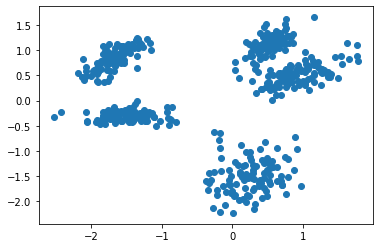

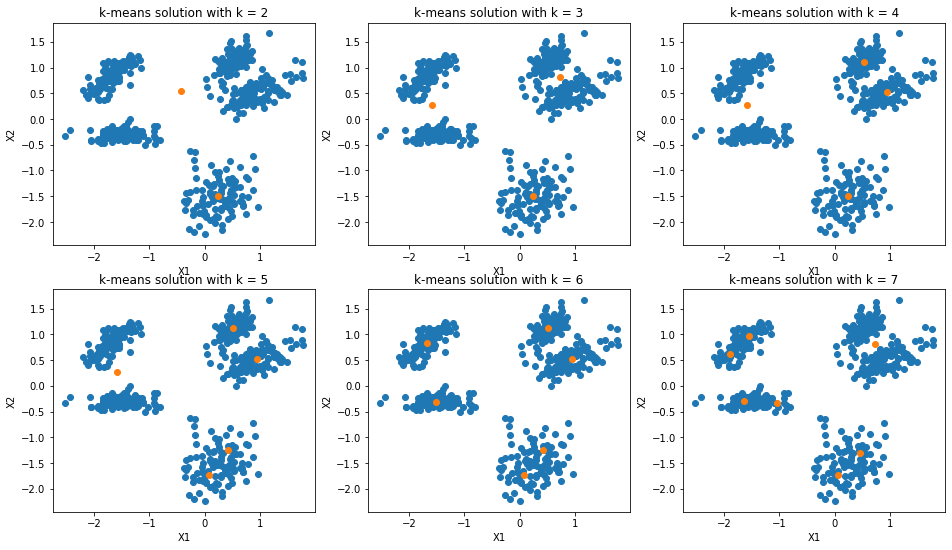

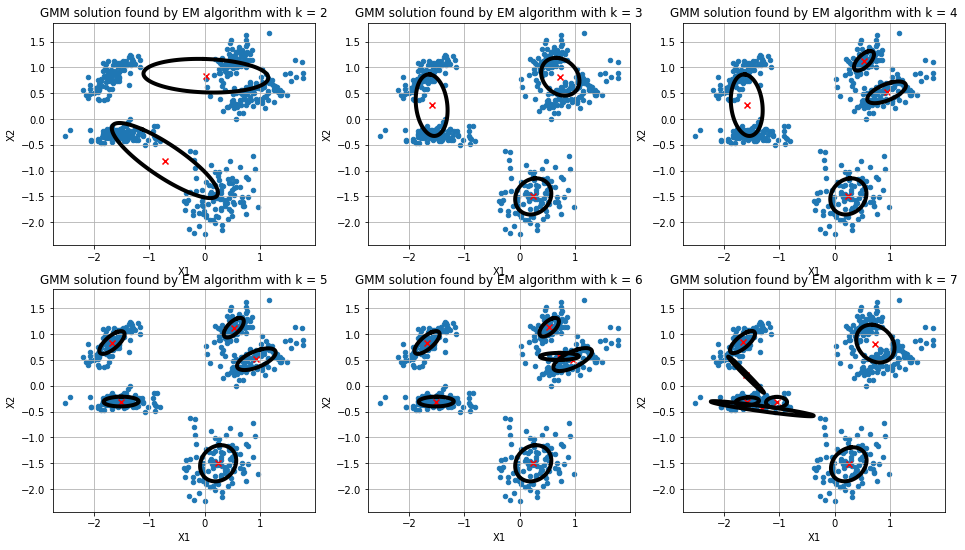

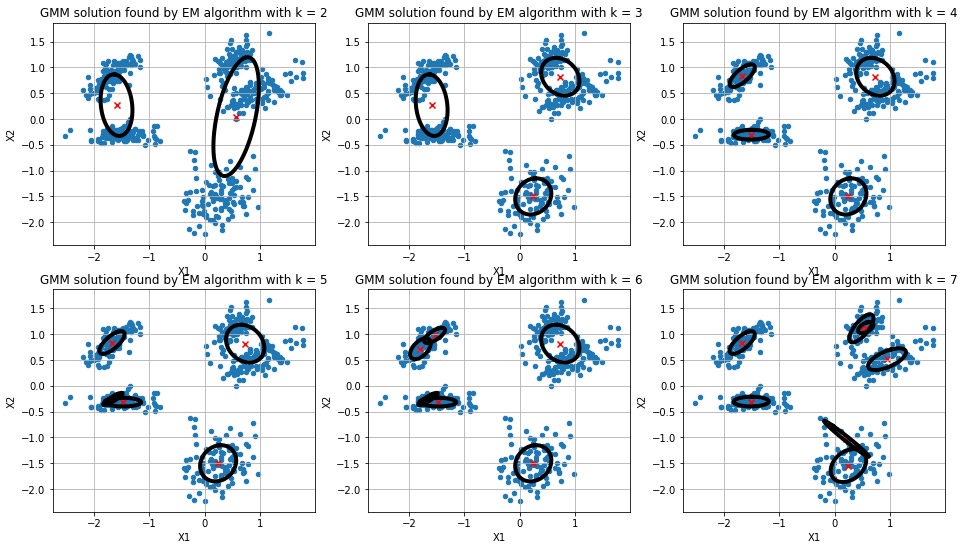

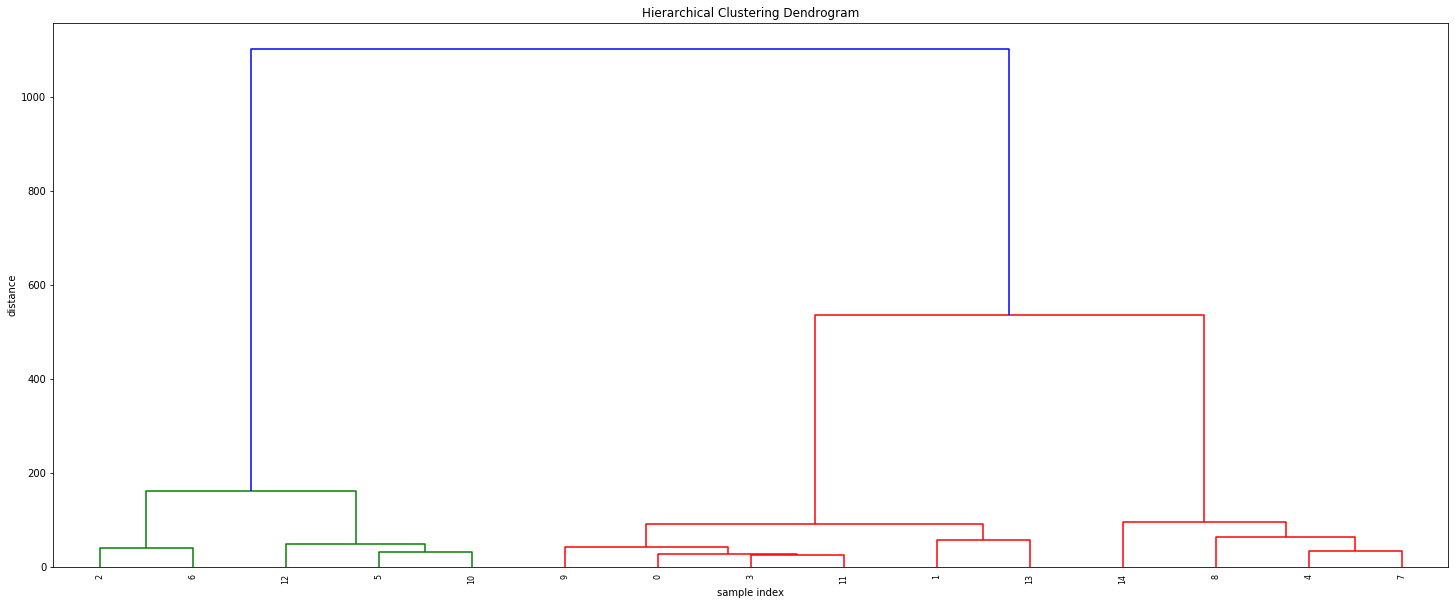

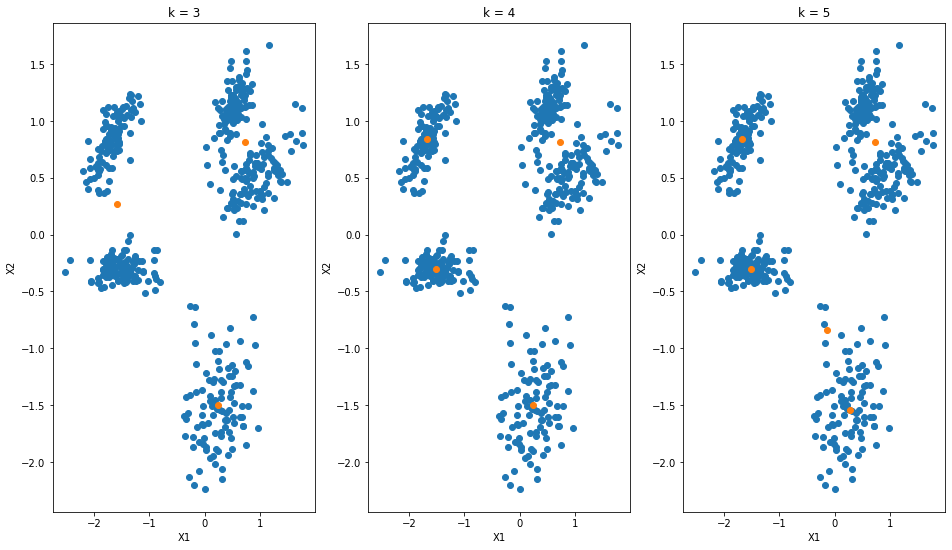

<Figure size 432x288 with 0 Axes>

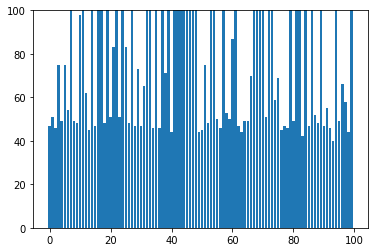

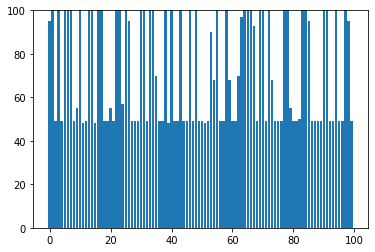

In [39]:
assignment_7()

In [49]:
def centroid_visualization(mu, title = 'plot'):
    """
    This function visualizes the centorids found in the usps data set, which contains images of size 16x16.
    The maximum number of centroids that can be visualized is 10.

    Inputs:
    mu = centroids of size 256x1
    title = title of the image
    
    Outputs:
    A figure containing 10 digits.
    """
    # results / Centroids Visualization of k-means 
    fig = plt.figure(figsize=(4, 9))
    plt.title(str(title))
    gs = fig.add_gridspec(5, 2)
    for i in range(len(mu)):
        f_ax1 = fig.add_subplot(gs[i%5,int(i>=5)])
        plt.imshow(mu[i].reshape(16,16), cmap = 'gray')
        

In [48]:
def assignment_9():
    # Load data
    cwd = os.getcwd()
    file_name = 'usps.mat'
    path_to_data = cwd + '/data/' + file_name
    assert os.path.exists(path_to_data), "The path to the data does not exist."
    data = sio.loadmat(path_to_data)
    data_labels = data['data_labels']
    usps_data = data['data_patterns'].T
    kn = 10
    
    # k-means on 5 usps data sets
    mu, r, loss = kmeans(X = usps_data, k = kn)
    print('Centroids: ' + str(mu))
    centroid_visualization(mu, title = 'k-means')
    
    # GMM on 5 gaussian data sets - without k-means initialization
    pi, mu, list_sigma, likelihoods = em_gmm(X = usps_data[:1000], k = kn, tol = 0.05, max_iter = 40)
    print('Centroids: ' + str(mu))
    centroid_visualization(mu, title = 'GMM')
    
    # GMM on 5 gaussian data sets - with k-means initialization
    pi, mu, list_sigma, likelihoods = em_gmm(X = usps_data[:1000], k = kn,init_kmeans = True, tol=0.05, max_iter = 10)
    print('Centroids: ' + str(mu))
    centroid_visualization(mu, title = 'GMM_km')
    
    # dendogram of hierarchical clustering with 20 starting clusters
    kn = 20
    # k-means on 5 usps data sets
    mu, r, loss = kmeans(X = usps_data, k = kn)
    # hierarchical clustering starting from kmean results
    R, kmloss, mergeidx = kmeans_agglo(usps_data,r)
    # plot dendrogram
    agglo_dendro(kmloss, mergeidx)
    
    # Visualization of the centroids found by the hierarchical agglomerative clustering for every iteration step
    # Merged clusters of the previous iteration is the last element of every column
    fig = plt.figure(figsize=(16, 16))
    gs = fig.add_gridspec(len(R)+1, len(R))
    for i, r in enumerate(R):
        # calculate init centroids
        w_q = np.array([np.sum(usps_data[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
        for j, mu in enumerate(w_q):
            f_ax1 = fig.add_subplot(gs[j,i])
            plt.imshow(mu.reshape(16,16), cmap = 'gray')
            if (i > 0 and j == 0):
                plt.title('iter: {}'.format(i))

Centroids: [[-0.97915441 -0.9286905  -0.8334309  ... -0.72640016 -0.82149636
  -0.92379286]
 [-0.99313106 -0.97927101 -0.95427723 ... -0.97663755 -0.99416223
  -0.99728805]
 [-0.98433323 -0.94859183 -0.87158174 ... -0.8068426  -0.92624094
  -0.98105268]
 ...
 [-0.99999984 -0.99999806 -0.9999037  ... -0.99833549 -0.99973676
  -0.99998599]
 [-0.99920424 -0.99501448 -0.97672239 ... -0.99750695 -0.99978717
  -0.99998271]
 [-0.97241001 -0.90489358 -0.77764079 ... -0.99480489 -0.99905316
  -0.99993817]]
Centroids: [[-0.97915441 -0.9286905  -0.8334309  ... -0.72640016 -0.82149636
  -0.92379286]
 [-0.99313106 -0.97927101 -0.95427723 ... -0.97663755 -0.99416223
  -0.99728805]
 [-0.98433323 -0.94859183 -0.87158174 ... -0.8068426  -0.92624094
  -0.98105268]
 ...
 [-0.99999984 -0.99999806 -0.9999037  ... -0.99833549 -0.99973676
  -0.99998599]
 [-0.99920424 -0.99501448 -0.97672239 ... -0.99750695 -0.99978717
  -0.99998271]
 [-0.97241001 -0.90489358 -0.77764079 ... -0.99480489 -0.99905316
  -0.99993

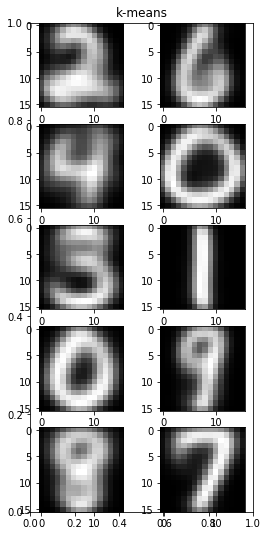

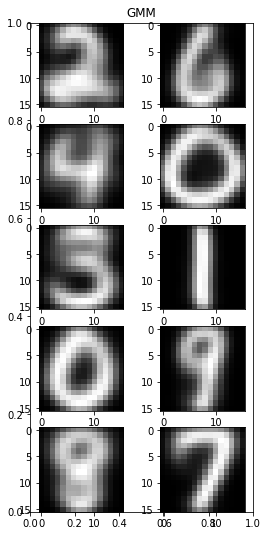

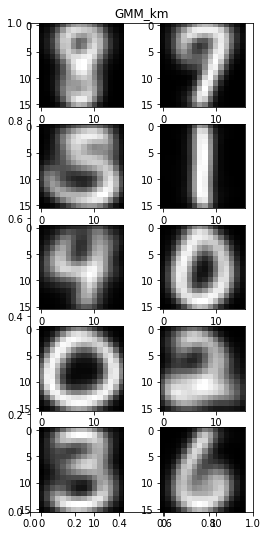

In [50]:
assignment_9()

In [5]:
true_mean = np.vstack((np.mean(gaussians[:100], axis = 0),np.mean(gaussians[100:200], axis = 0),np.mean(gaussians[200:300], axis = 0), np.mean(gaussians[300:400], axis = 0),np.mean(gaussians[400:], axis = 0)))

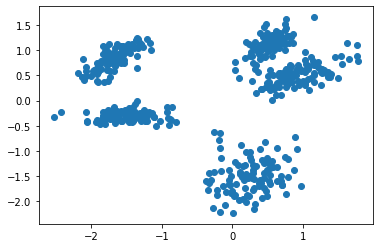

In [5]:
# Visualize data
plt.scatter(gaussians.T[0], gaussians.T[1])
#plt.scatter(true_mean.T[0], true_mean.T[1])

In [27]:
true_mean = np.vstack((np.mean(gaussians[:100], axis = 0),np.mean(gaussians[100:200], axis = 0),np.mean(gaussians[200:300], axis = 0), np.mean(gaussians[300:400], axis = 0),np.mean(gaussians[400:], axis = 0)))

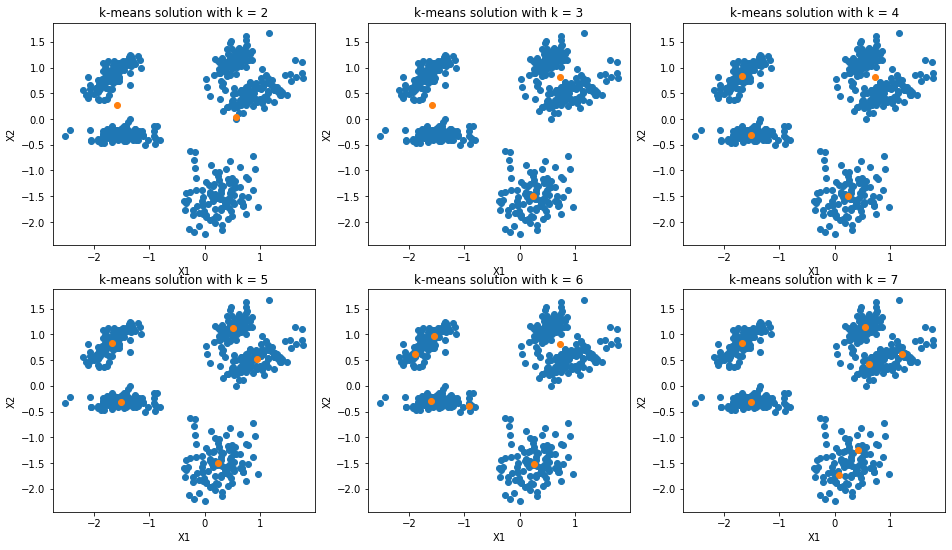

In [23]:
# k-means on 5 gaussian data sets
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 3)
for k in range(2,8):
    mu, r, loss = kmeans(X = gaussians, k = k)
    f_ax1 = fig.add_subplot(gs[int(k>=5), (k-2)%3])
    
    plt.title('k-means solution with k = {}'.format(len(mu)))
    plt.ylabel('X2')
    plt.xlabel('X1')
    plt.scatter(gaussians.T[0], gaussians.T[1])
    plt.scatter (mu.T[0], mu.T[1])


Iteration Number:
 1
Loglikelihood
 -1558.0959602366565
Iteration Number:
 2
Loglikelihood
 -1299.1294819876885
Iteration Number:
 3
Loglikelihood
 -1197.6253505046266
Iteration Number:
 4
Loglikelihood
 -1156.4891391544684
Iteration Number:
 5
Loglikelihood
 -1144.330849694626
Iteration Number:
 6
Loglikelihood
 -1144.0029884850464
Iteration Number:
 7
Loglikelihood
 -1144.0020628975562
Iteration Number:
 8
Loglikelihood
 -1144.0020601835986
Iteration Number:
 9
Loglikelihood
 -1144.002060178396
Iteration Number:
 10
Loglikelihood
 -1144.0020601786919
Iteration Number:
 11
Loglikelihood
 -1144.0020601787128
Iteration Number:
 12
Loglikelihood
 -1144.002060178714
Iteration Number:
 13
Loglikelihood
 -1144.002060178714
Iteration Number:
 1
Loglikelihood
 -1531.1682834212716
Iteration Number:
 2
Loglikelihood
 -1338.0470971376567
Iteration Number:
 3
Loglikelihood
 -1244.0346720812242
Iteration Number:
 4
Loglikelihood
 -1157.5795035366646
Iteration Number:
 5
Loglikelihood
 -1116.111097

Iteration Number:
 32
Loglikelihood
 -750.6552373910358
Iteration Number:
 33
Loglikelihood
 -750.3598735569146
Iteration Number:
 34
Loglikelihood
 -750.0638919061984
Iteration Number:
 35
Loglikelihood
 -749.7844932775702
Iteration Number:
 36
Loglikelihood
 -749.5340168883115
Iteration Number:
 37
Loglikelihood
 -749.3176029272406
Iteration Number:
 38
Loglikelihood
 -749.1351092102793
Iteration Number:
 39
Loglikelihood
 -748.9830669932701
Iteration Number:
 40
Loglikelihood
 -748.8559884141852
Iteration Number:
 41
Loglikelihood
 -748.7476003908273
Iteration Number:
 42
Loglikelihood
 -748.6518614817148
Iteration Number:
 43
Loglikelihood
 -748.5632388301749
Iteration Number:
 44
Loglikelihood
 -748.4759156907586
Iteration Number:
 45
Loglikelihood
 -748.3814825468905
Iteration Number:
 46
Loglikelihood
 -748.2637190914861
Iteration Number:
 47
Loglikelihood
 -748.0895336024676
Iteration Number:
 48
Loglikelihood
 -747.8174849434358
Iteration Number:
 49
Loglikelihood
 -747.495828

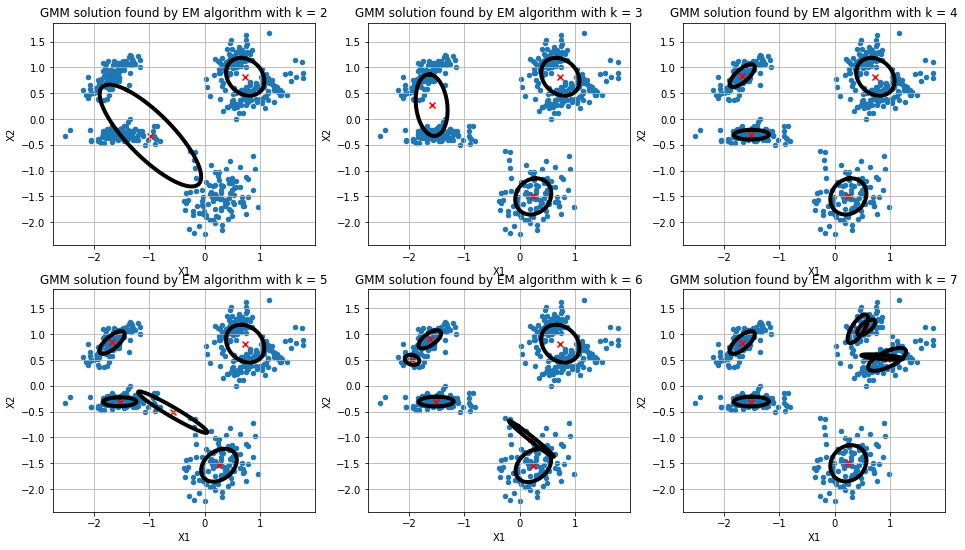

In [24]:
# GMM on 5 gaussian data sets - without k-means initialization
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 3)
for k in range(2,8):
    pi, mu, list_sigma, likelihoods = em_gmm(X = gaussians, k = k)
    f_ax1 = fig.add_subplot(gs[int(k>=5), (k-2)%3])
    plot_gmm_solution(X = gaussians ,mu = mu, sigma = list_sigma)
    #plt.plot(gaussians[:,0], gaussians[:,1], 'o')
    #plt.plot (mu.T[0], mu.T[1], 'o')

Iteration Number:
 1
Loglikelihood
 -1480.8023626795825
Iteration Number:
 2
Loglikelihood
 -1341.132439231928
Iteration Number:
 3
Loglikelihood
 -1190.2374160896975
Iteration Number:
 4
Loglikelihood
 -1144.2894108695377
Iteration Number:
 5
Loglikelihood
 -1144.0023661869475
Iteration Number:
 6
Loglikelihood
 -1144.0020609346857
Iteration Number:
 7
Loglikelihood
 -1144.0020601804686
Iteration Number:
 8
Loglikelihood
 -1144.0020601785814
Iteration Number:
 9
Loglikelihood
 -1144.0020601787041
Iteration Number:
 10
Loglikelihood
 -1144.0020601787135
Iteration Number:
 11
Loglikelihood
 -1144.002060178714
Iteration Number:
 12
Loglikelihood
 -1144.002060178714
Iteration Number:
 1
Loglikelihood
 -1460.8576824644904
Iteration Number:
 2
Loglikelihood
 -1212.0750502919368
Iteration Number:
 3
Loglikelihood
 -975.1328843692404
Iteration Number:
 4
Loglikelihood
 -954.2004310077741
Iteration Number:
 5
Loglikelihood
 -954.1984048847551
Iteration Number:
 6
Loglikelihood
 -954.1984043141

Loglikelihood
 -661.8160579355283
Iteration Number:
 43
Loglikelihood
 -661.7645195668484
Iteration Number:
 44
Loglikelihood
 -661.7199361467019
Iteration Number:
 45
Loglikelihood
 -661.6812932338942
Iteration Number:
 46
Loglikelihood
 -661.6477337501367
Iteration Number:
 47
Loglikelihood
 -661.6185334555635
Iteration Number:
 48
Loglikelihood
 -661.5930796486126
Iteration Number:
 49
Loglikelihood
 -661.570853061259
Iteration Number:
 50
Loglikelihood
 -661.5514126552587
Iteration Number:
 51
Loglikelihood
 -661.534382939385
Iteration Number:
 52
Loglikelihood
 -661.519443425618
Iteration Number:
 53
Loglikelihood
 -661.5063198752766
Iteration Number:
 54
Loglikelihood
 -661.4947770309216
Iteration Number:
 55
Loglikelihood
 -661.4846125758208
Iteration Number:
 56
Loglikelihood
 -661.4756521052213
Iteration Number:
 57
Loglikelihood
 -661.46774493091
Iteration Number:
 58
Loglikelihood
 -661.4607605722508
Iteration Number:
 59
Loglikelihood
 -661.4545858133893
Iteration Number:
 

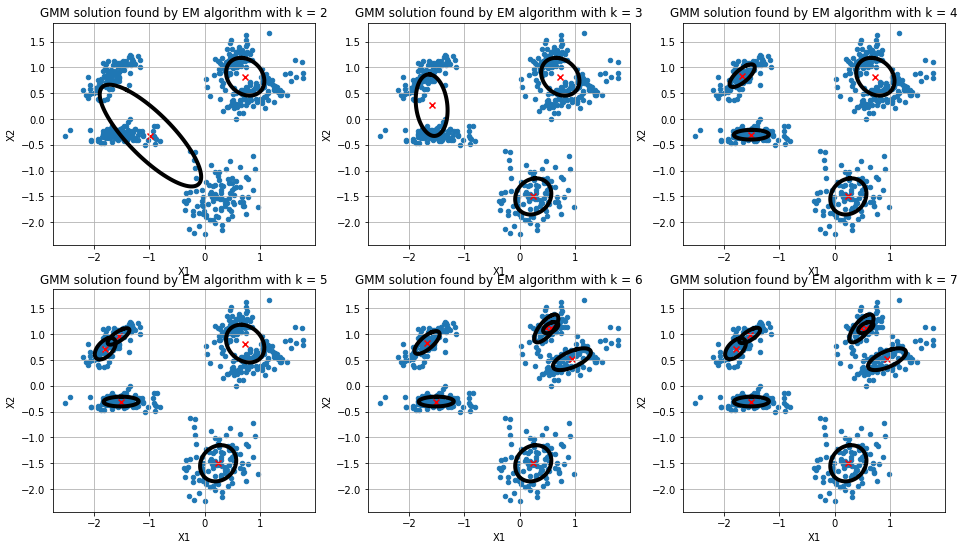

In [25]:
# GMM on 5 gaussian data sets - with k-means initialization
fig = plt.figure(figsize=(16, 9))
gs = fig.add_gridspec(2, 3)
for k in range(2,8):
    pi, mu, list_sigma, likelihoods = em_gmm(X = gaussians, k = k, init_kmeans = True)
    #f_ax1 = fig.add_subplot(1,int(k>=5)+1, (k-2)%3)
    fig.add_subplot(2, 3, k-1) 
    plot_gmm_solution(X = gaussians ,mu = mu, sigma = list_sigma)
    #plt.plot(gaussians[:,0], gaussians[:,1], 'o')
    #plt.plot (mu.T[0], mu.T[1], 'o')
# only 30 iterations instead of 100(max iter) -> kmeans is very helpful!
# in addition centroids for k = 5 is equal to human recognition of data
# ,whereas without kmeans it is depending on the initialization and more likely to fail!

[ 4  0  4  4  4  4  4  4  0  4  4  0  4  0  4  4  0  0  4  0  0  4  0  4
  0  4  4  4  4  0  4  4  0  4  0  4  4  4  0  4  4  0  0  4  0  0  4  4
  4  0  0  0  4  4  4  4  0  0  4  4  0  4  4  4  0  4  0  4  0  0  0  4
  0  4  4  0  0  0  0  4  0  0  4  4  4  0  4  4  4  4  0  0  0  0  0  4
  4  4  0  4  3  7 11  7  3  7  7  3  3  3  7 11  3  3  3  7  3  3  3  3
  3  7  7 11  3  3  3  3  3  3  7  7  3  3  3  3  7  3  7  7  7  3  7  3
  3  3  3 11  7  3  3  3  3 11  7  7  3  7  3  3  7  7 11  3  3  3  7  3
  3  7  3  3  3  3 11  3  7  3 11  7  7  3  3  7  7  7  3  3  3  3  3  3
 11  3 11  3  3  7  3  3  6 14 14 10 10  6 14 14 14  6 10 10 14 10 14  6
 14 14 10 14  6 14 10 10 14 14 10 14 14 14 10 14 14  6  6 10  6 10  6 10
  6 14 14 10 14 10 10 14  6 10 11  6 14 14 14 11 14 10 14  6  6 14 14 14
 10 14 10 14 10 14 10  6 14 10  6 14 14 10 14 11 10 14 14  6 14 10 10 10
 10 10  6 10  6 14 14 14 10  6 14  6  2 12  2  8  2 12  2  2  2  8  2  5
  2 12  5  2  2  8  2 12  2  8  2  5  2  8  8  2  8

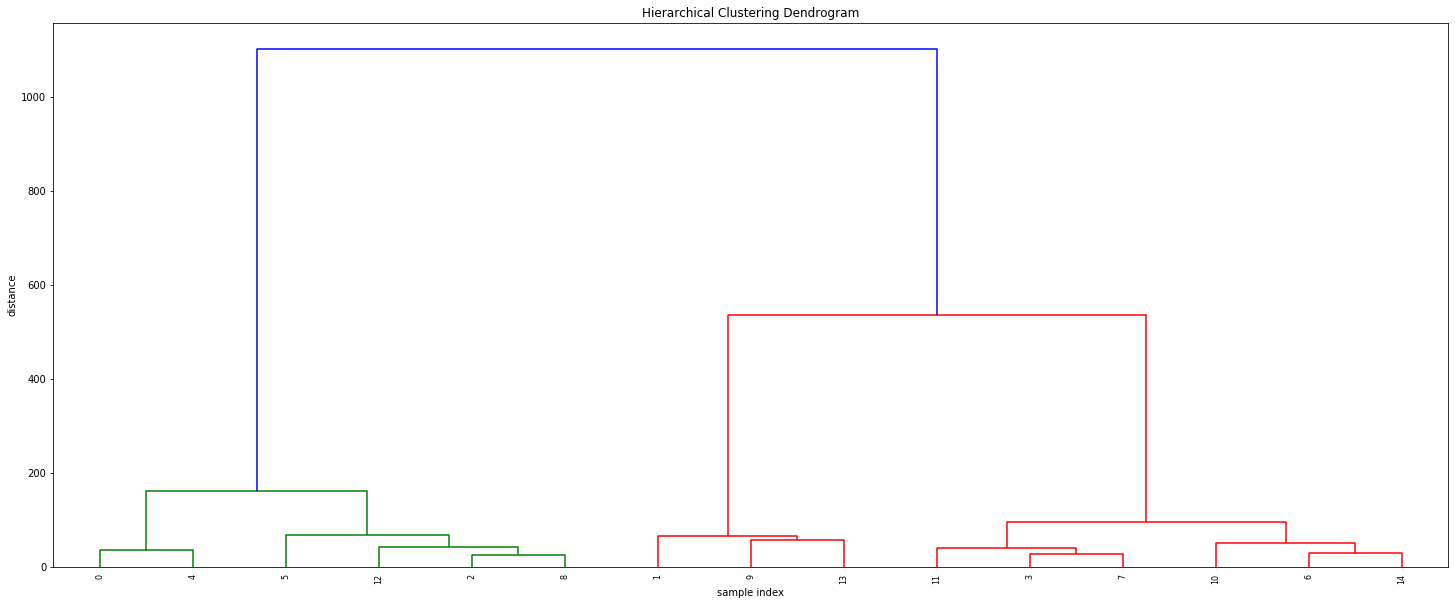

In [239]:
# dendogram
mu, r, loss =  kmeans(gaussians,15)
print(r)
R, kmloss, mergeidx = kmeans_agglo(gaussians,r)
print(mergeidx)
agglo_dendro(kmloss, mergeidx)
# dendogram would recommend k = 4
# plot below for  k = 5 shows it is dependend on initialization 
#-> outlier on the left lead to failure results of the dendogram (for k = 4 it disappears)

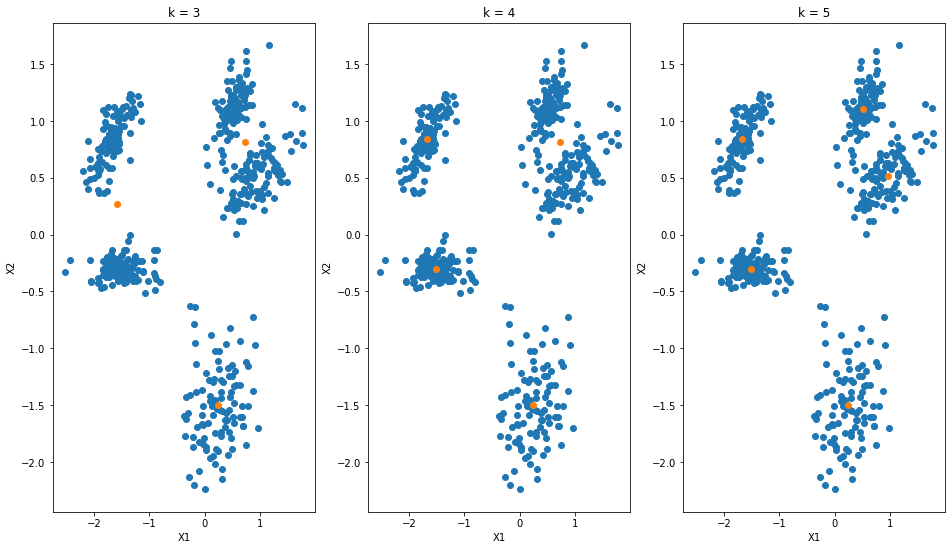

In [240]:
# visualization of k=5 centroids found by hierachical clustering
fig = plt.figure(figsize=(16, 9))
for i in [2,3,4]:
    r = R[-i]
    mu = np.array([np.sum(gaussians[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
    plt.subplot(1,3,i-1)
    plt.title('k = {}'.format(len(mu)))
    plt.ylabel('X2')
    plt.xlabel('X1')
    plt.scatter(gaussians.T[0], gaussians.T[1])
    plt.scatter (mu.T[0], mu.T[1])

In [6]:
true_mean = np.vstack((np.mean(gaussians[:100], axis = 0),np.mean(gaussians[100:200], axis = 0),np.mean(gaussians[200:300], axis = 0), np.mean(gaussians[300:400], axis = 0),np.mean(gaussians[400:], axis = 0)))

In [20]:
CCR(true_mean, function = 'k-means')

k-means is used
CCR is: 0.71


0.71

Iteration Number:
 1
Loglikelihood
 -1565.3816046608845
Iteration Number:
 2
Loglikelihood
 -1330.1222312648877
Iteration Number:
 3
Loglikelihood
 -1217.147191753491
Iteration Number:
 4
Loglikelihood
 -1093.7996485911901
Iteration Number:
 5
Loglikelihood
 -1041.8802713980713
Iteration Number:
 6
Loglikelihood
 -1021.5823121638152
Iteration Number:
 7
Loglikelihood
 -1005.0409580985682
Iteration Number:
 8
Loglikelihood
 -981.4830999491802
Iteration Number:
 9
Loglikelihood
 -953.784397544933
Iteration Number:
 10
Loglikelihood
 -941.4800515775646
Iteration Number:
 11
Loglikelihood
 -938.0031723223766
Iteration Number:
 12
Loglikelihood
 -935.1601875195527
Iteration Number:
 13
Loglikelihood
 -932.8121216923764
Iteration Number:
 14
Loglikelihood
 -930.8142006178092
Iteration Number:
 15
Loglikelihood
 -928.9014989419023
Iteration Number:
 16
Loglikelihood
 -926.7571218870709
Iteration Number:
 17
Loglikelihood
 -923.8387412957857
Iteration Number:
 18
Loglikelihood
 -918.8518778121

Loglikelihood
 -856.3233232460015
Iteration Number:
 46
Loglikelihood
 -856.3176361006228
Iteration Number:
 47
Loglikelihood
 -856.3126013530663
Iteration Number:
 48
Loglikelihood
 -856.3081407630771
Iteration Number:
 49
Loglikelihood
 -856.3041860077348
Iteration Number:
 50
Loglikelihood
 -856.3006773316944
Iteration Number:
 51
Loglikelihood
 -856.29756239775
Iteration Number:
 52
Loglikelihood
 -856.2947953049933
Iteration Number:
 53
Loglikelihood
 -856.292335747735
Iteration Number:
 54
Loglikelihood
 -856.2901482930833
Iteration Number:
 55
Loglikelihood
 -856.2882017588822
Iteration Number:
 56
Loglikelihood
 -856.2864686768165
Iteration Number:
 57
Loglikelihood
 -856.2849248279983
Iteration Number:
 58
Loglikelihood
 -856.2835488404294
Iteration Number:
 59
Loglikelihood
 -856.2823218394204
Iteration Number:
 60
Loglikelihood
 -856.2812271434585
Iteration Number:
 61
Loglikelihood
 -856.280249999171
Iteration Number:
 62
Loglikelihood
 -856.2793773499986
Iteration Number:


Loglikelihood
 -719.1542147119719
Iteration Number:
 42
Loglikelihood
 -716.5497490744033
Iteration Number:
 43
Loglikelihood
 -713.6695788959398
Iteration Number:
 44
Loglikelihood
 -710.451412098568
Iteration Number:
 45
Loglikelihood
 -706.6847590391392
Iteration Number:
 46
Loglikelihood
 -701.8357581010389
Iteration Number:
 47
Loglikelihood
 -694.8211205658085
Iteration Number:
 48
Loglikelihood
 -684.2268340025171
Iteration Number:
 49
Loglikelihood
 -672.2692337101953
Iteration Number:
 50
Loglikelihood
 -667.5565360880232
Iteration Number:
 51
Loglikelihood
 -666.8750879592224
Iteration Number:
 52
Loglikelihood
 -666.7363019739671
Iteration Number:
 53
Loglikelihood
 -666.7079467163232
Iteration Number:
 54
Loglikelihood
 -666.7025060434075
Iteration Number:
 55
Loglikelihood
 -666.7014855320142
Iteration Number:
 56
Loglikelihood
 -666.7012946057976
Iteration Number:
 57
Loglikelihood
 -666.7012584404765
Iteration Number:
 58
Loglikelihood
 -666.7012513535302
Iteration Numbe

Iteration Number:
 7
Loglikelihood
 -944.3342613512677
Iteration Number:
 8
Loglikelihood
 -941.2839051063281
Iteration Number:
 9
Loglikelihood
 -938.2236519687234
Iteration Number:
 10
Loglikelihood
 -935.0582674721439
Iteration Number:
 11
Loglikelihood
 -931.7158105726116
Iteration Number:
 12
Loglikelihood
 -927.6652936877366
Iteration Number:
 13
Loglikelihood
 -920.9796078427802
Iteration Number:
 14
Loglikelihood
 -910.2102428201622
Iteration Number:
 15
Loglikelihood
 -898.5518325082096
Iteration Number:
 16
Loglikelihood
 -885.0490581203752
Iteration Number:
 17
Loglikelihood
 -870.3576936824047
Iteration Number:
 18
Loglikelihood
 -864.9776207094168
Iteration Number:
 19
Loglikelihood
 -863.7891258089944
Iteration Number:
 20
Loglikelihood
 -863.227892824375
Iteration Number:
 21
Loglikelihood
 -862.809905016582
Iteration Number:
 22
Loglikelihood
 -862.4531804326558
Iteration Number:
 23
Loglikelihood
 -862.1332091017989
Iteration Number:
 24
Loglikelihood
 -861.83590073905

Loglikelihood
 -741.7562708063406
Iteration Number:
 32
Loglikelihood
 -739.2151331948598
Iteration Number:
 33
Loglikelihood
 -734.8382584589849
Iteration Number:
 34
Loglikelihood
 -725.614253413213
Iteration Number:
 35
Loglikelihood
 -707.2856066135226
Iteration Number:
 36
Loglikelihood
 -693.2347166390362
Iteration Number:
 37
Loglikelihood
 -685.6533432353826
Iteration Number:
 38
Loglikelihood
 -677.0255034933298
Iteration Number:
 39
Loglikelihood
 -670.2320069689367
Iteration Number:
 40
Loglikelihood
 -667.6546476443384
Iteration Number:
 41
Loglikelihood
 -666.89558741204
Iteration Number:
 42
Loglikelihood
 -666.736060901697
Iteration Number:
 43
Loglikelihood
 -666.7074692499029
Iteration Number:
 44
Loglikelihood
 -666.7023680009943
Iteration Number:
 45
Loglikelihood
 -666.7014495132357
Iteration Number:
 46
Loglikelihood
 -666.7012842768361
Iteration Number:
 47
Loglikelihood
 -666.7012550193508
Iteration Number:
 48
Loglikelihood
 -666.7012500774899
Iteration Number:


Loglikelihood
 -762.9708229428604
Iteration Number:
 22
Loglikelihood
 -761.2764131674464
Iteration Number:
 23
Loglikelihood
 -760.4855523260804
Iteration Number:
 24
Loglikelihood
 -760.0787750473363
Iteration Number:
 25
Loglikelihood
 -759.8411597369522
Iteration Number:
 26
Loglikelihood
 -759.6739791305511
Iteration Number:
 27
Loglikelihood
 -759.5224214896626
Iteration Number:
 28
Loglikelihood
 -759.3369595447618
Iteration Number:
 29
Loglikelihood
 -759.0510420760446
Iteration Number:
 30
Loglikelihood
 -758.6466094468567
Iteration Number:
 31
Loglikelihood
 -758.3294966352078
Iteration Number:
 32
Loglikelihood
 -758.1612782029952
Iteration Number:
 33
Loglikelihood
 -758.0407165231588
Iteration Number:
 34
Loglikelihood
 -757.9375520652027
Iteration Number:
 35
Loglikelihood
 -757.842491066606
Iteration Number:
 36
Loglikelihood
 -757.7502537171108
Iteration Number:
 37
Loglikelihood
 -757.6556894791399
Iteration Number:
 38
Loglikelihood
 -757.5526479925438
Iteration Numbe

Iteration Number:
 6
Loglikelihood
 -1015.9554742326155
Iteration Number:
 7
Loglikelihood
 -1008.2201268299805
Iteration Number:
 8
Loglikelihood
 -999.2842329898901
Iteration Number:
 9
Loglikelihood
 -985.3510493346453
Iteration Number:
 10
Loglikelihood
 -963.0699752827547
Iteration Number:
 11
Loglikelihood
 -948.3912449533061
Iteration Number:
 12
Loglikelihood
 -938.8912299397507
Iteration Number:
 13
Loglikelihood
 -925.5487000050524
Iteration Number:
 14
Loglikelihood
 -899.1818849407745
Iteration Number:
 15
Loglikelihood
 -831.8038818269496
Iteration Number:
 16
Loglikelihood
 -759.9163805823539
Iteration Number:
 17
Loglikelihood
 -758.6776616829156
Iteration Number:
 18
Loglikelihood
 -758.2867129650152
Iteration Number:
 19
Loglikelihood
 -757.8774119918545
Iteration Number:
 20
Loglikelihood
 -757.3803576351299
Iteration Number:
 21
Loglikelihood
 -756.6630875358023
Iteration Number:
 22
Loglikelihood
 -755.5289960615327
Iteration Number:
 23
Loglikelihood
 -754.28913196

Iteration Number:
 56
Loglikelihood
 -751.2166555299082
Iteration Number:
 57
Loglikelihood
 -751.2076541911738
Iteration Number:
 58
Loglikelihood
 -751.2050251807774
Iteration Number:
 59
Loglikelihood
 -751.204217886278
Iteration Number:
 60
Loglikelihood
 -751.2039455618897
Iteration Number:
 61
Loglikelihood
 -751.2038430040858
Iteration Number:
 62
Loglikelihood
 -751.2038001878605
Iteration Number:
 63
Loglikelihood
 -751.2037807824534
Iteration Number:
 64
Loglikelihood
 -751.2037714520519
Iteration Number:
 65
Loglikelihood
 -751.2037667799044
Iteration Number:
 66
Loglikelihood
 -751.2037643740966
Iteration Number:
 67
Loglikelihood
 -751.2037631105327
Iteration Number:
 68
Loglikelihood
 -751.20376243711
Iteration Number:
 69
Loglikelihood
 -751.203762074128
Iteration Number:
 70
Loglikelihood
 -751.2037618766974
Iteration Number:
 71
Loglikelihood
 -751.2037617685089
Iteration Number:
 72
Loglikelihood
 -751.2037617088516
Iteration Number:
 73
Loglikelihood
 -751.2037616757

Loglikelihood
 -756.7358667583976
Iteration Number:
 79
Loglikelihood
 -756.7105406387186
Iteration Number:
 80
Loglikelihood
 -756.6847578833265
Iteration Number:
 81
Loglikelihood
 -756.6585114692134
Iteration Number:
 82
Loglikelihood
 -756.6317928029913
Iteration Number:
 83
Loglikelihood
 -756.6045914198003
Iteration Number:
 84
Loglikelihood
 -756.5768946918981
Iteration Number:
 85
Loglikelihood
 -756.5486875472081
Iteration Number:
 86
Loglikelihood
 -756.5199521952967
Iteration Number:
 87
Loglikelihood
 -756.4906678553755
Iteration Number:
 88
Loglikelihood
 -756.4608104781553
Iteration Number:
 89
Loglikelihood
 -756.4303524508525
Iteration Number:
 90
Loglikelihood
 -756.3992622724836
Iteration Number:
 91
Loglikelihood
 -756.3675041847772
Iteration Number:
 92
Loglikelihood
 -756.3350377426154
Iteration Number:
 93
Loglikelihood
 -756.3018173068067
Iteration Number:
 94
Loglikelihood
 -756.2677914411516
Iteration Number:
 95
Loglikelihood
 -756.2329021951275
Iteration Numb

Iteration Number:
 35
Loglikelihood
 -861.0372963877384
Iteration Number:
 36
Loglikelihood
 -860.6555046385548
Iteration Number:
 37
Loglikelihood
 -860.2086461354502
Iteration Number:
 38
Loglikelihood
 -859.7216561973302
Iteration Number:
 39
Loglikelihood
 -859.258606106201
Iteration Number:
 40
Loglikelihood
 -858.9160482945579
Iteration Number:
 41
Loglikelihood
 -858.6765237857203
Iteration Number:
 42
Loglikelihood
 -858.4775345149749
Iteration Number:
 43
Loglikelihood
 -858.2877952156865
Iteration Number:
 44
Loglikelihood
 -858.0972716936842
Iteration Number:
 45
Loglikelihood
 -857.9058001285689
Iteration Number:
 46
Loglikelihood
 -857.7181626534605
Iteration Number:
 47
Loglikelihood
 -857.5406495564687
Iteration Number:
 48
Loglikelihood
 -857.3783234652245
Iteration Number:
 49
Loglikelihood
 -857.2337382080835
Iteration Number:
 50
Loglikelihood
 -857.1071444733469
Iteration Number:
 51
Loglikelihood
 -856.9973658040208
Iteration Number:
 52
Loglikelihood
 -856.9026066

Loglikelihood
 -751.9077595735281
Iteration Number:
 52
Loglikelihood
 -751.9076524172597
Iteration Number:
 53
Loglikelihood
 -751.9075686979024
Iteration Number:
 54
Loglikelihood
 -751.9075033720194
Iteration Number:
 55
Loglikelihood
 -751.907452476737
Iteration Number:
 56
Loglikelihood
 -751.9074128975969
Iteration Number:
 57
Loglikelihood
 -751.9073821866787
Iteration Number:
 58
Loglikelihood
 -751.9073584199714
Iteration Number:
 59
Loglikelihood
 -751.9073400854323
Iteration Number:
 60
Loglikelihood
 -751.9073259950616
Iteration Number:
 61
Loglikelihood
 -751.9073152157973
Iteration Number:
 62
Loglikelihood
 -751.9073070151712
Iteration Number:
 63
Loglikelihood
 -751.9073008185544
Iteration Number:
 64
Loglikelihood
 -751.9072961755047
Iteration Number:
 65
Loglikelihood
 -751.9072927332732
Iteration Number:
 66
Loglikelihood
 -751.9072902159417
Iteration Number:
 67
Loglikelihood
 -751.9072884079915
Iteration Number:
 68
Loglikelihood
 -751.9072871413614
Iteration Numbe

Iteration Number:
 15
Loglikelihood
 -762.700424648827
Iteration Number:
 16
Loglikelihood
 -720.6369737488453
Iteration Number:
 17
Loglikelihood
 -706.570368577593
Iteration Number:
 18
Loglikelihood
 -700.7877985084654
Iteration Number:
 19
Loglikelihood
 -692.9582210366448
Iteration Number:
 20
Loglikelihood
 -681.6510350317062
Iteration Number:
 21
Loglikelihood
 -670.5770914204535
Iteration Number:
 22
Loglikelihood
 -667.2929851240061
Iteration Number:
 23
Loglikelihood
 -666.8238890651519
Iteration Number:
 24
Loglikelihood
 -666.7255907368024
Iteration Number:
 25
Loglikelihood
 -666.705870564517
Iteration Number:
 26
Loglikelihood
 -666.7021155571298
Iteration Number:
 27
Loglikelihood
 -666.701412564601
Iteration Number:
 28
Loglikelihood
 -666.7012808604927
Iteration Number:
 29
Loglikelihood
 -666.7012557816234
Iteration Number:
 30
Loglikelihood
 -666.7012508083341
Iteration Number:
 31
Loglikelihood
 -666.7012497381269
Iteration Number:
 32
Loglikelihood
 -666.7012494743

Iteration Number:
 66
Loglikelihood
 -756.5574799519002
Iteration Number:
 67
Loglikelihood
 -756.5537367816747
Iteration Number:
 68
Loglikelihood
 -756.5498954707296
Iteration Number:
 69
Loglikelihood
 -756.5459347519416
Iteration Number:
 70
Loglikelihood
 -756.5418318049493
Iteration Number:
 71
Loglikelihood
 -756.5375619778911
Iteration Number:
 72
Loglikelihood
 -756.5330984914871
Iteration Number:
 73
Loglikelihood
 -756.528412126243
Iteration Number:
 74
Loglikelihood
 -756.5234708954606
Iteration Number:
 75
Loglikelihood
 -756.518239709447
Iteration Number:
 76
Loglikelihood
 -756.5126800400294
Iteration Number:
 77
Loglikelihood
 -756.5067495995163
Iteration Number:
 78
Loglikelihood
 -756.5004020548799
Iteration Number:
 79
Loglikelihood
 -756.4935868064891
Iteration Number:
 80
Loglikelihood
 -756.4862488713856
Iteration Number:
 81
Loglikelihood
 -756.4783289239592
Iteration Number:
 82
Loglikelihood
 -756.4697635615382
Iteration Number:
 83
Loglikelihood
 -756.46048587

Loglikelihood
 -940.6349287354202
Iteration Number:
 6
Loglikelihood
 -932.2322557282314
Iteration Number:
 7
Loglikelihood
 -917.3910979744129
Iteration Number:
 8
Loglikelihood
 -887.3966589132721
Iteration Number:
 9
Loglikelihood
 -818.3378335429873
Iteration Number:
 10
Loglikelihood
 -753.5743476024145
Iteration Number:
 11
Loglikelihood
 -739.1498615902727
Iteration Number:
 12
Loglikelihood
 -733.7107311310815
Iteration Number:
 13
Loglikelihood
 -725.5113629061583
Iteration Number:
 14
Loglikelihood
 -712.1704961530309
Iteration Number:
 15
Loglikelihood
 -696.3121514586744
Iteration Number:
 16
Loglikelihood
 -680.8906992384643
Iteration Number:
 17
Loglikelihood
 -669.5747167910647
Iteration Number:
 18
Loglikelihood
 -667.0958569568124
Iteration Number:
 19
Loglikelihood
 -666.7814448672194
Iteration Number:
 20
Loglikelihood
 -666.7169026903002
Iteration Number:
 21
Loglikelihood
 -666.7042042572241
Iteration Number:
 22
Loglikelihood
 -666.7018031195496
Iteration Number:


Iteration Number:
 73
Loglikelihood
 -858.4483034464927
Iteration Number:
 74
Loglikelihood
 -858.444951253007
Iteration Number:
 75
Loglikelihood
 -858.4415895048387
Iteration Number:
 76
Loglikelihood
 -858.4381908869748
Iteration Number:
 77
Loglikelihood
 -858.4347272387569
Iteration Number:
 78
Loglikelihood
 -858.4311691637766
Iteration Number:
 79
Loglikelihood
 -858.4274856526595
Iteration Number:
 80
Loglikelihood
 -858.4236437240993
Iteration Number:
 81
Loglikelihood
 -858.4196080931365
Iteration Number:
 82
Loglikelihood
 -858.4153408789109
Iteration Number:
 83
Loglikelihood
 -858.410801366013
Iteration Number:
 84
Loglikelihood
 -858.4059458324775
Iteration Number:
 85
Loglikelihood
 -858.4007274508186
Iteration Number:
 86
Loglikelihood
 -858.3950962526544
Iteration Number:
 87
Loglikelihood
 -858.3889991175006
Iteration Number:
 88
Loglikelihood
 -858.3823796963158
Iteration Number:
 89
Loglikelihood
 -858.3751781036249
Iteration Number:
 90
Loglikelihood
 -858.36733010

Loglikelihood
 -725.8563809101828
Iteration Number:
 22
Loglikelihood
 -722.9290587751495
Iteration Number:
 23
Loglikelihood
 -720.3012626356992
Iteration Number:
 24
Loglikelihood
 -717.6259481717209
Iteration Number:
 25
Loglikelihood
 -714.7580409747604
Iteration Number:
 26
Loglikelihood
 -711.618727591994
Iteration Number:
 27
Loglikelihood
 -708.0496858773535
Iteration Number:
 28
Loglikelihood
 -703.6431515635832
Iteration Number:
 29
Loglikelihood
 -697.5185926382628
Iteration Number:
 30
Loglikelihood
 -688.2392144449067
Iteration Number:
 31
Loglikelihood
 -675.8842157347335
Iteration Number:
 32
Loglikelihood
 -668.2949781326054
Iteration Number:
 33
Loglikelihood
 -666.9947821794264
Iteration Number:
 34
Loglikelihood
 -666.761879963854
Iteration Number:
 35
Loglikelihood
 -666.7129881264437
Iteration Number:
 36
Loglikelihood
 -666.7034594389345
Iteration Number:
 37
Loglikelihood
 -666.7016637434954
Iteration Number:
 38
Loglikelihood
 -666.7013280486275
Iteration Number

Loglikelihood
 -756.8629085873572
Iteration Number:
 52
Loglikelihood
 -756.8601194612711
Iteration Number:
 53
Loglikelihood
 -756.8571466931817
Iteration Number:
 54
Loglikelihood
 -756.8539602868389
Iteration Number:
 55
Loglikelihood
 -756.8505251329609
Iteration Number:
 56
Loglikelihood
 -756.8467993000036
Iteration Number:
 57
Loglikelihood
 -756.842731715424
Iteration Number:
 58
Loglikelihood
 -756.8382589169493
Iteration Number:
 59
Loglikelihood
 -756.833300359464
Iteration Number:
 60
Loglikelihood
 -756.8277514246545
Iteration Number:
 61
Loglikelihood
 -756.8214726717376
Iteration Number:
 62
Loglikelihood
 -756.8142727354436
Iteration Number:
 63
Loglikelihood
 -756.8058800945789
Iteration Number:
 64
Loglikelihood
 -756.7958945608076
Iteration Number:
 65
Loglikelihood
 -756.7837002191291
Iteration Number:
 66
Loglikelihood
 -756.7683017969928
Iteration Number:
 67
Loglikelihood
 -756.7480022699995
Iteration Number:
 68
Loglikelihood
 -756.7197397275964
Iteration Number

Loglikelihood
 -995.3105343084196
Iteration Number:
 5
Loglikelihood
 -952.6303494854996
Iteration Number:
 6
Loglikelihood
 -942.7704272208834
Iteration Number:
 7
Loglikelihood
 -936.1186475370978
Iteration Number:
 8
Loglikelihood
 -929.2381767409429
Iteration Number:
 9
Loglikelihood
 -919.5072575635866
Iteration Number:
 10
Loglikelihood
 -902.8346498953342
Iteration Number:
 11
Loglikelihood
 -868.8413978114183
Iteration Number:
 12
Loglikelihood
 -801.5151483502175
Iteration Number:
 13
Loglikelihood
 -745.8998917322147
Iteration Number:
 14
Loglikelihood
 -698.0681177937763
Iteration Number:
 15
Loglikelihood
 -684.3841275745588
Iteration Number:
 16
Loglikelihood
 -672.2832727420339
Iteration Number:
 17
Loglikelihood
 -667.5206928312866
Iteration Number:
 18
Loglikelihood
 -666.8654980693343
Iteration Number:
 19
Loglikelihood
 -666.734259082189
Iteration Number:
 20
Loglikelihood
 -666.7075488779673
Iteration Number:
 21
Loglikelihood
 -666.702431112454
Iteration Number:
 22

Iteration Number:
 82
Loglikelihood
 -754.5760999451932
Iteration Number:
 83
Loglikelihood
 -754.5745504119518
Iteration Number:
 84
Loglikelihood
 -754.5732889827981
Iteration Number:
 85
Loglikelihood
 -754.5722604416771
Iteration Number:
 86
Loglikelihood
 -754.5714205269389
Iteration Number:
 87
Loglikelihood
 -754.5707336723951
Iteration Number:
 88
Loglikelihood
 -754.5701712337768
Iteration Number:
 89
Loglikelihood
 -754.5697100918342
Iteration Number:
 90
Loglikelihood
 -754.5693315487765
Iteration Number:
 91
Loglikelihood
 -754.5690204539046
Iteration Number:
 92
Loglikelihood
 -754.5687645088576
Iteration Number:
 93
Loglikelihood
 -754.5685537140375
Iteration Number:
 94
Loglikelihood
 -754.5683799263501
Iteration Number:
 95
Loglikelihood
 -754.5682365049678
Iteration Number:
 96
Loglikelihood
 -754.5681180269091
Iteration Number:
 97
Loglikelihood
 -754.5680200581492
Iteration Number:
 98
Loglikelihood
 -754.5679389690245
Iteration Number:
 99
Loglikelihood
 -754.567871

Loglikelihood
 -1031.553108177726
Iteration Number:
 7
Loglikelihood
 -1013.7572612339484
Iteration Number:
 8
Loglikelihood
 -1009.1668493423881
Iteration Number:
 9
Loglikelihood
 -1005.6810094187479
Iteration Number:
 10
Loglikelihood
 -997.695830779981
Iteration Number:
 11
Loglikelihood
 -976.5656876287397
Iteration Number:
 12
Loglikelihood
 -956.7214676644869
Iteration Number:
 13
Loglikelihood
 -947.4112600491021
Iteration Number:
 14
Loglikelihood
 -941.6994998407333
Iteration Number:
 15
Loglikelihood
 -935.6275980792085
Iteration Number:
 16
Loglikelihood
 -926.1920009648335
Iteration Number:
 17
Loglikelihood
 -907.9018389368894
Iteration Number:
 18
Loglikelihood
 -874.180037997729
Iteration Number:
 19
Loglikelihood
 -836.3503566647605
Iteration Number:
 20
Loglikelihood
 -801.9720412586744
Iteration Number:
 21
Loglikelihood
 -760.4937658121146
Iteration Number:
 22
Loglikelihood
 -753.2338073099332
Iteration Number:
 23
Loglikelihood
 -752.5649646860919
Iteration Number

Iteration Number:
 83
Loglikelihood
 -756.2636903402627
Iteration Number:
 84
Loglikelihood
 -756.2415707783746
Iteration Number:
 85
Loglikelihood
 -756.2190446299276
Iteration Number:
 86
Loglikelihood
 -756.1963229099831
Iteration Number:
 87
Loglikelihood
 -756.1736189405918
Iteration Number:
 88
Loglikelihood
 -756.1511357948534
Iteration Number:
 89
Loglikelihood
 -756.129054917273
Iteration Number:
 90
Loglikelihood
 -756.1075273684089
Iteration Number:
 91
Loglikelihood
 -756.0866686188918
Iteration Number:
 92
Loglikelihood
 -756.0665571244801
Iteration Number:
 93
Loglikelihood
 -756.0472362511364
Iteration Number:
 94
Loglikelihood
 -756.0287186557578
Iteration Number:
 95
Loglikelihood
 -756.0109920427258
Iteration Number:
 96
Loglikelihood
 -755.9940252876586
Iteration Number:
 97
Loglikelihood
 -755.9777741590492
Iteration Number:
 98
Loglikelihood
 -755.9621861688885
Iteration Number:
 99
Loglikelihood
 -755.9472043590995
Iteration Number:
 100
Loglikelihood
 -755.932770

Iteration Number:
 16
Loglikelihood
 -827.4275702452937
Iteration Number:
 17
Loglikelihood
 -772.3374486705084
Iteration Number:
 18
Loglikelihood
 -735.143444537142
Iteration Number:
 19
Loglikelihood
 -726.6105872181195
Iteration Number:
 20
Loglikelihood
 -720.4497688439958
Iteration Number:
 21
Loglikelihood
 -714.7850916921664
Iteration Number:
 22
Loglikelihood
 -709.3933273417514
Iteration Number:
 23
Loglikelihood
 -703.8374249131268
Iteration Number:
 24
Loglikelihood
 -697.0738152997199
Iteration Number:
 25
Loglikelihood
 -687.4519386541751
Iteration Number:
 26
Loglikelihood
 -675.1043604463357
Iteration Number:
 27
Loglikelihood
 -668.0762705035478
Iteration Number:
 28
Loglikelihood
 -666.9573145831109
Iteration Number:
 29
Loglikelihood
 -666.753775601127
Iteration Number:
 30
Loglikelihood
 -666.7113787418759
Iteration Number:
 31
Loglikelihood
 -666.7031543162773
Iteration Number:
 32
Loglikelihood
 -666.7016066887024
Iteration Number:
 33
Loglikelihood
 -666.70131735

Loglikelihood
 -666.701250224977
Iteration Number:
 30
Loglikelihood
 -666.7012495993263
Iteration Number:
 31
Loglikelihood
 -666.7012494352709
Iteration Number:
 32
Loglikelihood
 -666.7012493840732
Iteration Number:
 33
Loglikelihood
 -666.701249365643
Iteration Number:
 34
Loglikelihood
 -666.7012493583908
Iteration Number:
 35
Loglikelihood
 -666.701249355402
Iteration Number:
 36
Loglikelihood
 -666.7012493541433
Iteration Number:
 37
Loglikelihood
 -666.7012493536083
Iteration Number:
 38
Loglikelihood
 -666.7012493533799
Iteration Number:
 39
Loglikelihood
 -666.7012493532823
Iteration Number:
 40
Loglikelihood
 -666.7012493532402
Iteration Number:
 41
Loglikelihood
 -666.7012493532222
Iteration Number:
 42
Loglikelihood
 -666.7012493532146
Iteration Number:
 43
Loglikelihood
 -666.7012493532113
Iteration Number:
 44
Loglikelihood
 -666.70124935321
Iteration Number:
 45
Loglikelihood
 -666.7012493532093
Iteration Number:
 46
Loglikelihood
 -666.7012493532089
Iteration Number:
 

Loglikelihood
 -755.3707185051412
Iteration Number:
 49
Loglikelihood
 -755.3707088796881
Iteration Number:
 50
Loglikelihood
 -755.3707035931645
Iteration Number:
 51
Loglikelihood
 -755.3707005614015
Iteration Number:
 52
Loglikelihood
 -755.3706987549446
Iteration Number:
 53
Loglikelihood
 -755.3706976441413
Iteration Number:
 54
Loglikelihood
 -755.3706969442287
Iteration Number:
 55
Loglikelihood
 -755.370696495205
Iteration Number:
 56
Loglikelihood
 -755.370696203428
Iteration Number:
 57
Loglikelihood
 -755.3706960121469
Iteration Number:
 58
Loglikelihood
 -755.3706958859959
Iteration Number:
 59
Loglikelihood
 -755.3706958024661
Iteration Number:
 60
Loglikelihood
 -755.3706957470129
Iteration Number:
 61
Loglikelihood
 -755.3706957101359
Iteration Number:
 62
Loglikelihood
 -755.3706956855856
Iteration Number:
 63
Loglikelihood
 -755.3706956692303
Iteration Number:
 64
Loglikelihood
 -755.3706956583296
Iteration Number:
 65
Loglikelihood
 -755.3706956510623
Iteration Number

Iteration Number:
 59
Loglikelihood
 -755.3706958486484
Iteration Number:
 60
Loglikelihood
 -755.3706957776874
Iteration Number:
 61
Loglikelihood
 -755.3706957305415
Iteration Number:
 62
Loglikelihood
 -755.3706956991731
Iteration Number:
 63
Loglikelihood
 -755.3706956782836
Iteration Number:
 64
Loglikelihood
 -755.370695664364
Iteration Number:
 65
Loglikelihood
 -755.3706956550856
Iteration Number:
 66
Loglikelihood
 -755.3706956488995
Iteration Number:
 67
Loglikelihood
 -755.3706956447745
Iteration Number:
 68
Loglikelihood
 -755.3706956420237
Iteration Number:
 69
Loglikelihood
 -755.3706956401892
Iteration Number:
 70
Loglikelihood
 -755.370695638966
Iteration Number:
 71
Loglikelihood
 -755.37069563815
Iteration Number:
 72
Loglikelihood
 -755.3706956376059
Iteration Number:
 73
Loglikelihood
 -755.3706956372434
Iteration Number:
 74
Loglikelihood
 -755.3706956370012
Iteration Number:
 75
Loglikelihood
 -755.3706956368399
Iteration Number:
 76
Loglikelihood
 -755.3706956367

Iteration Number:
 8
Loglikelihood
 -974.9110191378114
Iteration Number:
 9
Loglikelihood
 -956.926546824447
Iteration Number:
 10
Loglikelihood
 -928.2868723514902
Iteration Number:
 11
Loglikelihood
 -872.8320407962339
Iteration Number:
 12
Loglikelihood
 -802.4985925381931
Iteration Number:
 13
Loglikelihood
 -743.9168537404888
Iteration Number:
 14
Loglikelihood
 -735.1783807150603
Iteration Number:
 15
Loglikelihood
 -732.3290110885324
Iteration Number:
 16
Loglikelihood
 -728.2652347744726
Iteration Number:
 17
Loglikelihood
 -721.0218232961108
Iteration Number:
 18
Loglikelihood
 -705.8046864870082
Iteration Number:
 19
Loglikelihood
 -683.5378973526606
Iteration Number:
 20
Loglikelihood
 -669.1228777801548
Iteration Number:
 21
Loglikelihood
 -666.9595861256348
Iteration Number:
 22
Loglikelihood
 -666.751742975162
Iteration Number:
 23
Loglikelihood
 -666.7109649908608
Iteration Number:
 24
Loglikelihood
 -666.7030758152312
Iteration Number:
 25
Loglikelihood
 -666.7015920071

Loglikelihood
 -751.2037625272881
Iteration Number:
 67
Loglikelihood
 -751.2037621249792
Iteration Number:
 68
Loglikelihood
 -751.2037619055565
Iteration Number:
 69
Loglikelihood
 -751.2037617849717
Iteration Number:
 70
Loglikelihood
 -751.203761718284
Iteration Number:
 71
Loglikelihood
 -751.2037616812058
Iteration Number:
 72
Loglikelihood
 -751.203761660496
Iteration Number:
 73
Loglikelihood
 -751.2037616488826
Iteration Number:
 74
Loglikelihood
 -751.2037616423472
Iteration Number:
 75
Loglikelihood
 -751.2037616386588
Iteration Number:
 76
Loglikelihood
 -751.2037616365708
Iteration Number:
 77
Loglikelihood
 -751.2037616353863
Iteration Number:
 78
Loglikelihood
 -751.2037616347125
Iteration Number:
 79
Loglikelihood
 -751.2037616343287
Iteration Number:
 80
Loglikelihood
 -751.2037616341091
Iteration Number:
 81
Loglikelihood
 -751.2037616339837
Iteration Number:
 82
Loglikelihood
 -751.2037616339119
Iteration Number:
 83
Loglikelihood
 -751.2037616338703
Iteration Number

Loglikelihood
 -1017.6443456998946
Iteration Number:
 15
Loglikelihood
 -993.9599985177357
Iteration Number:
 16
Loglikelihood
 -981.4533624988865
Iteration Number:
 17
Loglikelihood
 -966.7381392427195
Iteration Number:
 18
Loglikelihood
 -940.7446039562976
Iteration Number:
 19
Loglikelihood
 -905.5017911276103
Iteration Number:
 20
Loglikelihood
 -886.2593300528462
Iteration Number:
 21
Loglikelihood
 -880.9036169463802
Iteration Number:
 22
Loglikelihood
 -876.7637522462268
Iteration Number:
 23
Loglikelihood
 -870.6158907739992
Iteration Number:
 24
Loglikelihood
 -861.2000814136575
Iteration Number:
 25
Loglikelihood
 -848.2300064341869
Iteration Number:
 26
Loglikelihood
 -829.6435540421467
Iteration Number:
 27
Loglikelihood
 -792.8063260946471
Iteration Number:
 28
Loglikelihood
 -708.6453894389814
Iteration Number:
 29
Loglikelihood
 -666.849191845835
Iteration Number:
 30
Loglikelihood
 -666.7017782915506
Iteration Number:
 31
Loglikelihood
 -666.7013426283546
Iteration Numb

Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1586.2244829024335
Iteration Number:
 2
Loglikelihood
 -1263.8371215830327
Iteration Number:
 3
Loglikelihood
 -1074.3046380761498
Iteration Number:
 4
Loglikelihood
 -964.42546487974
Iteration Number:
 5
Loglikelihood
 -944.6245613183848
Iteration Number:
 6
Loglikelihood
 -937.8413848379686
Iteration Number:
 7
Loglikelihood
 -932.2161853919242
Iteration Number:
 8
Loglikelihood
 -926.6727301893916
Iteration Number:
 9
Loglikelihood
 -920.9374782075931
Iteration Number:
 10
Loglikelihood
 -914.5661216481193
Iteration Number:
 11
Loglikelihood
 -905.8446845843762
Iteration Number:
 12
Loglikelihood
 -891.0630639308642
Iteration Number:
 13
Loglikelihood
 -868.2718687077834
Iteration Number:
 14
Loglikelihood
 -840.6417452144863
Iteration Number:
 15
Loglikelihood
 -807.6640075934399
Iteration Number:
 16
Loglikelihood
 -769.5706194968484
Iteration Number:
 17
Loglikelihood
 -726.0880630912529
Iteration Number:
 18


Iteration Number:
 25
Loglikelihood
 -758.2967895613903
Iteration Number:
 26
Loglikelihood
 -757.8745049351551
Iteration Number:
 27
Loglikelihood
 -757.3904599533358
Iteration Number:
 28
Loglikelihood
 -756.9639285383886
Iteration Number:
 29
Loglikelihood
 -756.686943608059
Iteration Number:
 30
Loglikelihood
 -756.5358540700101
Iteration Number:
 31
Loglikelihood
 -756.4236384143537
Iteration Number:
 32
Loglikelihood
 -756.2712270588332
Iteration Number:
 33
Loglikelihood
 -756.0062070810972
Iteration Number:
 34
Loglikelihood
 -755.5799450808829
Iteration Number:
 35
Loglikelihood
 -755.1100197470785
Iteration Number:
 36
Loglikelihood
 -754.80521623452
Iteration Number:
 37
Loglikelihood
 -754.6953207775814
Iteration Number:
 38
Loglikelihood
 -754.6715823287595
Iteration Number:
 39
Loglikelihood
 -754.6650058791665
Iteration Number:
 40
Loglikelihood
 -754.6625868402261
Iteration Number:
 41
Loglikelihood
 -754.6615767016552
Iteration Number:
 42
Loglikelihood
 -754.661117945

Loglikelihood
 -751.7659446930986
Iteration Number:
 87
Loglikelihood
 -751.7659448245022
Iteration Number:
 88
Loglikelihood
 -751.7659449515982
Iteration Number:
 89
Loglikelihood
 -751.7659450735094
Iteration Number:
 90
Loglikelihood
 -751.765945189652
Iteration Number:
 91
Loglikelihood
 -751.7659452996726
Iteration Number:
 92
Loglikelihood
 -751.7659454033969
Iteration Number:
 93
Loglikelihood
 -751.765945500789
Iteration Number:
 94
Loglikelihood
 -751.7659455919179
Iteration Number:
 95
Loglikelihood
 -751.7659456769306
Iteration Number:
 96
Loglikelihood
 -751.7659457560316
Iteration Number:
 97
Loglikelihood
 -751.7659458294639
Iteration Number:
 98
Loglikelihood
 -751.7659458974989
Iteration Number:
 99
Loglikelihood
 -751.7659459604224
Iteration Number:
 100
Loglikelihood
 -751.7659460185281
Iteration Number:
 1
Loglikelihood
 -1808.9002012615254
Iteration Number:
 2
Loglikelihood
 -1353.6790640473403
Iteration Number:
 3
Loglikelihood
 -1284.4341521585184
Iteration Numbe

Loglikelihood
 -954.2397434090176
Iteration Number:
 10
Loglikelihood
 -953.3820073551854
Iteration Number:
 11
Loglikelihood
 -952.4626532140292
Iteration Number:
 12
Loglikelihood
 -951.3624598658221
Iteration Number:
 13
Loglikelihood
 -950.1020228703737
Iteration Number:
 14
Loglikelihood
 -948.8209549953332
Iteration Number:
 15
Loglikelihood
 -947.3941727462941
Iteration Number:
 16
Loglikelihood
 -945.6654537194825
Iteration Number:
 17
Loglikelihood
 -943.625479131301
Iteration Number:
 18
Loglikelihood
 -941.2388318003402
Iteration Number:
 19
Loglikelihood
 -938.2268615220294
Iteration Number:
 20
Loglikelihood
 -933.9845070795243
Iteration Number:
 21
Loglikelihood
 -927.1716313401101
Iteration Number:
 22
Loglikelihood
 -913.9576674390472
Iteration Number:
 23
Loglikelihood
 -882.0686440608307
Iteration Number:
 24
Loglikelihood
 -805.2902201534725
Iteration Number:
 25
Loglikelihood
 -757.3113858714071
Iteration Number:
 26
Loglikelihood
 -752.6221468831843
Iteration Numbe

Loglikelihood
 -752.1442438399718
Iteration Number:
 39
Loglikelihood
 -752.1031601284878
Iteration Number:
 40
Loglikelihood
 -752.0645685428888
Iteration Number:
 41
Loglikelihood
 -752.0277332925561
Iteration Number:
 42
Loglikelihood
 -751.9914448938893
Iteration Number:
 43
Loglikelihood
 -751.9538234460983
Iteration Number:
 44
Loglikelihood
 -751.9118859832578
Iteration Number:
 45
Loglikelihood
 -751.8606680737889
Iteration Number:
 46
Loglikelihood
 -751.7917690085196
Iteration Number:
 47
Loglikelihood
 -751.6925821092294
Iteration Number:
 48
Loglikelihood
 -751.5537926014563
Iteration Number:
 49
Loglikelihood
 -751.3971379877341
Iteration Number:
 50
Loglikelihood
 -751.2814721740492
Iteration Number:
 51
Loglikelihood
 -751.2286841476849
Iteration Number:
 52
Loglikelihood
 -751.2112264097645
Iteration Number:
 53
Loglikelihood
 -751.206085346698
Iteration Number:
 54
Loglikelihood
 -751.2045545516144
Iteration Number:
 55
Loglikelihood
 -751.2040637400737
Iteration Numbe

Iteration Number:
 18
Loglikelihood
 -666.8442016053034
Iteration Number:
 19
Loglikelihood
 -666.7298058834122
Iteration Number:
 20
Loglikelihood
 -666.7066847960832
Iteration Number:
 21
Loglikelihood
 -666.7022685404265
Iteration Number:
 22
Loglikelihood
 -666.7014411536563
Iteration Number:
 23
Loglikelihood
 -666.7012862518374
Iteration Number:
 24
Loglikelihood
 -666.7012568273328
Iteration Number:
 25
Loglikelihood
 -666.7012510239338
Iteration Number:
 26
Loglikelihood
 -666.7012497878131
Iteration Number:
 27
Loglikelihood
 -666.7012494877897
Iteration Number:
 28
Loglikelihood
 -666.7012494013911
Iteration Number:
 29
Loglikelihood
 -666.7012493721111
Iteration Number:
 30
Loglikelihood
 -666.7012493609869
Iteration Number:
 31
Loglikelihood
 -666.7012493564821
Iteration Number:
 32
Loglikelihood
 -666.7012493546001
Iteration Number:
 33
Loglikelihood
 -666.7012493538028
Iteration Number:
 34
Loglikelihood
 -666.7012493534629
Iteration Number:
 35
Loglikelihood
 -666.701249

Iteration Number:
 5
Loglikelihood
 -1306.798234111703
Iteration Number:
 6
Loglikelihood
 -1291.143835652771
Iteration Number:
 7
Loglikelihood
 -1270.290362593371
Iteration Number:
 8
Loglikelihood
 -1247.8480754208558
Iteration Number:
 9
Loglikelihood
 -1223.359413622697
Iteration Number:
 10
Loglikelihood
 -1200.2743659809971
Iteration Number:
 11
Loglikelihood
 -1184.9502729268584
Iteration Number:
 12
Loglikelihood
 -1173.2780208263525
Iteration Number:
 13
Loglikelihood
 -1162.4151712569173
Iteration Number:
 14
Loglikelihood
 -1149.8473276710656
Iteration Number:
 15
Loglikelihood
 -1134.8784135309788
Iteration Number:
 16
Loglikelihood
 -1123.8979023933746
Iteration Number:
 17
Loglikelihood
 -1119.9899572285572
Iteration Number:
 18
Loglikelihood
 -1112.3699933302469
Iteration Number:
 19
Loglikelihood
 -1092.3019224186478
Iteration Number:
 20
Loglikelihood
 -1069.6843782226813
Iteration Number:
 21
Loglikelihood
 -1051.7271264596004
Iteration Number:
 22
Loglikelihood
 -10

Loglikelihood
 -859.9357133964888
Iteration Number:
 49
Loglikelihood
 -859.9294638929538
Iteration Number:
 50
Loglikelihood
 -859.9231473256185
Iteration Number:
 51
Loglikelihood
 -859.9167717996486
Iteration Number:
 52
Loglikelihood
 -859.9103455351863
Iteration Number:
 53
Loglikelihood
 -859.9038767262148
Iteration Number:
 54
Loglikelihood
 -859.8973734155862
Iteration Number:
 55
Loglikelihood
 -859.890843383323
Iteration Number:
 56
Loglikelihood
 -859.88429404655
Iteration Number:
 57
Loglikelihood
 -859.87773237016
Iteration Number:
 58
Loglikelihood
 -859.871164787716
Iteration Number:
 59
Loglikelihood
 -859.8645971322883
Iteration Number:
 60
Loglikelihood
 -859.8580345769617
Iteration Number:
 61
Loglikelihood
 -859.8514815847351
Iteration Number:
 62
Loglikelihood
 -859.8449418674475
Iteration Number:
 63
Loglikelihood
 -859.8384183532805
Iteration Number:
 64
Loglikelihood
 -859.8319131623084
Iteration Number:
 65
Loglikelihood
 -859.8254275894894
Iteration Number:
 6

Loglikelihood
 -1531.6888903072102
Iteration Number:
 2
Loglikelihood
 -1256.0224282205913
Iteration Number:
 3
Loglikelihood
 -1082.3282898854052
Iteration Number:
 4
Loglikelihood
 -997.1191037621004
Iteration Number:
 5
Loglikelihood
 -967.4745186584847
Iteration Number:
 6
Loglikelihood
 -952.60670045294
Iteration Number:
 7
Loglikelihood
 -948.3632867112867
Iteration Number:
 8
Loglikelihood
 -942.5939306603184
Iteration Number:
 9
Loglikelihood
 -929.6505167425056
Iteration Number:
 10
Loglikelihood
 -903.7765324056795
Iteration Number:
 11
Loglikelihood
 -873.7295070030558
Iteration Number:
 12
Loglikelihood
 -839.3972275362514
Iteration Number:
 13
Loglikelihood
 -791.343126104005
Iteration Number:
 14
Loglikelihood
 -765.9200282116464
Iteration Number:
 15
Loglikelihood
 -761.3060124414003
Iteration Number:
 16
Loglikelihood
 -760.1269063964355
Iteration Number:
 17
Loglikelihood
 -759.5156462255627
Iteration Number:
 18
Loglikelihood
 -758.885044664082
Iteration Number:
 19
L

Loglikelihood
 -751.7659440447497
Iteration Number:
 70
Loglikelihood
 -751.7659441660135
Iteration Number:
 71
Loglikelihood
 -751.7659442954943
Iteration Number:
 72
Loglikelihood
 -751.7659444292063
Iteration Number:
 73
Loglikelihood
 -751.7659445640766
Iteration Number:
 74
Loglikelihood
 -751.7659446977673
Iteration Number:
 75
Loglikelihood
 -751.7659448285322
Iteration Number:
 76
Loglikelihood
 -751.7659449550972
Iteration Number:
 77
Loglikelihood
 -751.7659450765644
Iteration Number:
 78
Loglikelihood
 -751.765945192333
Iteration Number:
 79
Loglikelihood
 -751.7659453020365
Iteration Number:
 80
Loglikelihood
 -751.7659454054905
Iteration Number:
 81
Loglikelihood
 -751.7659455026503
Iteration Number:
 82
Loglikelihood
 -751.7659455935786
Iteration Number:
 83
Loglikelihood
 -751.765945678417
Iteration Number:
 84
Loglikelihood
 -751.7659457573654
Iteration Number:
 85
Loglikelihood
 -751.7659458306641
Iteration Number:
 86
Loglikelihood
 -751.7659458985811
Iteration Number

Loglikelihood
 -862.9118952983862
Iteration Number:
 25
Loglikelihood
 -861.0075419076617
Iteration Number:
 26
Loglikelihood
 -859.6241703244026
Iteration Number:
 27
Loglikelihood
 -858.5806772426072
Iteration Number:
 28
Loglikelihood
 -857.7166102498888
Iteration Number:
 29
Loglikelihood
 -856.8784796391465
Iteration Number:
 30
Loglikelihood
 -855.857260650131
Iteration Number:
 31
Loglikelihood
 -854.1965687811428
Iteration Number:
 32
Loglikelihood
 -850.6259747547645
Iteration Number:
 33
Loglikelihood
 -841.2562342126812
Iteration Number:
 34
Loglikelihood
 -812.227286168969
Iteration Number:
 35
Loglikelihood
 -762.956127750699
Iteration Number:
 36
Loglikelihood
 -734.5151110583937
Iteration Number:
 37
Loglikelihood
 -702.8475364360482
Iteration Number:
 38
Loglikelihood
 -669.1968525816976
Iteration Number:
 39
Loglikelihood
 -666.7012768318004
Iteration Number:
 40
Loglikelihood
 -666.701250621712
Iteration Number:
 41
Loglikelihood
 -666.701249692287
Iteration Number:
 

Iteration Number:
 44
Loglikelihood
 -751.7666728318171
Iteration Number:
 45
Loglikelihood
 -751.7665365930264
Iteration Number:
 46
Loglikelihood
 -751.7664257198353
Iteration Number:
 47
Loglikelihood
 -751.7663353563546
Iteration Number:
 48
Loglikelihood
 -751.7662616402181
Iteration Number:
 49
Loglikelihood
 -751.7662014757029
Iteration Number:
 50
Loglikelihood
 -751.7661523665472
Iteration Number:
 51
Loglikelihood
 -751.7661122903918
Iteration Number:
 52
Loglikelihood
 -751.7660796028601
Iteration Number:
 53
Loglikelihood
 -751.7660529631949
Iteration Number:
 54
Loglikelihood
 -751.7660312758894
Iteration Number:
 55
Loglikelihood
 -751.7660136444089
Iteration Number:
 56
Loglikelihood
 -751.7659993341913
Iteration Number:
 57
Loglikelihood
 -751.76598774288
Iteration Number:
 58
Loglikelihood
 -751.7659783762464
Iteration Number:
 59
Loglikelihood
 -751.765970828636
Iteration Number:
 60
Loglikelihood
 -751.7659647670409
Iteration Number:
 61
Loglikelihood
 -751.765959918

Loglikelihood
 -1653.2899066075006
Iteration Number:
 2
Loglikelihood
 -1334.1989843426013
Iteration Number:
 3
Loglikelihood
 -1242.3862212605172
Iteration Number:
 4
Loglikelihood
 -1133.1898454586099
Iteration Number:
 5
Loglikelihood
 -1059.7658647945382
Iteration Number:
 6
Loglikelihood
 -1025.7581982944307
Iteration Number:
 7
Loglikelihood
 -1015.0127026701477
Iteration Number:
 8
Loglikelihood
 -1004.8084788892875
Iteration Number:
 9
Loglikelihood
 -990.3789727669247
Iteration Number:
 10
Loglikelihood
 -967.3952272610215
Iteration Number:
 11
Loglikelihood
 -954.1897060089357
Iteration Number:
 12
Loglikelihood
 -949.9828647965254
Iteration Number:
 13
Loglikelihood
 -944.3335695451107
Iteration Number:
 14
Loglikelihood
 -937.7380862917452
Iteration Number:
 15
Loglikelihood
 -933.2673781180816
Iteration Number:
 16
Loglikelihood
 -929.0196829344036
Iteration Number:
 17
Loglikelihood
 -924.0974343976575
Iteration Number:
 18
Loglikelihood
 -917.941798018727
Iteration Numbe

Iteration Number:
 29
Loglikelihood
 -718.8503296904344
Iteration Number:
 30
Loglikelihood
 -716.2131323406902
Iteration Number:
 31
Loglikelihood
 -713.2965166369195
Iteration Number:
 32
Loglikelihood
 -710.0269419543622
Iteration Number:
 33
Loglikelihood
 -706.165361550765
Iteration Number:
 34
Loglikelihood
 -701.1226802814618
Iteration Number:
 35
Loglikelihood
 -693.7390620154251
Iteration Number:
 36
Loglikelihood
 -682.689263865502
Iteration Number:
 37
Loglikelihood
 -671.2074907732976
Iteration Number:
 38
Loglikelihood
 -667.3952413020256
Iteration Number:
 39
Loglikelihood
 -666.8447682327746
Iteration Number:
 40
Loglikelihood
 -666.7299345438112
Iteration Number:
 41
Loglikelihood
 -666.7067097806421
Iteration Number:
 42
Loglikelihood
 -666.7022732400766
Iteration Number:
 43
Loglikelihood
 -666.7014420319316
Iteration Number:
 44
Loglikelihood
 -666.7012864173327
Iteration Number:
 45
Loglikelihood
 -666.7012568593686
Iteration Number:
 46
Loglikelihood
 -666.70125103

 -756.5276442015582
Iteration Number:
 74
Loglikelihood
 -756.5170114151045
Iteration Number:
 75
Loglikelihood
 -756.5050826593942
Iteration Number:
 76
Loglikelihood
 -756.4917705550753
Iteration Number:
 77
Loglikelihood
 -756.4770002564841
Iteration Number:
 78
Loglikelihood
 -756.4607119025793
Iteration Number:
 79
Loglikelihood
 -756.4428627771872
Iteration Number:
 80
Loglikelihood
 -756.4234299087442
Iteration Number:
 81
Loglikelihood
 -756.4024140666215
Iteration Number:
 82
Loglikelihood
 -756.3798459159394
Iteration Number:
 83
Loglikelihood
 -756.3557943928984
Iteration Number:
 84
Loglikelihood
 -756.3303762858625
Iteration Number:
 85
Loglikelihood
 -756.3037648706742
Iteration Number:
 86
Loglikelihood
 -756.2761946621135
Iteration Number:
 87
Loglikelihood
 -756.2479592912674
Iteration Number:
 88
Loglikelihood
 -756.2194004396365
Iteration Number:
 89
Loglikelihood
 -756.1908876235789
Iteration Number:
 90
Loglikelihood
 -756.162791024753
Iteration Number:
 91
Loglike

0.776

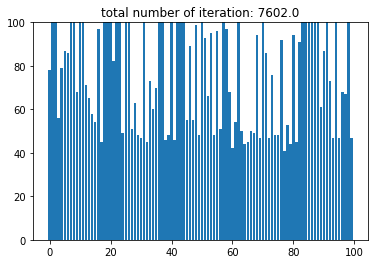

In [18]:
CCR(true_mean, function = 'GMM')

Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441965
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623335
Iteration Number:
 9
Loglikelihood
 -779.4793802521822
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635016
Iteration Number:
 14
Loglikelihood
 -733.3813134512558
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Loglikelihood
 -711.7904969008039
Iteration Number:
 18
Loglikelihood
 -691.241347830593
It

Loglikelihood
 -756.9202060578148
Iteration Number:
 22
Loglikelihood
 -756.887281322537
Iteration Number:
 23
Loglikelihood
 -756.8579486849063
Iteration Number:
 24
Loglikelihood
 -756.8317676395512
Iteration Number:
 25
Loglikelihood
 -756.8083575161479
Iteration Number:
 26
Loglikelihood
 -756.7873858311522
Iteration Number:
 27
Loglikelihood
 -756.7685606531501
Iteration Number:
 28
Loglikelihood
 -756.7516251322461
Iteration Number:
 29
Loglikelihood
 -756.7363532256785
Iteration Number:
 30
Loglikelihood
 -756.7225461211762
Iteration Number:
 31
Loglikelihood
 -756.7100291087937
Iteration Number:
 32
Loglikelihood
 -756.6986487813879
Iteration Number:
 33
Loglikelihood
 -756.6882705079861
Iteration Number:
 34
Loglikelihood
 -756.6787761533903
Iteration Number:
 35
Loglikelihood
 -756.670062028548
Iteration Number:
 36
Loglikelihood
 -756.6620370589554
Iteration Number:
 37
Loglikelihood
 -756.6546211576783
Iteration Number:
 38
Loglikelihood
 -756.6477437880291
Iteration Number

Loglikelihood
 -666.7012497086746
Iteration Number:
 30
Loglikelihood
 -666.7012494662495
Iteration Number:
 31
Loglikelihood
 -666.7012493944325
Iteration Number:
 32
Loglikelihood
 -666.7012493695465
Iteration Number:
 33
Loglikelihood
 -666.7012493599648
Iteration Number:
 34
Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537268
Iteration Number:
 37
Loglikelihood
 -666.7012493534305
Iteration Number:
 38
Loglikelihood
 -666.7012493533036
Iteration Number:
 39
Loglikelihood
 -666.7012493532495
Iteration Number:
 40
Loglikelihood
 -666.7012493532262
Iteration Number:
 41
Loglikelihood
 -666.7012493532162
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number

Loglikelihood
 -860.4734060069353
Iteration Number:
 28
Loglikelihood
 -859.9526938712511
Iteration Number:
 29
Loglikelihood
 -859.3361307180128
Iteration Number:
 30
Loglikelihood
 -858.6865019910913
Iteration Number:
 31
Loglikelihood
 -858.137970293103
Iteration Number:
 32
Loglikelihood
 -857.7605840659975
Iteration Number:
 33
Loglikelihood
 -857.508948250291
Iteration Number:
 34
Loglikelihood
 -857.3249208199521
Iteration Number:
 35
Loglikelihood
 -857.178182332721
Iteration Number:
 36
Loglikelihood
 -857.0557569061916
Iteration Number:
 37
Loglikelihood
 -856.9517139306062
Iteration Number:
 38
Loglikelihood
 -856.8626734321141
Iteration Number:
 39
Loglikelihood
 -856.7862325588502
Iteration Number:
 40
Loglikelihood
 -856.7204683855246
Iteration Number:
 41
Loglikelihood
 -856.6637775934233
Iteration Number:
 42
Loglikelihood
 -856.6148100257337
Iteration Number:
 43
Loglikelihood
 -856.5724272971396
Iteration Number:
 44
Loglikelihood
 -856.5356696380004
Iteration Number:

Iteration Number:
 91
Loglikelihood
 -751.907288783357
Iteration Number:
 92
Loglikelihood
 -751.9072887816261
Iteration Number:
 93
Loglikelihood
 -751.9072887800851
Iteration Number:
 94
Loglikelihood
 -751.9072887787138
Iteration Number:
 95
Loglikelihood
 -751.9072887774932
Iteration Number:
 96
Loglikelihood
 -751.9072887764066
Iteration Number:
 97
Loglikelihood
 -751.9072887754394
Iteration Number:
 98
Loglikelihood
 -751.9072887745783
Iteration Number:
 99
Loglikelihood
 -751.9072887738118
Iteration Number:
 100
Loglikelihood
 -751.9072887731297
Iteration Number:
 1
Loglikelihood
 -1480.8110397902642
Iteration Number:
 2
Loglikelihood
 -1214.5493292784677
Iteration Number:
 3
Loglikelihood
 -981.4102507624773
Iteration Number:
 4
Loglikelihood
 -945.1143164795714
Iteration Number:
 5
Loglikelihood
 -939.519844728071
Iteration Number:
 6
Loglikelihood
 -930.6851164820632
Iteration Number:
 7
Loglikelihood
 -912.0389016235931
Iteration Number:
 8
Loglikelihood
 -862.7338472498291

Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1481.4948964634502
Iteration Number:
 2
Loglikelihood
 -1214.9116048263495
Iteration Number:
 3
Loglikelihood
 -982.2668550801991
Iteration Number:
 4
Loglikelihood
 -944.8246357803367
Iteration Number:
 5
Loglikelihood
 -938.4706164424056
Iteration Number:
 6
Loglikelihood
 -929.1766339653544
Iteration Number:
 7
Loglikelihood
 -911.3982974450613
Iteration Number:
 8
Loglikelihood
 -868.5282776082628
Iteration Number:
 9
Loglikelihood
 -786.0503987458335
Iteration Number:
 10
Loglikelihood
 -756.5732897441742
Iteration Number:
 11
Loglikelihood
 -756.3636034399038
Iteration Number:
 12
Loglikelihood
 -756.2994184886992
Iteration Number:
 13
Loglikelihood
 -756.249053818792
Iteration Number:
 14
Loglikelihood
 -756.2049815640443
Iteration Number:
 15
Loglikelihood
 -756.1631922896006
Iteration Number:
 16
Loglikelihood
 -756.1215645289667


Loglikelihood
 -784.977853973379
Iteration Number:
 10
Loglikelihood
 -755.8622265760071
Iteration Number:
 11
Loglikelihood
 -755.6452002034109
Iteration Number:
 12
Loglikelihood
 -755.5488547585381
Iteration Number:
 13
Loglikelihood
 -755.4531676674238
Iteration Number:
 14
Loglikelihood
 -755.3511413024393
Iteration Number:
 15
Loglikelihood
 -755.2364963281123
Iteration Number:
 16
Loglikelihood
 -755.1024773658485
Iteration Number:
 17
Loglikelihood
 -754.941220120234
Iteration Number:
 18
Loglikelihood
 -754.7439878729192
Iteration Number:
 19
Loglikelihood
 -754.5034233473067
Iteration Number:
 20
Loglikelihood
 -754.2195572317216
Iteration Number:
 21
Loglikelihood
 -753.9087574895336
Iteration Number:
 22
Loglikelihood
 -753.6056136850731
Iteration Number:
 23
Loglikelihood
 -753.3453876636547
Iteration Number:
 24
Loglikelihood
 -753.141569065617
Iteration Number:
 25
Loglikelihood
 -752.9860591896226
Iteration Number:
 26
Loglikelihood
 -752.8643636965593
Iteration Number:

Iteration Number:
 75
Loglikelihood
 -856.281159331648
Iteration Number:
 76
Loglikelihood
 -856.2801894548011
Iteration Number:
 77
Loglikelihood
 -856.2793232670558
Iteration Number:
 78
Loglikelihood
 -856.278549298644
Iteration Number:
 79
Loglikelihood
 -856.2778573865264
Iteration Number:
 80
Loglikelihood
 -856.277238520656
Iteration Number:
 81
Loglikelihood
 -856.276684709078
Iteration Number:
 82
Loglikelihood
 -856.2761888594355
Iteration Number:
 83
Loglikelihood
 -856.2757446747777
Iteration Number:
 84
Loglikelihood
 -856.275346561864
Iteration Number:
 85
Loglikelihood
 -856.2749895503885
Iteration Number:
 86
Loglikelihood
 -856.2746692217742
Iteration Number:
 87
Loglikelihood
 -856.2743816463515
Iteration Number:
 88
Loglikelihood
 -856.2741233278964
Iteration Number:
 89
Loglikelihood
 -856.273891154633
Iteration Number:
 90
Loglikelihood
 -856.273682355922
Iteration Number:
 91
Loglikelihood
 -856.273494463953
Iteration Number:
 92
Loglikelihood
 -856.2733252798424


Iteration Number:
 35
Loglikelihood
 -752.3019987018235
Iteration Number:
 36
Loglikelihood
 -752.2633105088738
Iteration Number:
 37
Loglikelihood
 -752.2260263722465
Iteration Number:
 38
Loglikelihood
 -752.1897383180725
Iteration Number:
 39
Loglikelihood
 -752.1542225857511
Iteration Number:
 40
Loglikelihood
 -752.11937098443
Iteration Number:
 41
Loglikelihood
 -752.0850886458009
Iteration Number:
 42
Loglikelihood
 -752.0511673329613
Iteration Number:
 43
Loglikelihood
 -752.017133707855
Iteration Number:
 44
Loglikelihood
 -751.9820492355578
Iteration Number:
 45
Loglikelihood
 -751.9441958370147
Iteration Number:
 46
Loglikelihood
 -751.9005099130425
Iteration Number:
 47
Loglikelihood
 -751.8455491421646
Iteration Number:
 48
Loglikelihood
 -751.7699977761818
Iteration Number:
 49
Loglikelihood
 -751.6609194680447
Iteration Number:
 50
Loglikelihood
 -751.5137037026321
Iteration Number:
 51
Loglikelihood
 -751.36197597336
Iteration Number:
 52
Loglikelihood
 -751.26300356030

Iteration Number:
 16
Loglikelihood
 -756.7432599775975
Iteration Number:
 17
Loglikelihood
 -756.715078752111
Iteration Number:
 18
Loglikelihood
 -756.6887196095465
Iteration Number:
 19
Loglikelihood
 -756.6633285378517
Iteration Number:
 20
Loglikelihood
 -756.6384004726331
Iteration Number:
 21
Loglikelihood
 -756.6136307488912
Iteration Number:
 22
Loglikelihood
 -756.5888263666143
Iteration Number:
 23
Loglikelihood
 -756.5638546381551
Iteration Number:
 24
Loglikelihood
 -756.5386139983225
Iteration Number:
 25
Loglikelihood
 -756.513017436147
Iteration Number:
 26
Loglikelihood
 -756.4869828798084
Iteration Number:
 27
Loglikelihood
 -756.4604272925154
Iteration Number:
 28
Loglikelihood
 -756.4332626759933
Iteration Number:
 29
Loglikelihood
 -756.4053930008595
Iteration Number:
 30
Loglikelihood
 -756.3767115434432
Iteration Number:
 31
Loglikelihood
 -756.3470983650705
Iteration Number:
 32
Loglikelihood
 -756.3164178153934
Iteration Number:
 33
Loglikelihood
 -756.28451602

Iteration Number:
 86
Loglikelihood
 -856.2744900647327
Iteration Number:
 87
Loglikelihood
 -856.274220733722
Iteration Number:
 88
Loglikelihood
 -856.2739787178673
Iteration Number:
 89
Loglikelihood
 -856.27376111839
Iteration Number:
 90
Loglikelihood
 -856.2735653537155
Iteration Number:
 91
Loglikelihood
 -856.2733891239201
Iteration Number:
 92
Loglikelihood
 -856.2732303792584
Iteration Number:
 93
Loglikelihood
 -856.2730872922898
Iteration Number:
 94
Loglikelihood
 -856.2729582331802
Iteration Number:
 95
Loglikelihood
 -856.272841747809
Iteration Number:
 96
Loglikelihood
 -856.2727365383521
Iteration Number:
 97
Loglikelihood
 -856.2726414460583
Iteration Number:
 98
Loglikelihood
 -856.2725554359617
Iteration Number:
 99
Loglikelihood
 -856.2724775833119
Iteration Number:
 100
Loglikelihood
 -856.2724070615182
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441

Loglikelihood
 -1472.500398170423
Iteration Number:
 2
Loglikelihood
 -1214.9676551774166
Iteration Number:
 3
Loglikelihood
 -985.3727229048907
Iteration Number:
 4
Loglikelihood
 -954.3764241198078
Iteration Number:
 5
Loglikelihood
 -952.1427547273561
Iteration Number:
 6
Loglikelihood
 -949.6569677104549
Iteration Number:
 7
Loglikelihood
 -946.1952040017472
Iteration Number:
 8
Loglikelihood
 -942.1170253548831
Iteration Number:
 9
Loglikelihood
 -937.8069526367922
Iteration Number:
 10
Loglikelihood
 -933.0974361827135
Iteration Number:
 11
Loglikelihood
 -926.9593648929699
Iteration Number:
 12
Loglikelihood
 -918.8333491993579
Iteration Number:
 13
Loglikelihood
 -910.9128051972489
Iteration Number:
 14
Loglikelihood
 -903.6053990756544
Iteration Number:
 15
Loglikelihood
 -893.9621033153073
Iteration Number:
 16
Loglikelihood
 -879.300693754117
Iteration Number:
 17
Loglikelihood
 -868.1606140254338
Iteration Number:
 18
Loglikelihood
 -865.033940427462
Iteration Number:
 19
L

Loglikelihood
 -751.9072894465867
Iteration Number:
 60
Loglikelihood
 -751.9072893691662
Iteration Number:
 61
Loglikelihood
 -751.9072893008457
Iteration Number:
 62
Loglikelihood
 -751.9072892405012
Iteration Number:
 63
Loglikelihood
 -751.9072891871585
Iteration Number:
 64
Loglikelihood
 -751.9072891399701
Iteration Number:
 65
Loglikelihood
 -751.9072890981982
Iteration Number:
 66
Loglikelihood
 -751.9072890611992
Iteration Number:
 67
Loglikelihood
 -751.9072890284098
Iteration Number:
 68
Loglikelihood
 -751.9072889993372
Iteration Number:
 69
Loglikelihood
 -751.907288973549
Iteration Number:
 70
Loglikelihood
 -751.9072889506652
Iteration Number:
 71
Loglikelihood
 -751.9072889303515
Iteration Number:
 72
Loglikelihood
 -751.9072889123136
Iteration Number:
 73
Loglikelihood
 -751.9072888962922
Iteration Number:
 74
Loglikelihood
 -751.9072888820582
Iteration Number:
 75
Loglikelihood
 -751.9072888694095
Iteration Number:
 76
Loglikelihood
 -751.9072888581672
Iteration Numbe

Loglikelihood
 -752.4179028965723
Iteration Number:
 68
Loglikelihood
 -752.3738390659228
Iteration Number:
 69
Loglikelihood
 -752.3327221499767
Iteration Number:
 70
Loglikelihood
 -752.2937677595962
Iteration Number:
 71
Loglikelihood
 -752.2563265526458
Iteration Number:
 72
Loglikelihood
 -752.2199231162434
Iteration Number:
 73
Loglikelihood
 -752.1842630137353
Iteration Number:
 74
Loglikelihood
 -752.1492017390755
Iteration Number:
 75
Loglikelihood
 -752.1146776044147
Iteration Number:
 76
Loglikelihood
 -752.0806141650975
Iteration Number:
 77
Loglikelihood
 -752.0467971397698
Iteration Number:
 78
Loglikelihood
 -752.0127218227856
Iteration Number:
 79
Loglikelihood
 -751.977383730689
Iteration Number:
 80
Loglikelihood
 -751.938940113487
Iteration Number:
 81
Loglikelihood
 -751.8940945563311
Iteration Number:
 82
Loglikelihood
 -751.8369876328557
Iteration Number:
 83
Loglikelihood
 -751.7577115897983
Iteration Number:
 84
Loglikelihood
 -751.6433137807113
Iteration Number

Iteration Number:
 24
Loglikelihood
 -861.6353145284735
Iteration Number:
 25
Loglikelihood
 -861.2836280059694
Iteration Number:
 26
Loglikelihood
 -860.9066344087792
Iteration Number:
 27
Loglikelihood
 -860.4734060069352
Iteration Number:
 28
Loglikelihood
 -859.9526938712511
Iteration Number:
 29
Loglikelihood
 -859.3361307180126
Iteration Number:
 30
Loglikelihood
 -858.6865019910914
Iteration Number:
 31
Loglikelihood
 -858.1379702931031
Iteration Number:
 32
Loglikelihood
 -857.7605840659975
Iteration Number:
 33
Loglikelihood
 -857.5089482502909
Iteration Number:
 34
Loglikelihood
 -857.3249208199521
Iteration Number:
 35
Loglikelihood
 -857.1781823327209
Iteration Number:
 36
Loglikelihood
 -857.0557569061916
Iteration Number:
 37
Loglikelihood
 -856.951713930606
Iteration Number:
 38
Loglikelihood
 -856.862673432114
Iteration Number:
 39
Loglikelihood
 -856.7862325588502
Iteration Number:
 40
Loglikelihood
 -856.7204683855244
Iteration Number:
 41
Loglikelihood
 -856.66377759

Iteration Number:
 33
Loglikelihood
 -666.7012493599648
Iteration Number:
 34
Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537268
Iteration Number:
 37
Loglikelihood
 -666.7012493534305
Iteration Number:
 38
Loglikelihood
 -666.7012493533038
Iteration Number:
 39
Loglikelihood
 -666.7012493532495
Iteration Number:
 40
Loglikelihood
 -666.7012493532262
Iteration Number:
 41
Loglikelihood
 -666.7012493532162
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.7012493532089
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091

Iteration Number:
 97
Loglikelihood
 -753.3960143369686
Iteration Number:
 98
Loglikelihood
 -753.3955043550662
Iteration Number:
 99
Loglikelihood
 -753.3949583400671
Iteration Number:
 100
Loglikelihood
 -753.3943717428249
Iteration Number:
 1
Loglikelihood
 -1481.5970271139586
Iteration Number:
 2
Loglikelihood
 -1215.4290260711796
Iteration Number:
 3
Loglikelihood
 -982.3390706199771
Iteration Number:
 4
Loglikelihood
 -944.773097610568
Iteration Number:
 5
Loglikelihood
 -938.8159514332582
Iteration Number:
 6
Loglikelihood
 -929.7533480062793
Iteration Number:
 7
Loglikelihood
 -912.0742127025001
Iteration Number:
 8
Loglikelihood
 -869.2973057264201
Iteration Number:
 9
Loglikelihood
 -787.1375486412342
Iteration Number:
 10
Loglikelihood
 -757.2549245023026
Iteration Number:
 11
Loglikelihood
 -757.0070826327336
Iteration Number:
 12
Loglikelihood
 -756.9204082877737
Iteration Number:
 13
Loglikelihood
 -756.858371924828
Iteration Number:
 14
Loglikelihood
 -756.8117959300666


Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623336
Iteration Number:
 9
Loglikelihood
 -779.479380252182
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635016
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Loglikelihood
 -711.7904969008041
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065739
Iteration Number:
 20
Loglikelihood
 -667.3175444898961
Iteration Number:
 21
L

Loglikelihood
 -754.7910010133667
Iteration Number:
 11
Loglikelihood
 -752.6235090305113
Iteration Number:
 12
Loglikelihood
 -752.1008745370787
Iteration Number:
 13
Loglikelihood
 -751.9576723742298
Iteration Number:
 14
Loglikelihood
 -751.9210705103108
Iteration Number:
 15
Loglikelihood
 -751.9116635447313
Iteration Number:
 16
Loglikelihood
 -751.9090597557079
Iteration Number:
 17
Loglikelihood
 -751.908225584599
Iteration Number:
 18
Loglikelihood
 -751.9078942012441
Iteration Number:
 19
Loglikelihood
 -751.9077270872037
Iteration Number:
 20
Loglikelihood
 -751.9076247414705
Iteration Number:
 21
Loglikelihood
 -751.9075538103973
Iteration Number:
 22
Loglikelihood
 -751.907501133025
Iteration Number:
 23
Loglikelihood
 -751.9074605169358
Iteration Number:
 24
Loglikelihood
 -751.9074285387667
Iteration Number:
 25
Loglikelihood
 -751.9074030496311
Iteration Number:
 26
Loglikelihood
 -751.9073825743308
Iteration Number:
 27
Loglikelihood
 -751.9073660387485
Iteration Number

Loglikelihood
 -733.3813134512556
Iteration Number:
 15
Loglikelihood
 -729.8059708191506
Iteration Number:
 16
Loglikelihood
 -723.8967927026391
Iteration Number:
 17
Loglikelihood
 -711.790496900804
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065737
Iteration Number:
 20
Loglikelihood
 -667.3175444898961
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23
Loglikelihood
 -666.7053988293476
Iteration Number:
 24
Loglikelihood
 -666.7020269980849
Iteration Number:
 25
Loglikelihood
 -666.7013960107894
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731236
Iteration Number:
 28
Loglikelihood
 -666.7012506819965
Iteration Number:
 29
Loglikelihood
 -666.7012497086746
Iteration Number:
 30
Loglikelihood
 -666.7012494662494
Iteration Number:
 31
Loglikelihood
 -666.7012493944324
Iteration Numbe

Iteration Number:
 75
Loglikelihood
 -753.9746329934126
Iteration Number:
 76
Loglikelihood
 -753.7647242391281
Iteration Number:
 77
Loglikelihood
 -753.5326767984006
Iteration Number:
 78
Loglikelihood
 -753.2785730046626
Iteration Number:
 79
Loglikelihood
 -753.0052673807593
Iteration Number:
 80
Loglikelihood
 -752.7190510820412
Iteration Number:
 81
Loglikelihood
 -752.4298616795991
Iteration Number:
 82
Loglikelihood
 -752.1497879286776
Iteration Number:
 83
Loglikelihood
 -751.8859432367889
Iteration Number:
 84
Loglikelihood
 -751.6305436931591
Iteration Number:
 85
Loglikelihood
 -751.3642469635033
Iteration Number:
 86
Loglikelihood
 -751.0741106097728
Iteration Number:
 87
Loglikelihood
 -750.769504997827
Iteration Number:
 88
Loglikelihood
 -750.4824309764867
Iteration Number:
 89
Loglikelihood
 -750.2438794220823
Iteration Number:
 90
Loglikelihood
 -750.0582755744673
Iteration Number:
 91
Loglikelihood
 -749.911817198428
Iteration Number:
 92
Loglikelihood
 -749.79325319

Loglikelihood
 -666.7012497086745
Iteration Number:
 30
Loglikelihood
 -666.7012494662494
Iteration Number:
 31
Loglikelihood
 -666.7012493944324
Iteration Number:
 32
Loglikelihood
 -666.7012493695465
Iteration Number:
 33
Loglikelihood
 -666.7012493599648
Iteration Number:
 34
Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537268
Iteration Number:
 37
Loglikelihood
 -666.7012493534305
Iteration Number:
 38
Loglikelihood
 -666.7012493533036
Iteration Number:
 39
Loglikelihood
 -666.7012493532495
Iteration Number:
 40
Loglikelihood
 -666.7012493532263
Iteration Number:
 41
Loglikelihood
 -666.7012493532162
Iteration Number:
 42
Loglikelihood
 -666.7012493532119
Iteration Number:
 43
Loglikelihood
 -666.7012493532102
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.7012493532089
Iteration Numb

Loglikelihood
 -666.7012493532163
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.7012493532089
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441965
Iteration Number:
 4
Loglikelihood
 -944.3969668125384
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623332
Iteration Number:
 9
Loglikelihood
 -779.4793802521821
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Lo

Loglikelihood
 -666.7012493944324
Iteration Number:
 32
Loglikelihood
 -666.7012493695465
Iteration Number:
 33
Loglikelihood
 -666.7012493599648
Iteration Number:
 34
Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537268
Iteration Number:
 37
Loglikelihood
 -666.7012493534304
Iteration Number:
 38
Loglikelihood
 -666.7012493533036
Iteration Number:
 39
Loglikelihood
 -666.7012493532495
Iteration Number:
 40
Loglikelihood
 -666.7012493532262
Iteration Number:
 41
Loglikelihood
 -666.7012493532164
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number

Loglikelihood
 -751.9072884114103
Iteration Number:
 92
Loglikelihood
 -751.9072884495672
Iteration Number:
 93
Loglikelihood
 -751.9072884837296
Iteration Number:
 94
Loglikelihood
 -751.9072885142957
Iteration Number:
 95
Loglikelihood
 -751.9072885416285
Iteration Number:
 96
Loglikelihood
 -751.9072885660577
Iteration Number:
 97
Loglikelihood
 -751.9072885878824
Iteration Number:
 98
Loglikelihood
 -751.9072886073723
Iteration Number:
 99
Loglikelihood
 -751.907288624771
Iteration Number:
 100
Loglikelihood
 -751.9072886402987
Iteration Number:
 1
Loglikelihood
 -1471.9056368688596
Iteration Number:
 2
Loglikelihood
 -1213.0901268093696
Iteration Number:
 3
Loglikelihood
 -987.0417684895632
Iteration Number:
 4
Loglikelihood
 -953.5231053361244
Iteration Number:
 5
Loglikelihood
 -950.3021015768134
Iteration Number:
 6
Loglikelihood
 -947.1340799933782
Iteration Number:
 7
Loglikelihood
 -943.7568676732493
Iteration Number:
 8
Loglikelihood
 -940.5302368698506
Iteration Number:
 9

Loglikelihood
 -751.2037616338137
Iteration Number:
 94
Loglikelihood
 -751.2037616338137
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441965
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.942222291043
Iteration Number:
 8
Loglikelihood
 -864.4078839623338
Iteration Number:
 9
Loglikelihood
 -779.4793802521824
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635019
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Lo

Loglikelihood
 -756.1796188547637
Iteration Number:
 37
Loglikelihood
 -756.1408416181669
Iteration Number:
 38
Loglikelihood
 -756.0997119379163
Iteration Number:
 39
Loglikelihood
 -756.0559095332367
Iteration Number:
 40
Loglikelihood
 -756.0090687611705
Iteration Number:
 41
Loglikelihood
 -755.9587634914741
Iteration Number:
 42
Loglikelihood
 -755.9044812311192
Iteration Number:
 43
Loglikelihood
 -755.8455810121986
Iteration Number:
 44
Loglikelihood
 -755.7812285410188
Iteration Number:
 45
Loglikelihood
 -755.7103013892392
Iteration Number:
 46
Loglikelihood
 -755.6312565213747
Iteration Number:
 47
Loglikelihood
 -755.5419526612498
Iteration Number:
 48
Loglikelihood
 -755.4394240118885
Iteration Number:
 49
Loglikelihood
 -755.319620231982
Iteration Number:
 50
Loglikelihood
 -755.177187894491
Iteration Number:
 51
Loglikelihood
 -755.0055293735054
Iteration Number:
 52
Loglikelihood
 -754.7977185069699
Iteration Number:
 53
Loglikelihood
 -754.549321471603
Iteration Number:

Iteration Number:
 88
Loglikelihood
 -752.7186455150816
Iteration Number:
 89
Loglikelihood
 -752.7186454261663
Iteration Number:
 90
Loglikelihood
 -752.7186453561303
Iteration Number:
 91
Loglikelihood
 -752.7186453016916
Iteration Number:
 92
Loglikelihood
 -752.7186452600987
Iteration Number:
 93
Loglikelihood
 -752.7186452290471
Iteration Number:
 94
Loglikelihood
 -752.7186452066096
Iteration Number:
 95
Loglikelihood
 -752.7186451911763
Iteration Number:
 96
Loglikelihood
 -752.7186451814057
Iteration Number:
 97
Loglikelihood
 -752.7186451761803
Iteration Number:
 98
Loglikelihood
 -752.7186451745731
Iteration Number:
 99
Loglikelihood
 -752.7186451758155
Iteration Number:
 100
Loglikelihood
 -752.7186451792725
Iteration Number:
 1
Loglikelihood
 -1481.5508975270136
Iteration Number:
 2
Loglikelihood
 -1215.2165441500943
Iteration Number:
 3
Loglikelihood
 -982.3178097811075
Iteration Number:
 4
Loglikelihood
 -944.7281766563002
Iteration Number:
 5
Loglikelihood
 -938.60339615

Iteration Number:
 40
Loglikelihood
 -666.7012493532263
Iteration Number:
 41
Loglikelihood
 -666.7012493532162
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1481.5508975270136
Iteration Number:
 2
Loglikelihood
 -1215.2165441500943
Iteration Number:
 3
Loglikelihood
 -982.3178097811075
Iteration Number:
 4
Loglikelihood
 -944.7281766563002
Iteration Number:
 5
Loglikelihood
 -938.6033961577983
Iteration Number:
 6
Loglikelihood
 -929.4379953401959
Iteration Number:
 7
Loglikelihood
 -911.731403909459
Iteration Number:
 8
Loglikelihood
 -868.9191791714081
Iteration Number:
 9
Loglikelihood
 -786.5965183228482
It

 85
Loglikelihood
 -751.2037616338238
Iteration Number:
 86
Loglikelihood
 -751.2037616338193
Iteration Number:
 87
Loglikelihood
 -751.2037616338171
Iteration Number:
 88
Loglikelihood
 -751.2037616338155
Iteration Number:
 89
Loglikelihood
 -751.2037616338148
Iteration Number:
 90
Loglikelihood
 -751.2037616338142
Iteration Number:
 91
Loglikelihood
 -751.2037616338139
Iteration Number:
 92
Loglikelihood
 -751.2037616338138
Iteration Number:
 93
Loglikelihood
 -751.2037616338137
Iteration Number:
 94
Loglikelihood
 -751.2037616338137
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148763
Iteration Number:
 7
Loglikelihood
 -906.9422222910426
Iteration Number:
 8
Loglikelihood
 -864.407883962333
Iteration Number:

Loglikelihood
 -918.8333491993583
Iteration Number:
 13
Loglikelihood
 -910.9128051972491
Iteration Number:
 14
Loglikelihood
 -903.6053990756546
Iteration Number:
 15
Loglikelihood
 -893.9621033153076
Iteration Number:
 16
Loglikelihood
 -879.3006937541173
Iteration Number:
 17
Loglikelihood
 -868.1606140254339
Iteration Number:
 18
Loglikelihood
 -865.033940427462
Iteration Number:
 19
Loglikelihood
 -863.9338148516449
Iteration Number:
 20
Loglikelihood
 -863.2825383486208
Iteration Number:
 21
Loglikelihood
 -862.7842592897562
Iteration Number:
 22
Loglikelihood
 -862.363175807156
Iteration Number:
 23
Loglikelihood
 -861.98768244287
Iteration Number:
 24
Loglikelihood
 -861.6353145284735
Iteration Number:
 25
Loglikelihood
 -861.2836280059693
Iteration Number:
 26
Loglikelihood
 -860.9066344087792
Iteration Number:
 27
Loglikelihood
 -860.4734060069353
Iteration Number:
 28
Loglikelihood
 -859.9526938712511
Iteration Number:
 29
Loglikelihood
 -859.3361307180126
Iteration Number:


Iteration Number:
 34
Loglikelihood
 -755.8056600251989
Iteration Number:
 35
Loglikelihood
 -755.7427503752641
Iteration Number:
 36
Loglikelihood
 -755.6739023533555
Iteration Number:
 37
Loglikelihood
 -755.5975563330284
Iteration Number:
 38
Loglikelihood
 -755.5115704561125
Iteration Number:
 39
Loglikelihood
 -755.4130057922234
Iteration Number:
 40
Loglikelihood
 -755.2978604817607
Iteration Number:
 41
Loglikelihood
 -755.160808946031
Iteration Number:
 42
Loglikelihood
 -754.9951499202793
Iteration Number:
 43
Loglikelihood
 -754.7935071063762
Iteration Number:
 44
Loglikelihood
 -754.5503760824245
Iteration Number:
 45
Loglikelihood
 -754.2676882632313
Iteration Number:
 46
Loglikelihood
 -753.9617449643553
Iteration Number:
 47
Loglikelihood
 -753.6631031794485
Iteration Number:
 48
Loglikelihood
 -753.4020783834208
Iteration Number:
 49
Loglikelihood
 -753.1920912393624
Iteration Number:
 50
Loglikelihood
 -753.0288622320096
Iteration Number:
 51
Loglikelihood
 -752.9008172

Iteration Number:
 100
Loglikelihood
 -856.2722848169476
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493958
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623336
Iteration Number:
 9
Loglikelihood
 -779.4793802521822
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635019
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191507
Iteration Number:
 16
Loglikelihood
 -723.8967927026392
Iteration Number:
 17
Loglikelihood
 -711.790496900804
I

Loglikelihood
 -666.7013960107893
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731237
Iteration Number:
 28
Loglikelihood
 -666.7012506819965
Iteration Number:
 29
Loglikelihood
 -666.7012497086746
Iteration Number:
 30
Loglikelihood
 -666.7012494662494
Iteration Number:
 31
Loglikelihood
 -666.7012493944324
Iteration Number:
 32
Loglikelihood
 -666.7012493695465
Iteration Number:
 33
Loglikelihood
 -666.7012493599648
Iteration Number:
 34
Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537267
Iteration Number:
 37
Loglikelihood
 -666.7012493534305
Iteration Number:
 38
Loglikelihood
 -666.7012493533036
Iteration Number:
 39
Loglikelihood
 -666.7012493532495
Iteration Number:
 40
Loglikelihood
 -666.7012493532262
Iteration Number:
 41
Loglikelihood
 -666.7012493532163
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Numbe

Loglikelihood
 -667.3175444898961
Iteration Number:
 21
Loglikelihood
 -666.8124717851321
Iteration Number:
 22
Loglikelihood
 -666.7231435723525
Iteration Number:
 23
Loglikelihood
 -666.7053988293476
Iteration Number:
 24
Loglikelihood
 -666.7020269980851
Iteration Number:
 25
Loglikelihood
 -666.7013960107893
Iteration Number:
 26
Loglikelihood
 -666.7012777342125
Iteration Number:
 27
Loglikelihood
 -666.7012551731239
Iteration Number:
 28
Loglikelihood
 -666.7012506819965
Iteration Number:
 29
Loglikelihood
 -666.7012497086747
Iteration Number:
 30
Loglikelihood
 -666.7012494662494
Iteration Number:
 31
Loglikelihood
 -666.7012493944324
Iteration Number:
 32
Loglikelihood
 -666.7012493695465
Iteration Number:
 33
Loglikelihood
 -666.7012493599648
Iteration Number:
 34
Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537268
Iteration Number:
 37
Loglikelihood
 -666.7012493534305
Iteration Numb

Loglikelihood
 -752.0072593568783
Iteration Number:
 70
Loglikelihood
 -751.9715872735492
Iteration Number:
 71
Loglikelihood
 -751.9324134679414
Iteration Number:
 72
Loglikelihood
 -751.8861262073333
Iteration Number:
 73
Loglikelihood
 -751.8263245129637
Iteration Number:
 74
Loglikelihood
 -751.7423934406097
Iteration Number:
 75
Loglikelihood
 -751.6216505605705
Iteration Number:
 76
Loglikelihood
 -751.4674132714761
Iteration Number:
 77
Loglikelihood
 -751.3262472663329
Iteration Number:
 78
Loglikelihood
 -751.2464636979872
Iteration Number:
 79
Loglikelihood
 -751.216688573546
Iteration Number:
 80
Loglikelihood
 -751.2076572249086
Iteration Number:
 81
Loglikelihood
 -751.2050236273328
Iteration Number:
 82
Loglikelihood
 -751.2042165707257
Iteration Number:
 83
Loglikelihood
 -751.2039448324662
Iteration Number:
 84
Loglikelihood
 -751.2038426294125
Iteration Number:
 85
Loglikelihood
 -751.2037999934713
Iteration Number:
 86
Loglikelihood
 -751.2037806780768
Iteration Numbe

Iteration Number:
 40
Loglikelihood
 -666.7012493532262
Iteration Number:
 41
Loglikelihood
 -666.7012493532163
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1488.3611056432546
Iteration Number:
 2
Loglikelihood
 -1217.4314091965402
Iteration Number:
 3
Loglikelihood
 -987.1641512441967
Iteration Number:
 4
Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493958
Iteration Number:
 6
Loglikelihood
 -926.2894613148765
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623336
Iteration Number:
 9
Loglikelihood
 -779.4793802521822
I

Loglikelihood
 -911.5776715751243
Iteration Number:
 8
Loglikelihood
 -862.4834111368997
Iteration Number:
 9
Loglikelihood
 -775.4577787356206
Iteration Number:
 10
Loglikelihood
 -761.9161020336023
Iteration Number:
 11
Loglikelihood
 -759.7181577141066
Iteration Number:
 12
Loglikelihood
 -758.7808340131328
Iteration Number:
 13
Loglikelihood
 -758.2348982532503
Iteration Number:
 14
Loglikelihood
 -758.0163753457289
Iteration Number:
 15
Loglikelihood
 -757.8864594179037
Iteration Number:
 16
Loglikelihood
 -757.7849536368003
Iteration Number:
 17
Loglikelihood
 -757.6982844376848
Iteration Number:
 18
Loglikelihood
 -757.6211054116256
Iteration Number:
 19
Loglikelihood
 -757.5506118222661
Iteration Number:
 20
Loglikelihood
 -757.485041426735
Iteration Number:
 21
Loglikelihood
 -757.4232012813502
Iteration Number:
 22
Loglikelihood
 -757.3642821228839
Iteration Number:
 23
Loglikelihood
 -757.3077668729254
Iteration Number:
 24
Loglikelihood
 -757.2533747475031
Iteration Number:

Loglikelihood
 -666.7012493560583
Iteration Number:
 35
Loglikelihood
 -666.7012493544214
Iteration Number:
 36
Loglikelihood
 -666.7012493537268
Iteration Number:
 37
Loglikelihood
 -666.7012493534305
Iteration Number:
 38
Loglikelihood
 -666.7012493533036
Iteration Number:
 39
Loglikelihood
 -666.7012493532495
Iteration Number:
 40
Loglikelihood
 -666.7012493532263
Iteration Number:
 41
Loglikelihood
 -666.7012493532162
Iteration Number:
 42
Loglikelihood
 -666.701249353212
Iteration Number:
 43
Loglikelihood
 -666.7012493532103
Iteration Number:
 44
Loglikelihood
 -666.7012493532095
Iteration Number:
 45
Loglikelihood
 -666.7012493532092
Iteration Number:
 46
Loglikelihood
 -666.701249353209
Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1481.5508975270136
Iteration Number:
 2
Loglikelihood
 -1215.2165441500943
Iteration Number:
 3
Loglikelihood
 -982.3178097811075
Iteration Number:

Iteration Number:
 47
Loglikelihood
 -666.7012493532088
Iteration Number:
 48
Loglikelihood
 -666.7012493532088
Iteration Number:
 1
Loglikelihood
 -1472.452716571965
Iteration Number:
 2
Loglikelihood
 -1214.4982807663448
Iteration Number:
 3
Loglikelihood
 -988.3705127164666
Iteration Number:
 4
Loglikelihood
 -953.6714758986939
Iteration Number:
 5
Loglikelihood
 -951.5134118406664
Iteration Number:
 6
Loglikelihood
 -948.5846704380814
Iteration Number:
 7
Loglikelihood
 -945.208891090736
Iteration Number:
 8
Loglikelihood
 -941.9412536752218
Iteration Number:
 9
Loglikelihood
 -938.9602704310546
Iteration Number:
 10
Loglikelihood
 -936.2797794784829
Iteration Number:
 11
Loglikelihood
 -933.8274600577224
Iteration Number:
 12
Loglikelihood
 -931.5070548136695
Iteration Number:
 13
Loglikelihood
 -929.204843973966
Iteration Number:
 14
Loglikelihood
 -926.7188398596154
Iteration Number:
 15
Loglikelihood
 -923.621794631051
Iteration Number:
 16
Loglikelihood
 -918.9419326382331
Ite

Loglikelihood
 -978.7321983534715
Iteration Number:
 4
Loglikelihood
 -944.305748060327
Iteration Number:
 5
Loglikelihood
 -937.5213349586398
Iteration Number:
 6
Loglikelihood
 -926.5122526611451
Iteration Number:
 7
Loglikelihood
 -903.608690730528
Iteration Number:
 8
Loglikelihood
 -859.3851430555385
Iteration Number:
 9
Loglikelihood
 -807.3988310142255
Iteration Number:
 10
Loglikelihood
 -764.8417359752691
Iteration Number:
 11
Loglikelihood
 -758.93361475002
Iteration Number:
 12
Loglikelihood
 -756.7378553132455
Iteration Number:
 13
Loglikelihood
 -756.1199571818113
Iteration Number:
 14
Loglikelihood
 -755.795202553652
Iteration Number:
 15
Loglikelihood
 -755.5965568371653
Iteration Number:
 16
Loglikelihood
 -755.463778387063
Iteration Number:
 17
Loglikelihood
 -755.360114785688
Iteration Number:
 18
Loglikelihood
 -755.2644908241834
Iteration Number:
 19
Loglikelihood
 -755.1654934322835
Iteration Number:
 20
Loglikelihood
 -755.0568039529314
Iteration Number:
 21
Logli

Loglikelihood
 -944.3969668125385
Iteration Number:
 5
Loglikelihood
 -937.1403787493957
Iteration Number:
 6
Loglikelihood
 -926.2894613148763
Iteration Number:
 7
Loglikelihood
 -906.9422222910428
Iteration Number:
 8
Loglikelihood
 -864.4078839623334
Iteration Number:
 9
Loglikelihood
 -779.4793802521822
Iteration Number:
 10
Loglikelihood
 -743.23059661664
Iteration Number:
 11
Loglikelihood
 -740.6933941431091
Iteration Number:
 12
Loglikelihood
 -738.4017481848869
Iteration Number:
 13
Loglikelihood
 -736.0525416635016
Iteration Number:
 14
Loglikelihood
 -733.3813134512557
Iteration Number:
 15
Loglikelihood
 -729.8059708191506
Iteration Number:
 16
Loglikelihood
 -723.8967927026391
Iteration Number:
 17
Loglikelihood
 -711.790496900804
Iteration Number:
 18
Loglikelihood
 -691.2413478305932
Iteration Number:
 19
Loglikelihood
 -672.8495975065738
Iteration Number:
 20
Loglikelihood
 -667.317544489896
Iteration Number:
 21
Loglikelihood
 -666.8124717851322
Iteration Number:
 22
L

0.836

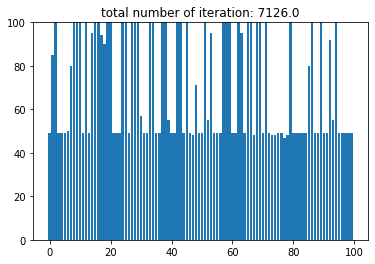

In [21]:
CCR(true_mean, function = 'GMM_kmean_init')

In [4]:
### ASSIGNMENT 9 

In [64]:
# Load data
cwd = os.getcwd()
file_name = 'usps.mat'
path_to_data = cwd + '/data/' + file_name
assert os.path.exists(path_to_data), "The path to the data does not exist."

data = sio.loadmat(path_to_data)

data_labels = data['data_labels']
usps_data = data['data_patterns'].T
kn = 10

In [108]:
# k-means on 5 usps data sets
mu, r, loss = kmeans(X = usps_data, k = kn)
print('Centroids: ' + str(mu))

Centroids: [[-0.99925215 -0.995936   -0.98109206 ... -0.9974088  -0.99975308
  -0.99997495]
 [-0.97371652 -0.92620589 -0.84405071 ... -0.96624743 -0.9900076
  -0.99646995]
 [-0.97277099 -0.90578539 -0.78064513 ... -0.99511659 -0.99910996
  -0.99994187]
 ...
 [-0.99521299 -0.98501589 -0.9541278  ... -0.91011347 -0.96836288
  -0.99107887]
 [-0.98538843 -0.94932444 -0.87016094 ... -0.79876864 -0.92331378
  -0.98040006]
 [-0.99996616 -0.9993896  -0.99634084 ... -0.97310163 -0.99419142
  -0.99796392]]


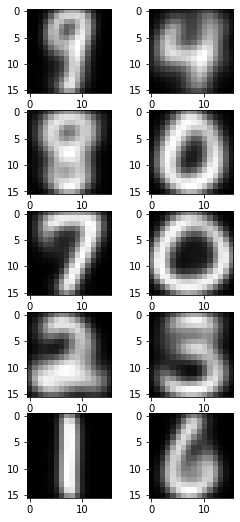

In [109]:
# results / Centroids Visualization of k-means 
fig = plt.figure(figsize=(4, 9))
gs = fig.add_gridspec(5, 2)
for i in range(len(mu)):
    f_ax1 = fig.add_subplot(gs[i%5,int(i>=5)])
    plt.imshow(mu[i].reshape(16,16), cmap = 'gray')

In [118]:
# GMM on 5 gaussian data sets - without k-means initialization
pi, mu, list_sigma, likelihoods = em_gmm(X = usps_data[:1000], k = 10, tol = 0.05, max_iter = 100)
print('Centroids: ' + str(mu))

Iteration Number:
 1
Loglikelihood
 -273923.82678365824
Iteration Number:
 2
Loglikelihood
 74397.80710386002
Iteration Number:
 3
Loglikelihood
 77433.18829467177
Iteration Number:
 4
Loglikelihood
 78021.71200950349
Iteration Number:
 5
Loglikelihood
 78155.29298772063
Iteration Number:
 6
Loglikelihood
 78186.80642028622
Iteration Number:
 7
Loglikelihood
 78231.89290890505
Iteration Number:
 8
Loglikelihood
 78280.46171872996
Iteration Number:
 9
Loglikelihood
 78319.45006041885
Iteration Number:
 10
Loglikelihood
 78408.13307469751
Iteration Number:
 11
Loglikelihood
 78499.83997246517
Iteration Number:
 12
Loglikelihood
 78560.09723767333
Iteration Number:
 13
Loglikelihood
 78647.02995654813
Iteration Number:
 14
Loglikelihood
 78672.34807508098
Iteration Number:
 15
Loglikelihood
 78705.49500546313
Iteration Number:
 16
Loglikelihood
 78757.35813438024
Iteration Number:
 17
Loglikelihood
 78757.46500695727
Iteration Number:
 18
Loglikelihood
 78757.57737040042
Iteration Number:

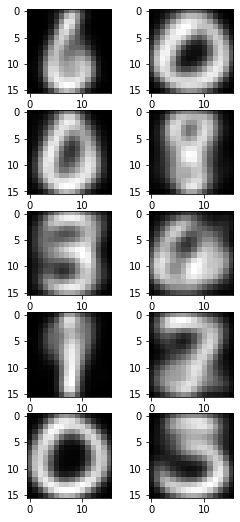

In [117]:
# results / Centroids Visualization of GMM-means 
fig = plt.figure(figsize=(4, 9))
gs = fig.add_gridspec(5, 2)
for i in range(len(mu)):
    f_ax1 = fig.add_subplot(gs[i%5,int(i>=5)])
    plt.imshow(mu[i].reshape(16,16), cmap = 'gray')

In [ ]:
# GMM on 5 gaussian data sets - with k-means initialization
pi, mu, list_sigma, likelihoods = em_gmm(X = usps_data[:1000, k = 10,init_kmeans = True, tol=0.05, max_iter = 40)
print('Centroids: ' + str(mu))

Iteration Number:
 1
Loglikelihood
 -515488.53896300984
Iteration Number:
 2
Loglikelihood
 154793.15249451957
Iteration Number:
 3
Loglikelihood
 157613.78157034473
Iteration Number:
 4
Loglikelihood
 157962.61946575163


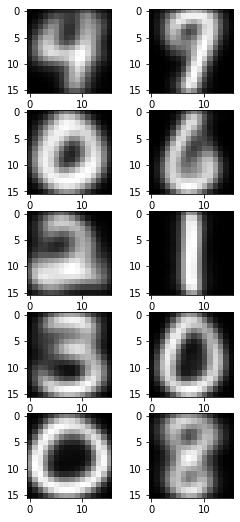

In [123]:
# results / Centroids Visualization of GMM-means with k-means initialization 
fig = plt.figure(figsize=(4, 9))
gs = fig.add_gridspec(5, 2)
for i in range(len(mu)):
    f_ax1 = fig.add_subplot(gs[i%5,int(i>=5)])
    plt.imshow(mu[i].reshape(16,16), cmap = 'gray')

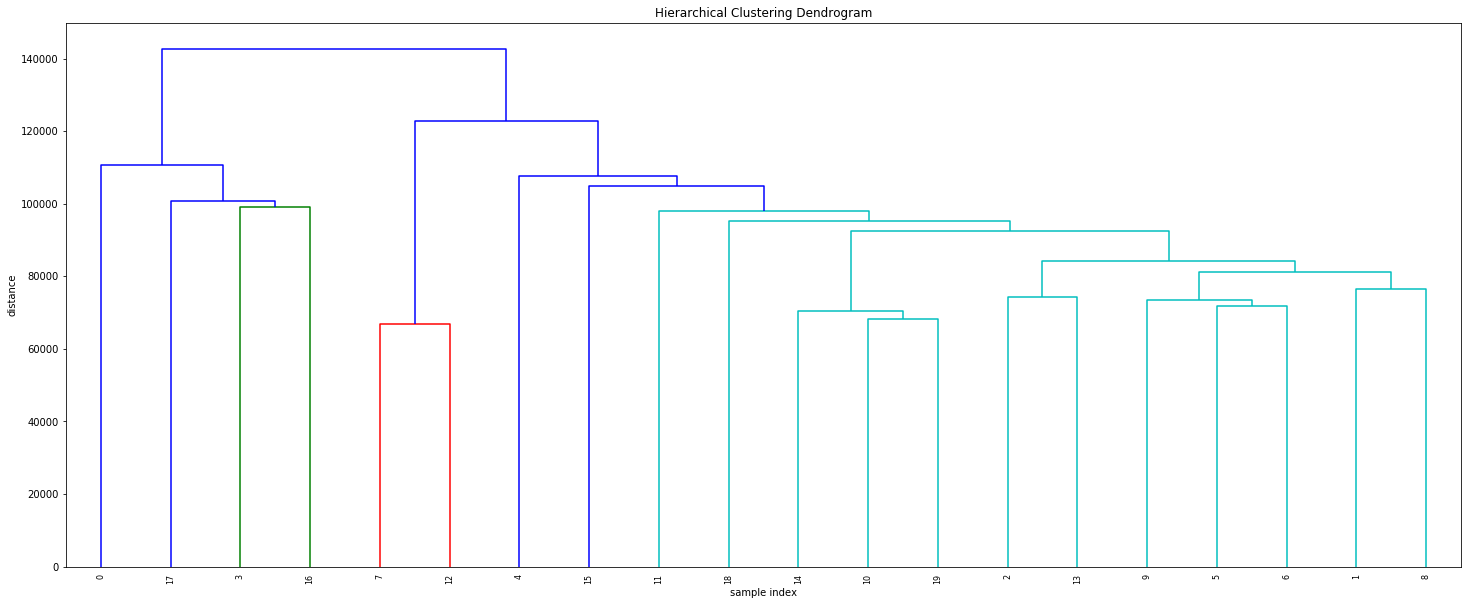

In [49]:
# dendogram of hierarchical clustering
kn = 20
# k-means on 5 usps data sets
mu, r, loss = kmeans(X = usps_data, k = kn)
# hierarchical clustering starting from kmean results
R, kmloss, mergeidx = kmeans_agglo(usps_data,r)
# plot dendrogram
agglo_dendro(kmloss, mergeidx)

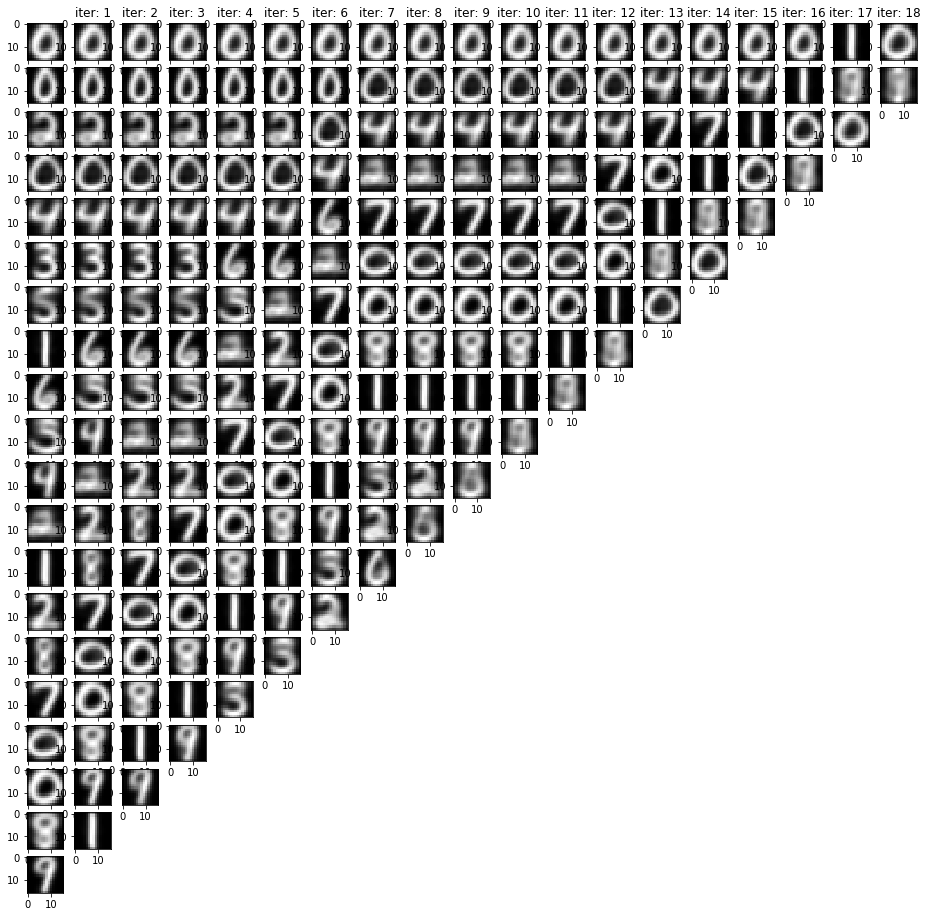

In [50]:
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(len(R)+1, len(R))
for i, r in enumerate(R):
    # calculate init centroids
    w_q = np.array([np.sum(usps_data[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
    for j, mu in enumerate(w_q):
        f_ax1 = fig.add_subplot(gs[j,i])
        plt.imshow(mu.reshape(16,16), cmap = 'gray')
        if (i > 0 and j == 0):
            plt.title('iter: {}'.format(i))

In [35]:
np.unique(R[1])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 19., 20.])

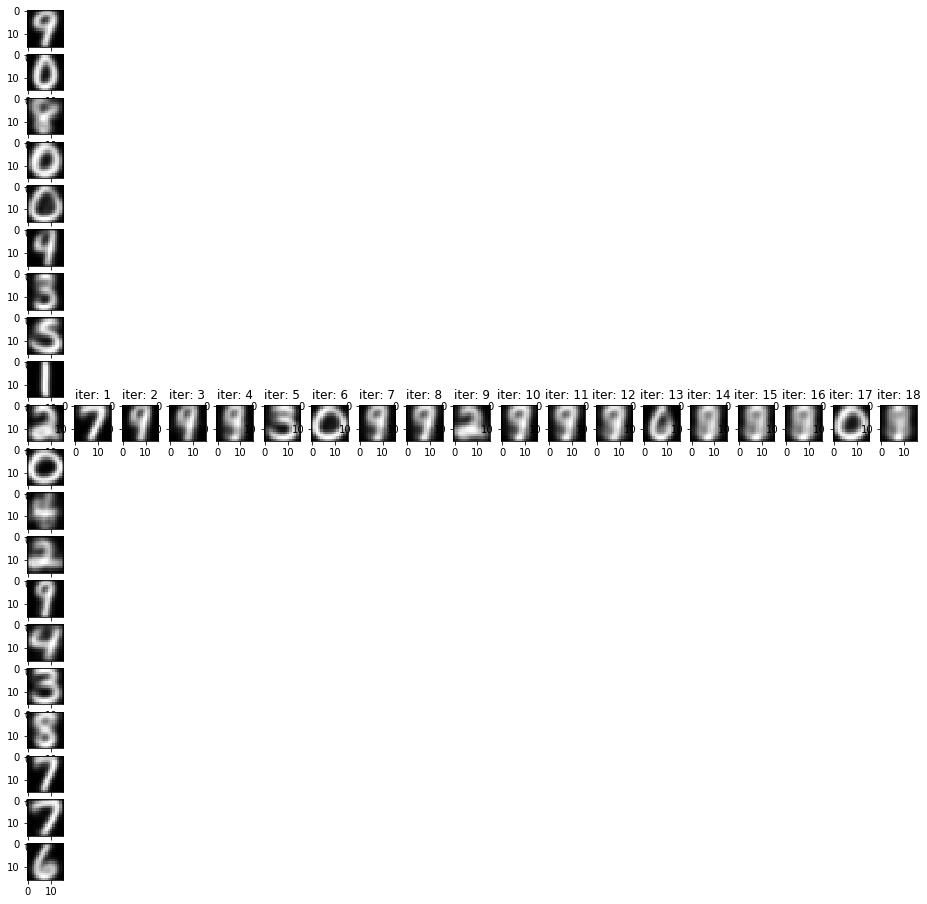

In [37]:
fig = plt.figure(figsize=(16, 16))
gs = fig.add_gridspec(len(R)+1, len(R))
for i, r in enumerate(R):
    if i == 0:
        # calculate init centroids
        w_q = np.array([np.sum(usps_data[r == j], axis = 0) / (np.sum(r == j)) for j in np.unique(r)])
        for j, mu in enumerate(w_q):
            f_ax1 = fig.add_subplot(gs[j,i])
            plt.imshow(mu.reshape(16,16), cmap = 'gray')
    else:
        mu = np.array(np.sum(usps_data[r == np.max(r)], axis = 0) / (np.sum(r == np.max(r))))
        f_ax1 = fig.add_subplot(gs[9,i])
        plt.imshow(mu.reshape(16,16), cmap = 'gray')
        plt.title('iter: {}'.format(i))

In [57]:
np.max(r)

37.0

In [53]:
i+len(R)+1

38

In [62]:
np.unique(R[1])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 19., 20.])